## Моделирование склонности клиентов банка к открытию депозита

### В работе были реализованы следующие методы: линейная и логистическая регрессия, метод ближайших соседей, деревья решений, метод опорных векторов, случайный лес, бустинг, градиентный бустинг, stacking. 
### Для оценки качества для каждой модели были высчитаны показатели: accuracy, recall, support, F-бета, а также матрица сопряженности, были построены ROC-кривые со значением AUC. 
### С помощью анализа всех этих параметров было выявлено, что для нашего набора данных лучше всего подходит метод бустинг.

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
data = pd.read_csv('bank_term_deposit.csv',sep=',')
data

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y
0,30.0,unemployed,married,primary,no,1787.0,no,no,19,oct,79,1,-1,0,unknown,no
1,33.0,services,married,secondary,no,4789.0,yes,yes,11,may,220,1,339,4,failure,no
2,NaN,management,single,tertiary,no,135.0,yes,no,16,apr,185,1,330,1,failure,no
3,30.0,management,married,tertiary,no,1476.0,yes,yes,3,jun,199,4,-1,0,unknown,no
4,59.0,blue-collar,married,secondary,no,NaN,yes,no,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33.0,services,married,secondary,no,-333.0,yes,no,30,jul,329,5,-1,0,unknown,no
4517,57.0,self-employed,married,tertiary,yes,-3313.0,yes,yes,9,may,153,1,-1,0,unknown,no
4518,57.0,technician,married,secondary,no,295.0,no,no,19,aug,151,11,-1,0,unknown,no
4519,28.0,blue-collar,married,secondary,no,1137.0,no,no,6,feb,129,4,211,3,other,no


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        3984 non-null   float64
 1   job        4521 non-null   object 
 2   marital    4521 non-null   object 
 3   education  4521 non-null   object 
 4   default    4521 non-null   object 
 5   balance    4164 non-null   float64
 6   housing    4521 non-null   object 
 7   loan       4521 non-null   object 
 8   day        4521 non-null   int64  
 9   month      4521 non-null   object 
 10  duration   4521 non-null   int64  
 11  campaign   4521 non-null   int64  
 12  pdays      4521 non-null   int64  
 13  previous   4521 non-null   int64  
 14  poutcome   4521 non-null   object 
 15  y          4521 non-null   object 
dtypes: float64(2), int64(5), object(9)
memory usage: 565.2+ KB


Информация о данных:

* age: возраст клиента
* job :тип работы
* marital :семейное положение
* balance: средний годовой баланс в евро
* education: уровень образования
* default: есть кредит по умолчанию?
* housing: есть жилищный кредит?
* loan: есть личный кредит?
* month: месяц последнего контакта в году
* day: день последнего контакта недели
* duration: продолжительность последнего контакта в секундах
* campaign: количество контактов, выполненных во время этой кампании и для этой клиент
* pdays: количество дней, прошедших с момента последнего контакта с клиентом из предыдущей кампании
* previous: количество контактов, выполненных до этой кампании и для этого клиента
* poutcome: итог предыдущей маркетинговой кампании сотрудников -квартальный показатель (числовой)
* у -оформил ли клиент срочный вклад? (двоичный: «да», «нет»)

Первый взгляд позволяет сделать выводы:

    * в наборе данных представлены данные по 4521 клиенту банка
    * есть пропуски в столбцах age и balance
    * данные разных типов - строковые, числовые


In [4]:
data.duplicated().sum()

0

Следовательно, повторяющихся строк в данных нет.

In [5]:
# поиск дубликатов в education
lst = data.columns.tolist()
for i in lst:
    print(i)
    print(data[f'{i}'].value_counts())
    print('-'*50)

age
32.0    224
31.0    199
36.0    188
33.0    186
37.0    161
       ... 
68.0      2
87.0      1
81.0      1
86.0      1
84.0      1
Name: age, Length: 61, dtype: int64
--------------------------------------------------
job
management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64
--------------------------------------------------
marital
married     2797
single      1196
divorced     528
Name: marital, dtype: int64
--------------------------------------------------
education
secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64
--------------------------------------------------
default
no     4445
yes      76
Name: default, dtype: int64
--------------------------------------------------
balance
2.0       32
1.0       28


Значение unknown встречается:
    * в столбце job  38 раз
    * в столбце education  187 раз
Они составляют 0.8 и  4% от общего количестваа данных соответственно. 
Удалим строки, где были значения unknown в столбцах job, education. 
Так как по другим столбцам их не восстановить и чтобы исключить влияние смещения данных. 

In [6]:
data = data.drop(data[data['job'] == 'unknown'].index).reset_index(drop=True)
data = data.drop(data[data['education'] == 'unknown'].index).reset_index(drop=True)
data

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y
0,30.0,unemployed,married,primary,no,1787.0,no,no,19,oct,79,1,-1,0,unknown,no
1,33.0,services,married,secondary,no,4789.0,yes,yes,11,may,220,1,339,4,failure,no
2,NaN,management,single,tertiary,no,135.0,yes,no,16,apr,185,1,330,1,failure,no
3,30.0,management,married,tertiary,no,1476.0,yes,yes,3,jun,199,4,-1,0,unknown,no
4,59.0,blue-collar,married,secondary,no,NaN,yes,no,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4306,33.0,services,married,secondary,no,-333.0,yes,no,30,jul,329,5,-1,0,unknown,no
4307,57.0,self-employed,married,tertiary,yes,-3313.0,yes,yes,9,may,153,1,-1,0,unknown,no
4308,57.0,technician,married,secondary,no,295.0,no,no,19,aug,151,11,-1,0,unknown,no
4309,28.0,blue-collar,married,secondary,no,1137.0,no,no,6,feb,129,4,211,3,other,no


In [7]:
data.duplicated().sum()

0

**Вывод**

Проверили новую таблицу на дубликаты.
В таблице удалены все явные и неявные дубликаты датасета.

In [8]:
data.isna().sum()

age          517
job            0
marital        0
education      0
default        0
balance      339
housing        0
loan           0
day            0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

Заполним пропуски в столбце баланса медианным значением, чтобы исключить влияние смещения данных и удостоверимся, что пропуски устранены

In [9]:
data['balance'] = data['balance'].fillna(data['balance'].median()) 
data.isna().sum()

age          517
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
day            0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

Удалим строки, где клиенты не указали возраст.

In [10]:
data = data.loc[data['age'].isna()!=1].reset_index(drop=True)
data

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y
0,30.0,unemployed,married,primary,no,1787.0,no,no,19,oct,79,1,-1,0,unknown,no
1,33.0,services,married,secondary,no,4789.0,yes,yes,11,may,220,1,339,4,failure,no
2,30.0,management,married,tertiary,no,1476.0,yes,yes,3,jun,199,4,-1,0,unknown,no
3,59.0,blue-collar,married,secondary,no,298.0,yes,no,5,may,226,1,-1,0,unknown,no
4,36.0,self-employed,married,tertiary,no,37.0,yes,no,14,may,341,1,330,2,other,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3789,33.0,services,married,secondary,no,-333.0,yes,no,30,jul,329,5,-1,0,unknown,no
3790,57.0,self-employed,married,tertiary,yes,-3313.0,yes,yes,9,may,153,1,-1,0,unknown,no
3791,57.0,technician,married,secondary,no,295.0,no,no,19,aug,151,11,-1,0,unknown,no
3792,28.0,blue-collar,married,secondary,no,1137.0,no,no,6,feb,129,4,211,3,other,no


Проверим, для всех ли строк возраст указан корректно - не обращаются ли за кредитом дети до 16 лет

In [11]:
data['age'] = data['age'].astype('int')
print(data['age'].min(),data['age'].max())
print(data.isna().sum())

19 87
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [12]:
data = data.replace({'yes' : 1, 'no' : 0})

In [13]:
data.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787.0,0,0,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789.0,1,1,11,may,220,1,339,4,failure,0
2,30,management,married,tertiary,0,1476.0,1,1,3,jun,199,4,-1,0,unknown,0
3,59,blue-collar,married,secondary,0,298.0,1,0,5,may,226,1,-1,0,unknown,0
4,36,self-employed,married,tertiary,0,37.0,1,0,14,may,341,1,330,2,other,0


In [14]:
data2 = data.copy(deep=True)
data2

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787.0,0,0,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789.0,1,1,11,may,220,1,339,4,failure,0
2,30,management,married,tertiary,0,1476.0,1,1,3,jun,199,4,-1,0,unknown,0
3,59,blue-collar,married,secondary,0,298.0,1,0,5,may,226,1,-1,0,unknown,0
4,36,self-employed,married,tertiary,0,37.0,1,0,14,may,341,1,330,2,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3789,33,services,married,secondary,0,-333.0,1,0,30,jul,329,5,-1,0,unknown,0
3790,57,self-employed,married,tertiary,1,-3313.0,1,1,9,may,153,1,-1,0,unknown,0
3791,57,technician,married,secondary,0,295.0,0,0,19,aug,151,11,-1,0,unknown,0
3792,28,blue-collar,married,secondary,0,1137.0,0,0,6,feb,129,4,211,3,other,0


**Вывод**

Для подготовки данных были применены такие функции, как: очистка от незаполненных ячеек/строк, заполнение медианным значением пропуски в столбце баланса, проверка на дубликаты.

## Предварительный анализ - проверка зависимости целевой переменной Y от отдельных категориальных признаков

In [15]:
lst = ['job','marital','education','default','housing','loan','month']
for i in lst:
    
    print(data.groupby(f'{i}')['y'].mean())
    print('-'*50)

job
admin.           0.113350
blue-collar      0.075094
entrepreneur     0.083333
housemaid        0.103093
management       0.139733
retired          0.235000
self-employed    0.100000
services         0.084469
student          0.276923
technician       0.111285
unemployed       0.086207
Name: y, dtype: float64
--------------------------------------------------
marital
divorced    0.142222
married     0.095667
single      0.145114
Name: y, dtype: float64
--------------------------------------------------
education
primary      0.090762
secondary    0.106309
tertiary     0.140893
Name: y, dtype: float64
--------------------------------------------------
default
0    0.114362
1    0.115942
Name: y, dtype: float64
--------------------------------------------------
housing
0    0.153799
1    0.084225
Name: y, dtype: float64
--------------------------------------------------
loan
0    0.123637
1    0.063465
Name: y, dtype: float64
--------------------------------------------------
month
ap

Пока наблюдаются зависимость целевой переменной от следующих признаков:
* в осовном срочные депозиты открывают студенты и люди на пенсии
* люди в разводе
* люди с высшим образованием
* у кого нет квартиры
* у кого нет заимствований 
* в март, сентябрь, октябрь, декабрь.


### Проверяем сбалансированность классов

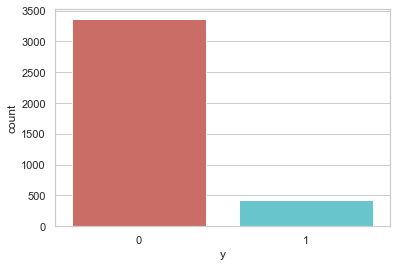

In [16]:
sns.countplot(x='y', data = data, palette = 'hls')
plt.show()

Классы не сбалансированы, не оформивших срочный вклад (0) значительно больше тех, кто оформил срочный вклад (1)

## Визуализации и предварительный отбор признаков

Text(0, 0.5, 'Доля клиентов')

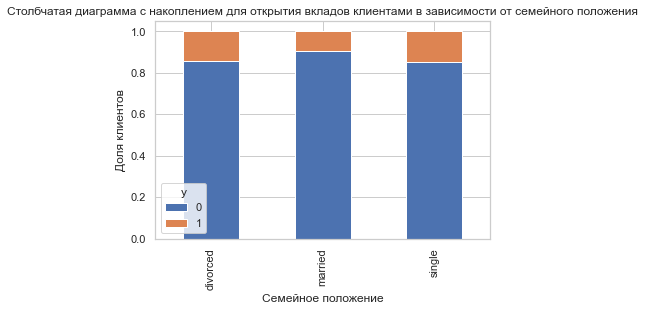

In [17]:
%matplotlib inline
table=pd.crosstab(data['marital'], data['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Столбчатая диаграмма с накоплением для открытия вкладов клиентами в зависимости от семейного положения')
plt.xlabel('Семейное положение')
plt.ylabel('Доля клиентов')

Семейное положение не очень хороший фактор для предсказания вероятности открытия вклада клиентом

Text(0, 0.5, 'Доля клиентов')

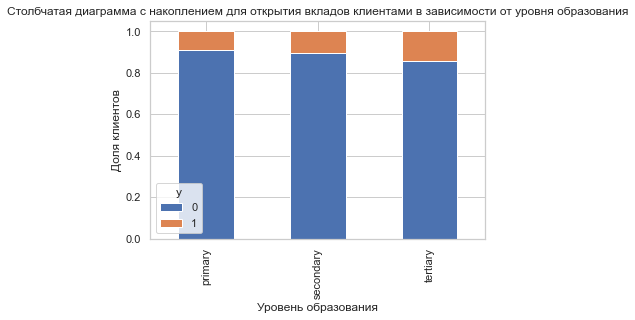

In [18]:
table = pd.crosstab(data['education'], data['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Столбчатая диаграмма с накоплением для открытия вкладов клиентами в зависимости от уровня образования')
plt.xlabel('Уровень образования')
plt.ylabel('Доля клиентов')

Уровень образование также не очень сильно влияет на вероятность открытия вклада клиентом

Text(0, 0.5, 'Доля клиентов')

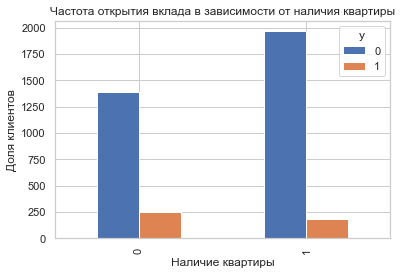

In [19]:
pd.crosstab(data['housing'], data['y']).plot(kind='bar')
plt.title('Частота открытия вклада в зависимости от наличия квартиры')
plt.xlabel('Наличие квартиры')
plt.ylabel('Доля клиентов')

Наличие квартиры может повлиять на вероятность открытия вклада клиентом

Text(0, 0.5, 'Доля клиентов')

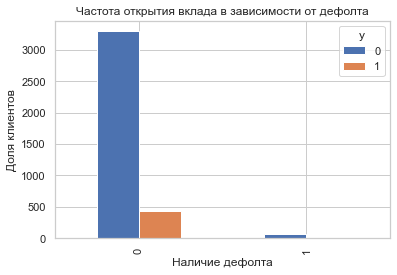

In [20]:
pd.crosstab(data['default'], data['y']).plot(kind='bar')
plt.title('Частота открытия вклада в зависимости от дефолта')
plt.xlabel('Наличие дефолта')
plt.ylabel('Доля клиентов')

In [21]:
data.groupby('default')['y'].mean()

default
0    0.114362
1    0.115942
Name: y, dtype: float64

Срочные вклады оформляют в основном финансово состоятельные люди

Text(0, 0.5, 'Доля клиентов')

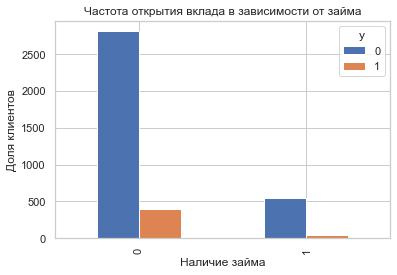

In [22]:
pd.crosstab(data['loan'], data['y']).plot(kind='bar')
plt.title('Частота открытия вклада в зависимости от займа')
plt.xlabel('Наличие займа')
plt.ylabel('Доля клиентов')

In [23]:
data.groupby('loan')['y'].mean()

loan
0    0.123637
1    0.063465
Name: y, dtype: float64

Можно сказать, что при отсутствии займов люди чаще оформляют срочные вклады

Text(0, 0.5, 'Доля клиентов')

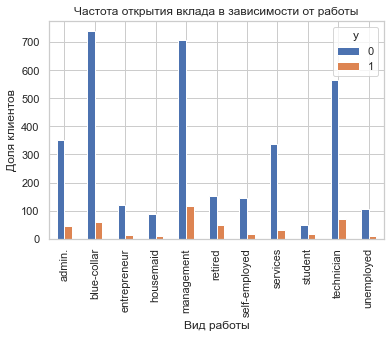

In [24]:
pd.crosstab(data['job'], data['y']).plot(kind='bar')
plt.title('Частота открытия вклада в зависимости от работы')
plt.xlabel('Вид работы')
plt.ylabel('Доля клиентов')

In [25]:
data.groupby('job')['y'].mean()

job
admin.           0.113350
blue-collar      0.075094
entrepreneur     0.083333
housemaid        0.103093
management       0.139733
retired          0.235000
self-employed    0.100000
services         0.084469
student          0.276923
technician       0.111285
unemployed       0.086207
Name: y, dtype: float64

Заметны различия в долях, job может являться признаком для прогнозирования.

Text(0, 0.5, 'Доля клиентов')

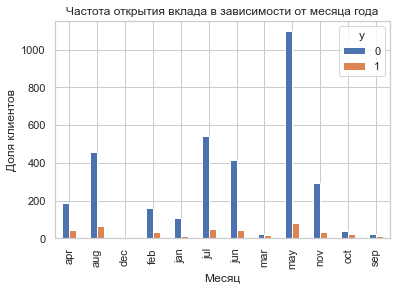

In [26]:
pd.crosstab(data['month'], data['y']).plot(kind='bar')
plt.title('Частота открытия вклада в зависимости от месяца года')
plt.xlabel('Месяц')
plt.ylabel('Доля клиентов')

In [27]:
data.groupby('month')['y'].mean()

month
apr    0.189655
aug    0.122371
dec    0.500000
feb    0.183673
jan    0.122951
jul    0.087102
jun    0.101512
mar    0.400000
may    0.067969
nov    0.100304
oct    0.406250
sep    0.384615
Name: y, dtype: float64

Заметны различия в долях, month может являться признаком для прогнозирования.

Text(0, 0.5, 'Частота')

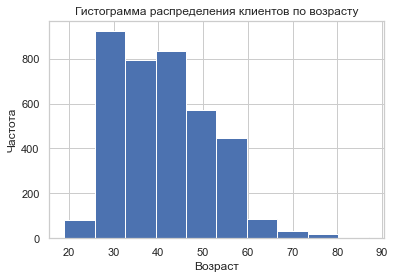

In [28]:
data['age'].hist()
plt.title('Гистограмма распределения клиентов по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Частота')

Преобладают люди среднего возраста 30-60 лет

**Вывод:**

Выявлено, что целевая переменная зависит вида деятельности (студенты, пенсионеры), образования (высшее), отсутствия заимствований, семейного положения (люди в разводе).

### Создание индикаторных переменных-признаков


In [29]:
cat_vars=['job', 'education','marital', 'month']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1

In [30]:
print(data.columns.tolist())

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'education_primary', 'education_secondary', 'education_tertiary', 'marital_divorced', 'marital_married', 'marital_single', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep']


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3794 non-null   int32  
 1   job                  3794 non-null   object 
 2   marital              3794 non-null   object 
 3   education            3794 non-null   object 
 4   default              3794 non-null   int64  
 5   balance              3794 non-null   float64
 6   housing              3794 non-null   int64  
 7   loan                 3794 non-null   int64  
 8   day                  3794 non-null   int64  
 9   month                3794 non-null   object 
 10  duration             3794 non-null   int64  
 11  campaign             3794 non-null   int64  
 12  pdays                3794 non-null   int64  
 13  previous             3794 non-null   int64  
 14  poutcome             3794 non-null   object 
 15  y                    3794 non-null   i

Удаляем столбцы 'job', 'education','marital', 'month', из которых создавали новые, получаем итоговый набор данных

In [32]:
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data = data[to_keep]
data.drop(columns=['poutcome'], inplace=True) 


<ipython-input-32-5b14254e6beb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['poutcome'], inplace=True)


Финальный набор переменных (признаков)

In [33]:
data.columns.values

array(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'education_primary', 'education_secondary', 'education_tertiary',
       'marital_divorced', 'marital_married', 'marital_single',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep'], dtype=object)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3794 non-null   int32  
 1   default              3794 non-null   int64  
 2   balance              3794 non-null   float64
 3   housing              3794 non-null   int64  
 4   loan                 3794 non-null   int64  
 5   day                  3794 non-null   int64  
 6   duration             3794 non-null   int64  
 7   campaign             3794 non-null   int64  
 8   pdays                3794 non-null   int64  
 9   previous             3794 non-null   int64  
 10  y                    3794 non-null   int64  
 11  job_admin.           3794 non-null   uint8  
 12  job_blue-collar      3794 non-null   uint8  
 13  job_entrepreneur     3794 non-null   uint8  
 14  job_housemaid        3794 non-null   uint8  
 15  job_management       3794 non-null   u

In [35]:
data.to_csv('bank_term_deposit_Encoded.csv')

In [36]:
data.groupby('y').count()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
y,,,,,,,,,,,,,,,,,,,,,
0,3360,3360,3360,3360,3360,3360,3360,3360,3360,3360,...,3360,3360,3360,3360,3360,3360,3360,3360,3360,3360
1,434,434,434,434,434,434,434,434,434,434,...,434,434,434,434,434,434,434,434,434,434


In [37]:
X = data.loc[:, data.columns != 'y']
y = data.loc[:, data.columns == 'y']
import imblearn
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y=os.fit_resample(X_train, y_train)

In [38]:
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
# Мы можем проверить числа наших данных
print("Объем восстановленной (oversampled) выборки: ",len(os_data_X))
print("Число не оформивших клиентов ",len(os_data_y[os_data_y['y']==0]))
print("Число оформивших клиентов ",len(os_data_y[os_data_y['y']==1]))
print("Доля не оформивших клиентов ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Доля оформивших клиентов ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

Объем восстановленной (oversampled) выборки:  4722
Число не оформивших клиентов  2361
Число оформивших клиентов  2361
Доля не оформивших клиентов  0.5
Доля оформивших клиентов  0.5


In [39]:
os_data_X.sample(10)

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
3412,46,0,3348.940831,0,0,13,248,1,27,0,...,0,0,0,0,0,0,0,0,0,0
473,57,0,1592.000000,0,1,20,78,4,-1,0,...,0,0,0,0,1,0,0,0,0,0
3655,36,0,167.792793,0,0,10,103,2,-1,0,...,0,0,0,0,0,0,0,0,0,0
2459,41,0,748.000000,0,0,21,94,7,130,3,...,0,0,0,0,0,0,0,1,0,0
664,57,0,6164.000000,0,0,19,161,2,-1,0,...,0,0,0,0,0,0,0,1,0,0
654,51,0,5.000000,1,0,20,26,6,-1,0,...,0,0,0,0,0,0,0,1,0,0
4178,40,0,496.269676,0,0,17,998,1,-1,0,...,0,0,0,0,0,0,0,0,0,0
4504,60,0,496.266838,0,0,18,398,1,-1,0,...,0,0,0,0,0,0,0,0,0,0
1719,27,0,3672.000000,1,0,15,157,2,351,5,...,0,0,0,0,0,0,1,0,0,0
4276,27,0,3734.406421,1,0,22,197,1,97,5,...,0,0,0,0,0,0,0,0,0,0


**Вывод:**

Данные были сбалансированы с помощью метода smote с созданием индикаторных переменных-признаков по классам: вид деятельности, образование, семейное положение, месяц открытия вклада.

**Реализация модели логистической регрессии**

In [40]:
import statsmodels.api as sm
logit_model=sm.Logit(os_data_y.values.ravel(), os_data_X)
result=logit_model.fit()
print(result.summary2())
#print(classification_report(y, model.predict(x)))

Optimization terminated successfully.
         Current function value: 0.179326
         Iterations 9
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.741    
Dependent Variable:   y                 AIC:               1771.5513
Date:                 2022-12-28 21:12  BIC:               2023.4908
No. Observations:     4722              Log-Likelihood:    -846.78  
Df Model:             38                LL-Null:           -3273.0  
Df Residuals:         4683              LLR p-value:       0.0000   
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       9.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
age                  0.0774   0.0061  12.6004 0.0000  0.0654  0.0895
default             -0.3018 

### Подгонка модели логистической регрессии


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.1, random_state=0)
logreg = LogisticRegression(C = 1e-2)
logreg.fit(X_train, y_train.values.ravel())

C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01)

Прогнозирование результатов тестового набора и вычисление точности.

In [42]:
y_pred = logreg.predict(X_test)
print('Классификационная точность (аккуратность) на тестовой выборке: {:.2f}'.format(logreg.score(X_test, y_test)))

Классификационная точность (аккуратность) на тестовой выборке: 0.88


### Матрица сопряженности

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[206  30]
 [ 27 210]]


In [44]:
y_pred

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,

## Вычисление точности, полноты, F-меры и поддержки

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       236
           1       0.88      0.89      0.88       237

    accuracy                           0.88       473
   macro avg       0.88      0.88      0.88       473
weighted avg       0.88      0.88      0.88       473



Интерпретация на тестовом наборе для средних показателей (avg):

    1) precision (точность): среди всех клиентов, для которых модель предсказала, что они не оформят депозит в банке 88% клиентов действительно не оформили депозит в этом банке
    2) recall (полнота): среди тех клиентов, которые действительно не оформили депозит, модель верно предсказала это событие для 88% клиентов.

## ROC-кривая
Построим ROC-кривую на тестовой выборке

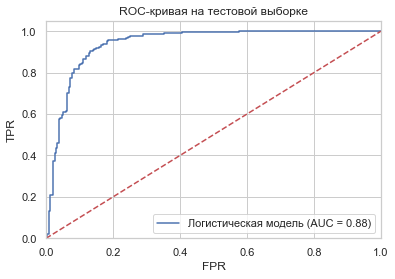

In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Логистическая модель (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на тестовой выборке')
plt.legend(loc="lower right")
plt.show()

На тестовой выборке AUC составляет 0.88. Проверим на обучающей выборке. Если они примерно равны, то то признак того, что модель хорошо обучена

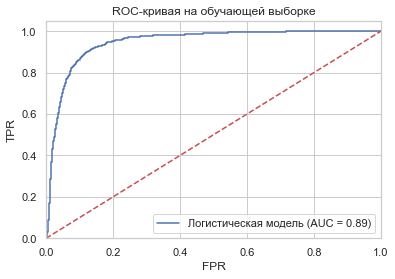

In [47]:
logit_roc_auc = roc_auc_score(y_train, logreg.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, logreg.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Логистическая модель (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на обучающей выборке')
plt.legend(loc="lower right")
plt.show()

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# проверяем на тестовых данных
X_test = pd.read_csv('my_X_test.csv')
y_test = pd.read_csv('my_y_test.csv').values.ravel()

Доля правильных ответов Accuracy= 0.8525021949078139
Мера F1= 0.8635100856284552
Точность Precision= 0.8804127240297507
Полнота Recall= 0.8525021949078139


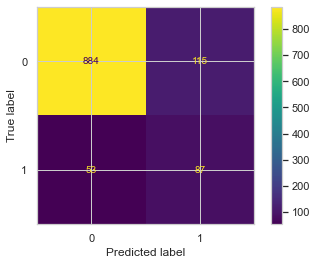

In [49]:
pred = logreg.predict(X_test)

# считаем метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred))
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)

ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)

Доля правильных ответов (классификационная точность) - 85.3% на тестовой выборке

На обучающей выборке AUC = 0.89. Формы ROC-кривых для обучающего и тестового набора также достаточно похожи. Это свидетельствует о том, что модель не переобучилась.

На основе значения AUC следует признать качество логистической модели классификации на тестовых данных как хорошее.

In [50]:
from sklearn import tree
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.1, random_state=0)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
# tree.plot_tree(clf) 

In [51]:
# import graphviz 
# dot_data = tree.export_graphviz(clf, out_file=None) 
# graph = graphviz.Source(dot_data) 
# graph.render('bb'

In [52]:
# from sklearn.tree import export_text # подключаем функцию
# r = export_text(clf, feature_names=X_train.columns.tolist()) # переводим дерево в текстовую строку
# print(r) # печатаем

## Разделяющая поверхность

In [53]:
import numpy as np #
import matplotlib.pyplot as plt #
from sklearn.tree import DecisionTreeClassifier, plot_tree #
import itertools

# # 10 задание_админ.
# # 11 рабочий
# # 12 предприниматель
# # 13 работа_домработница
# # 14 управление
# # 15 пенсионеров
# # 16 работа_самозанятый

# # 18 работа_студент
# # 19 техник
# # 20 безработных


# a = [3]# [i for i in range(10,21)]
# b = [18,19,20]
# pairs =list(itertools.product(a,b))
# # Parameters
# n_classes = 2 # число классов
# plot_colors = "gy" # цвета
# plot_step = 0.001 # шаг для симуляции на плоскости

# # Load data
# #iris = load_iris() # загружаем данные

# # в цикле по числу пар атрибутов 
# x = X_train.to_numpy()
# for pairidx, pair in enumerate(pairs):
    
#     print(pair)
    
#     X = x[:, pair] # Выбираем заданные пары атрибутов
#     y = y_train # метки

#     # Обучение
#     clf = DecisionTreeClassifier().fit(X, y) # обучаем дерево на текущей паре атрибутов

#     # Строим графики
#     plt.subplot(3, 3, pairidx + 1) # подграфик для текущей пары

#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # немного измененные минимальное и максимальые значения превого атрибута 
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # немного измененные минимальное и максимальые значения второго атрибута 
#     # считаем прямоугольную сетку возможных значений этих атрибутов
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), #
#                          np.arange(y_min, y_max, plot_step)) #
#     plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5) # более компактный график
    
#     # считаем выход классификатора для всех примеров сетки
#     # не забыв что массивы данных нужно привести к требуемому размеру.
#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 
#     Z = Z.reshape(xx.shape) # и преобразуем обратно к исходному размеру
#     cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu) # рисуем контурную карту
    
#     print(X)
#     plt.xlabel(X_train.columns.tolist()[pair[0]]) # добавляем подписи осей
#     plt.ylabel(X_train.columns.tolist()[pair[1]]) #
    
   

#     # Отображаем обучающие примеры своим цветом
#     for i, color in zip(range(n_classes), plot_colors): # в цикле по количеству классов
#         idx = np.where(y == i) # отбираем все точки текущего класса 
#         # отображаем их своим цветом
       
#         plt.scatter(X[idx, 0], X[idx, 1], c=color, label=[0,1][i], #
#                     cmap=plt.cm.RdYlBu, edgecolor='black', s=30) #

# plt.suptitle("Разделяющая поверхность, для каждой пары признаков") # подписываем график
# plt.legend(loc='best',bbox_to_anchor=(2, 0.)) # легенда
# plt.axis("tight"); # отображение осей

In [54]:
for i in range(len(X_train.columns)):
    print(i,X_train.columns[i])
[0,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

0 age
1 default
2 balance
3 housing
4 loan
5 day
6 duration
7 campaign
8 pdays
9 previous
10 job_admin.
11 job_blue-collar
12 job_entrepreneur
13 job_housemaid
14 job_management
15 job_retired
16 job_self-employed
17 job_services
18 job_student
19 job_technician
20 job_unemployed
21 education_primary
22 education_secondary
23 education_tertiary
24 marital_divorced
25 marital_married
26 marital_single
27 month_apr
28 month_aug
29 month_dec
30 month_feb
31 month_jan
32 month_jul
33 month_jun
34 month_mar
35 month_may
36 month_nov
37 month_oct
38 month_sep


[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [55]:
import itertools
a = [24,25,26]
b = [21,22,23]
pairs =list(itertools.product(a,b))
print(pairs)
len(pairs)

[(24, 21), (24, 22), (24, 23), (25, 21), (25, 22), (25, 23), (26, 21), (26, 22), (26, 23)]


9

In [56]:
# построим и отобразим дерево для всех 2 классов.
# plt.figure() #
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.1, random_state=0)

# clf = DecisionTreeClassifier().fit(X_train, y_train) #
# plot_tree(clf, filled=True) #
# plt.show() #

# Метод ближайших соседей (k Nearest Neighbors, или kNN)

In [57]:
data.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,30,0,1787.0,0,0,19,79,1,-1,0,...,0,0,0,0,0,0,0,0,1,0
1,33,0,4789.0,1,1,11,220,1,339,4,...,0,0,0,0,0,0,1,0,0,0
2,30,0,1476.0,1,1,3,199,4,-1,0,...,0,0,0,0,1,0,0,0,0,0
3,59,0,298.0,1,0,5,226,1,-1,0,...,0,0,0,0,0,0,1,0,0,0
4,36,0,37.0,1,0,14,341,1,330,2,...,0,0,0,0,0,0,1,0,0,0


In [58]:

X = data.loc[:, data.columns != 'y']
y = data.loc[:, data.columns == 'y']
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split # подключаем функцию для разделения данных

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y=os.fit_resample(X_train, y_train)

In [59]:
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
# Мы можем проверить числа наших данных
print("Объем восстановленной (oversampled) выборки: ",len(os_data_X))
print("Число не оформивших клиентов ",len(os_data_y[os_data_y['y']==0]))
print("Число оформивших клиентов ",len(os_data_y[os_data_y['y']==1]))
print("Доля не оформивших клиентов ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Доля оформивших клиентов ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

Объем восстановленной (oversampled) выборки:  4722
Число не оформивших клиентов  2361
Число оформивших клиентов  2361
Доля не оформивших клиентов  0.5
Доля оформивших клиентов  0.5


In [60]:
os_data_X.to_csv('my_os_data_X.csv', index=False)
os_data_y.to_csv('my_os_data_y.csv', index=False)
X_test.to_csv('my_X_test.csv', index=False)
y_test.to_csv('my_y_test.csv', index=False)

In [61]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

tree = DecisionTreeClassifier(max_depth=7, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(os_data_X, os_data_y.values.ravel())
knn.fit(os_data_X, os_data_y.values.ravel())

KNeighborsClassifier(n_neighbors=10)

Доля правильных ответов Accuracy= 0.8525021949078139
Мера F1= 0.8635100856284552
Точность Precision= 0.8804127240297507
Полнота Recall= 0.8525021949078139


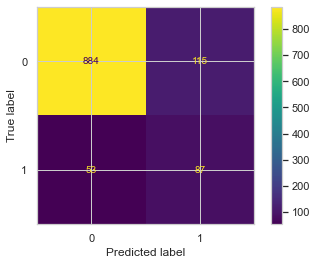

In [62]:
pred = logreg.predict(X_test)

# считаем метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred))
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)

ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)

In [63]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_test)
accuracy_score(y_test, tree_pred) 

0.8402107111501317

In [64]:
# построим и отобразим дерево для классов.
# plt.figure() #
# plot_tree(tree, filled=True) #
# plt.show() #

In [65]:
# from sklearn.tree import export_text # подключаем функцию
# r = export_text(tree, feature_names=list(X_test.columns.values)) # переводим дерево в текстовую строку
# print(r) # печатаем

In [66]:
knn_pred = knn.predict(X_test)
accuracy_score(y_test, knn_pred) # 0.78

C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.7848990342405618

#### Кросс-валидация

In [67]:
X_train.shape

(2655, 39)

In [68]:
from sklearn.model_selection import GridSearchCV, cross_val_score
tree_params = {'max_depth': range(1,11), 'max_features': range(4, 28)}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train) # ищем по обучающим данным, чтобы не было "утечки"

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=7, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 28)},
             verbose=True)

In [69]:
tree_grid.best_params_

{'max_depth': 3, 'max_features': 17}

In [70]:
tree_grid.best_score_

0.8960451977401129

Доля правильных ответов для дерева решений

In [71]:
accuracy_score(y_test, tree_grid.predict(X_test))

0.887620719929763

Матрица ошибок

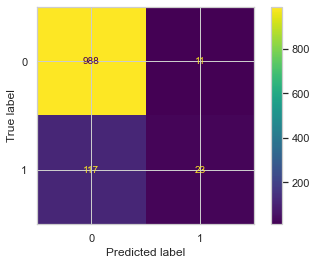

In [72]:
ConfusionMatrixDisplay.from_estimator(tree_grid, X_test, y_test)

Доля правильных ответов Accuracy= 0.887620719929763
Мера F1= 0.8562210964474399
Точность Precision= 0.8673655941744565
Полнота Recall= 0.887620719929763


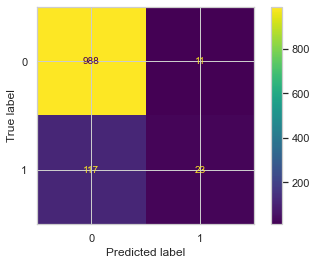

In [73]:
pred = tree_grid.predict(X_test)

# считаем метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred))
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)

ConfusionMatrixDisplay.from_estimator(tree_grid, X_test, y_test)

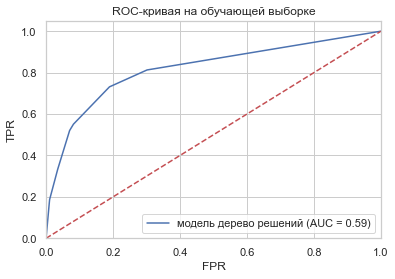

In [74]:
logit_roc_auc = roc_auc_score(y_train, tree_grid.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, tree_grid.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='модель дерево решений (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на обучающей выборке')
plt.legend(loc="lower right")
plt.show()

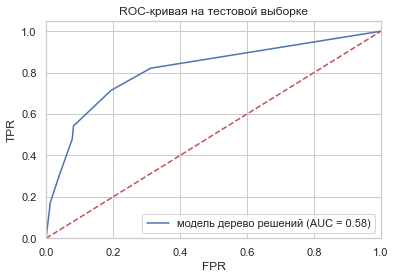

In [75]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, tree_grid.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree_grid.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='модель дерево решений (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на тестовой выборке')
plt.legend(loc="lower right")
plt.show()

#### Кросс-валидация для kNN

In [76]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 10)},
             verbose=True)

In [77]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 2}, 0.8896421845574387)

На тестовой выборке

In [78]:
accuracy_score(y_test, knn_grid.predict(X_test))

0.8779631255487269

Доля правильных ответов

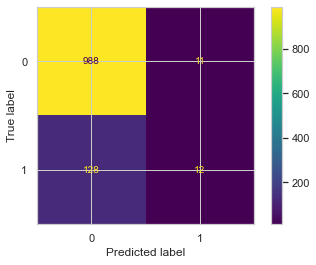

In [79]:
ConfusionMatrixDisplay.from_estimator(knn_grid, X_test, y_test)

#### Оценка качества модели kNN и ROC-кривая

Доля правильных ответов Accuracy= 0.8779631255487269
Мера F1= 0.8375401034096391
Точность Precision= 0.8406170615448457
Полнота Recall= 0.8779631255487269


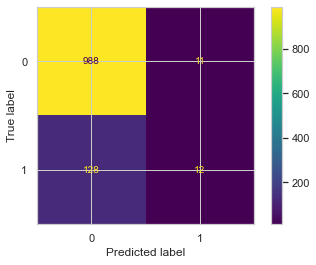

In [80]:
pred = knn_grid.predict(X_test)

# считаем метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred))
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)

ConfusionMatrixDisplay.from_estimator(knn_grid, X_test, y_test)

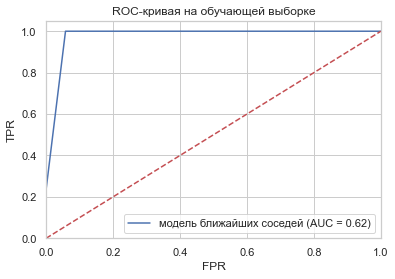

In [81]:
logit_roc_auc = roc_auc_score(y_train, knn_grid.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, knn_grid.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='модель ближайших соседей (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на обучающей выборке')
plt.legend(loc="lower right")
plt.show()

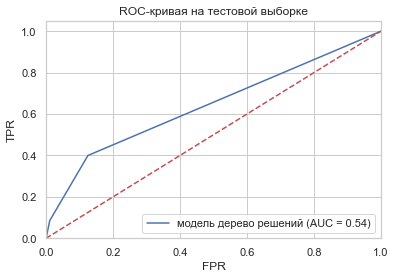

In [82]:
logit_roc_auc = roc_auc_score(y_test, knn_grid.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn_grid.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='модель дерево решений (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на тестовой выборке')
plt.legend(loc="lower right")
plt.show()

**Вывод:**

на данном наборе данных дерево решений дает лучшую долю правильных ответов, в сравнении с kNN, как на кросс-валидации, так и на тестовой выборке (89.6% против 87.8% для kNN), также он лучше линейной модели, где доля правильных ответов 85.3%

# Метод опорных векторов


In [84]:
from sklearn import svm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split # разделение на обучение и тест
from sklearn import metrics # метрики
from sklearn.preprocessing import MinMaxScaler
from sklearnex import patch_sklearn 
from time import time
# функции для расчета метрик
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [160]:
os_data_X = pd.read_csv('my_os_data_X.csv').values
os_data_y = pd.read_csv('my_os_data_y.csv').values.ravel()

In [161]:
C = 1.0  # = self._alpha in our algorithm
svm_lin1 = svm.SVC(kernel='linear', C=C,probability=True)
svm_lin2 = svm.LinearSVC(C=C, max_iter=10000)


In [162]:
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
os_data_X = scaler.fit_transform(os_data_X)

# разделим данные на обучающие и тестовые после нормирования
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=17)

In [163]:
patch_sklearn()

start = time()
svm_lin1.fit(X_train, y_train)
print("Linear SVC Kernel Normalized Fit Time: {} s".format(time() - start))

start = time()
svm_lin2.fit(X_train, y_train)
print("Linear LinearSVC Kernel Normalized Fit Time: {} s".format(time() - start))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Linear SVC Kernel Normalized Fit Time: 11.470225811004639 s
Linear LinearSVC Kernel Normalized Fit Time: 0.03125333786010742 s


In [164]:
pred = svm_lin1.predict(X_test)
print('Полнота для каждого класса на тестовой выборке')
print(recall_score(y_test, pred, average=None))
print('Точность для каждого класса на тестовой выборке')
print(precision_score(y_test, pred, average=None))
# average=None - означает, что score будет выводиться для каждого класса отдельно, а не усредняться

Полнота для каждого класса на тестовой выборке
[0.99444444 0.88235294]
Точность для каждого класса на тестовой выборке
[0.89724311 0.99353796]


Для класса LinearSVC

In [165]:
pred_lin2 = svm_lin2.predict(X_test)
print('Полнота для каждого класса на тестовой выборке')
print(recall_score(y_test, pred_lin2, average=None))
print('Точность для каждого класса на тестовой выборке')
print(precision_score(y_test, pred_lin2, average=None))
# average=None - означает, что score будет выводиться для каждого класса отдельно, а не усредняться

Полнота для каждого класса на тестовой выборке
[0.9875     0.89813486]
Точность для каждого класса на тестовой выборке
[0.90920716 0.98582677]


Множители (1, 39)
Смещения (1,)
Доля правильных ответов Accuracy= 0.9393083980239944
Мера F1= 0.9390690571257324
Точность Precision= 0.9446090323371714
Полнота Recall= 0.9393083980239944


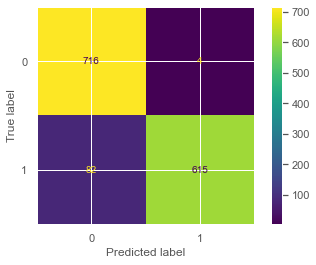

In [167]:
print('Множители', svm_lin1.coef_.shape)
print('Смещения', svm_lin1.intercept_.shape)
pred = svm_lin1.predict(X_test)# считаем классы для тестовых данных 

accuracy = accuracy_score(y_test, pred) # средняя точночть
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred)) 
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall = recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=', f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)
ConfusionMatrixDisplay.from_estimator(svm_lin1, X_test, y_test)

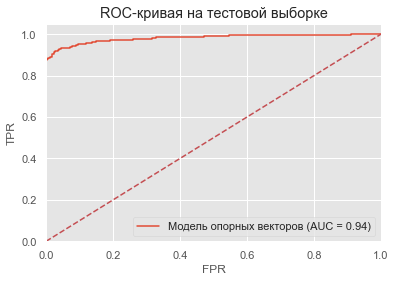

In [168]:
svm_lin1
logit_roc_auc = roc_auc_score(y_test, svm_lin1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, svm_lin1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Модель опорных векторов (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на тестовой выборке')
plt.legend(loc="lower right")
plt.show()

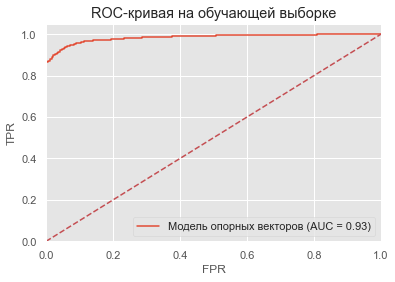

In [169]:
svm_lin1
logit_roc_auc = roc_auc_score(y_train, svm_lin1.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, svm_lin1.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Модель опорных векторов (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на обучающей выборке')
plt.legend(loc="lower right")
plt.show()

In [170]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       720
           1       0.99      0.88      0.93       697

    accuracy                           0.94      1417
   macro avg       0.95      0.94      0.94      1417
weighted avg       0.94      0.94      0.94      1417



In [171]:
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
os_data_X = scaler.fit_transform(os_data_X)


# разделим данные на обучающие и тестовые после нормирования
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=17)

In [152]:
svm_rbf = svm.SVC(kernel='rbf', gamma=0.7, C=C,probability=True)
svm_poly = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C,probability=True)

In [153]:
patch_sklearn()

start = time()
svm_rbf.fit(X_train, y_train)
print("SVC RBF kernel Kernel Normalized Fit Time: {} s".format(time() - start))

start = time()
svm_poly.fit(X_train, y_train)
print("SVC Poly Kernel Normalized Fit Time: {} s".format(time() - start))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


SVC RBF kernel Kernel Normalized Fit Time: 11.424731254577637 s
SVC Poly Kernel Normalized Fit Time: 2.7457056045532227 s


Для ядра RBF

Доля правильных ответов Accuracy= 0.9336626676076217
Мера F1= 0.9334466575068462
Точность Precision= 0.9378448199478827
Полнота Recall= 0.9336626676076217


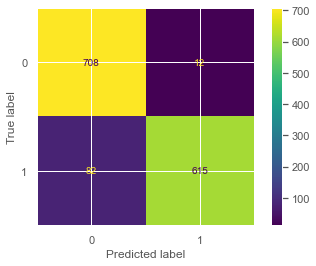

In [154]:
pred = svm_rbf.predict(X_test)# считаем классы для тестовых данных 
accuracy = accuracy_score(y_test, pred) # средняя точночть
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred)) # средняя f1 мера
# усредняем меру по классам с по всем объектам каждого класса
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)
ConfusionMatrixDisplay.from_estimator(svm_rbf, X_test, y_test)

**Сводный отчет**

In [155]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       720
           1       0.98      0.88      0.93       697

    accuracy                           0.93      1417
   macro avg       0.94      0.93      0.93      1417
weighted avg       0.94      0.93      0.93      1417



#### Для полиномиального ядра

Доля правильных ответов Accuracy= 0.49258997882851097
Мера F1= 0.3259180703439358
Точность Precision= 0.7502367339290057
Полнота Recall= 0.49258997882851097


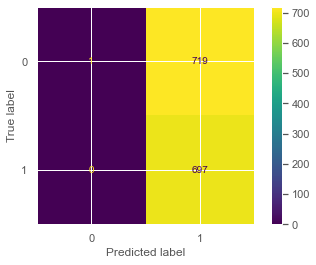

In [156]:
pred = svm_poly.predict(X_test)# считаем классы для тестовых данных 
accuracy = accuracy_score(y_test, pred) # средняя точночть
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred)) 
# усредняем меру по классам с по всем объектам каждого класса
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)
ConfusionMatrixDisplay.from_estimator(svm_poly, X_test, y_test)

In [172]:
# проверяем на тестовых данных
X_test = pd.read_csv('my_X_test.csv').values
y_test = pd.read_csv('my_y_test.csv').values.ravel()

Доля правильных ответов Accuracy= 0.23529411764705882
Мера F1= 0.23630443808713084
Точность Precision= 0.8502454338990459
Полнота Recall= 0.23529411764705882


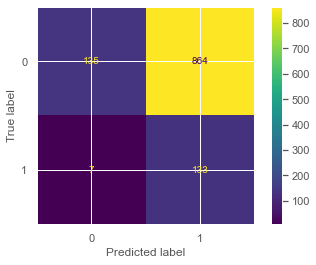

In [174]:
# svm_lin1 - модель SVM с линейным ядром
pred = svm_lin1.predict(X_test)
accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred))
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)

ConfusionMatrixDisplay.from_estimator(svm_lin1, X_test, y_test)




Как видим, метод SVM с линейным ядром переобучается и плохо предсказывает нашу модель. 

Для ядра RBF

Доля правильных ответов Accuracy= 0.8770851624231782
Мера F1= 0.9345182413470534
Точность Precision= 0.8770851624231782
Полнота Recall= 1.0


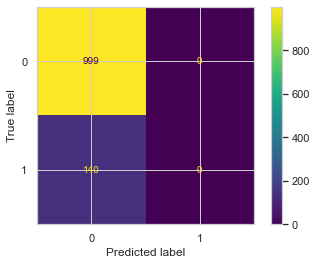

In [103]:
# svm_rbf - модель SVM с ядром RBF
pred = svm_rbf.predict(X_test)

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred))
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)

ConfusionMatrixDisplay.from_estimator(svm_rbf, X_test, y_test)

доля правильных ответов на отложенной выборке составляет около 87.70%

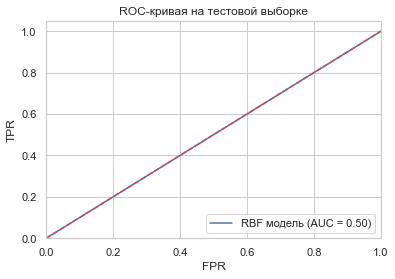

In [104]:
logit_roc_auc = roc_auc_score(y_test, svm_rbf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, svm_rbf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RBF модель (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на тестовой выборке')
plt.legend(loc="lower right")
plt.show()

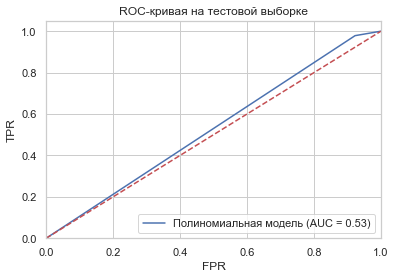

In [105]:

logit_roc_auc = roc_auc_score(y_test, svm_poly.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, svm_poly.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Полиномиальная модель (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на тестовой выборке')
plt.legend(loc="lower right")
plt.show()

На полинимиальном ядре результат не очень хороший, AUC = 0.53

**Вывод**

Среди различных типов функций ядра (kernel) наилучшее значение метрики accuracy - 87,70% было достигнуто для SVM на базе ядра RBF для кроссвалидационной выборки.

# Случайный лес

In [106]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification # для генерации данных
from sklearn.model_selection import train_test_split # для разделения на обучение и тест
from sklearn.ensemble import RandomForestClassifier # случайный лес

os_data_X = pd.read_csv('my_os_data_X.csv')
os_data_y = pd.read_csv('my_os_data_y.csv')
os_data_y = os_data_y.values.ravel()

In [107]:
# Инициализируем стратифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Инициализируем наш классификатор с дефолтными параметрами
rfc = RandomForestClassifier(random_state=17, n_jobs=-1, oob_score=True)

# Обучаем на тренировочном датасете
results = cross_val_score(rfc, os_data_X, os_data_y, cv=skf)

# Оцениваем долю верных ответов на тестовом датасете
print("Доля правильных ответов на кросс-валидации: {:.2f}%".format(results.mean()*100))

Доля правильных ответов на кросс-валидации: 94.90%


Доля правильных ответов на кросс-валидации с использованием алгоритма случайного леса при дефолтных (по умолчанию) значениях параметров - составляет 94.88%

In [108]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [20, 30, 50, 75, 100]

# Обучаем на обучающей
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=17, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    
    for train_index, test_index in skf.split(os_data_X, os_data_y):
        X_train, X_test = os_data_X.iloc[train_index], os_data_X.iloc[test_index]
        y_train, y_test = os_data_y[train_index], os_data_y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

In [109]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Наилучшая доля правильных ответов на кросс-валидации {:.2f}% достигается для {} деревьев".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Наилучшая доля правильных ответов на кросс-валидации 94.90% достигается для 100 деревьев


Text(0.5, 0, 'Число деревьев')

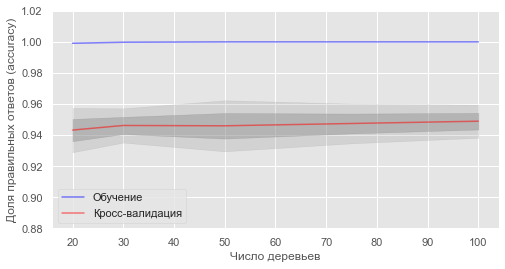

In [110]:
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='Обучение')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='Кросс-валидация')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Доля правильных ответов (accuracy)")
ax.set_xlabel("Число деревьев")

Как видно, при достижении определенного числа деревьев наша доля верных ответов на тесте выходит на асимптоту.

1. добавление параметра максимальной глубины – max_depth. 

In [111]:
# Создаем списки для сохранения accuracy на обучающей и тестовой выборке
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20]

# Обучаем
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=75, random_state=17, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(os_data_X, os_data_y):
        X_train, X_test = os_data_X.iloc[train_index], os_data_X.iloc[test_index]
        y_train, y_test = os_data_y[train_index], os_data_y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Наилучшая доля правильных ответов на кросс-валидации {:.2f}% достигается при глубине {} уровней".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Наилучшая доля правильных ответов на кросс-валидации 94.83% достигается при глубине 17 уровней


Text(0.5, 0, 'Максимальная глубина дерева')

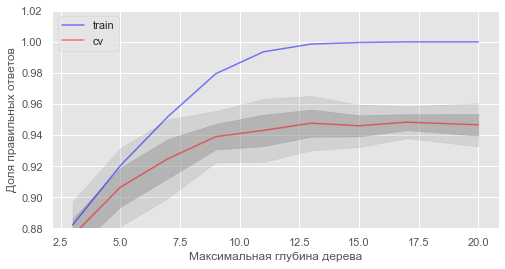

In [112]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Доля правильных ответов")
ax.set_xlabel("Максимальная глубина дерева")

Параметр max_depth хорошо справляется с регуляризацией модели, и мы уже не так сильно переобучаемся.

2. Параметр min_samples_leaf

In [113]:
# Создаем списки для сохранения accuracy на обучающей и тестовой выборках
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20]

# Обучаем 
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=75, random_state=17, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(os_data_X, os_data_y):
        X_train, X_test = os_data_X.iloc[train_index], os_data_X.iloc[test_index]
        y_train, y_test = os_data_y[train_index], os_data_y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Наилучшая доля правильных ответов на кросс-валидации {:.2f}% достигается при минимальном числе объектов в листе: {} ".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Наилучшая доля правильных ответов на кросс-валидации 94.75% достигается при минимальном числе объектов в листе: 1 


Text(0.5, 0, 'Минимальное число объектов в листе')

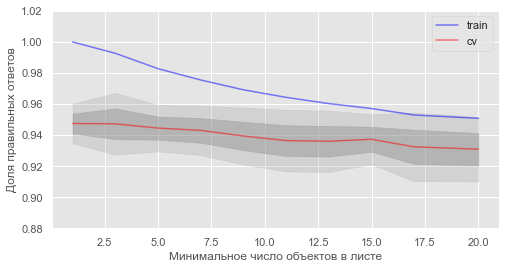

In [114]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Доля правильных ответов")
ax.set_xlabel("Минимальное число объектов в листе")

При увеличении минимального числа объектов в листе доля правильных ответов будет падать (наша метрика), но зато мы значительно снижаем уровень переобучения

3. Параметр max_features (число признаков из признакового пространства, которое учитывается для лучшего разбиения)

In [115]:
# Создаем списки для сохранения accuracy на обучающей и тестовой выборке
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Обучаем
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=75, random_state=17, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(os_data_X, os_data_y):
        X_train, X_test = os_data_X.iloc[train_index], os_data_X.iloc[test_index]
        y_train, y_test = os_data_y[train_index], os_data_y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Наилучшая доля правильных ответов на кросс-валидации {:.2f}% достигается при числе признаков: {}".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

Наилучшая доля правильных ответов на кросс-валидации 95.07% достигается при числе признаков: 8


Text(0.5, 0, 'Максимальное число признаков')

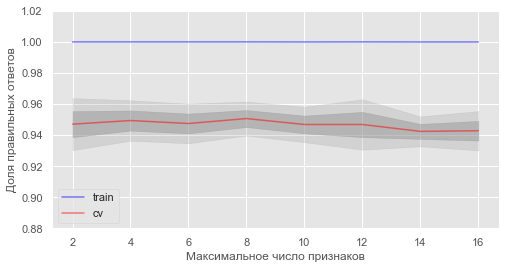

In [116]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Доля правильных ответов")
ax.set_xlabel("Максимальное число признаков")

Найдем оптимальные параметры для нашего набора данных

In [117]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [4, 6, 8, 10], 'min_samples_leaf': [1, 2, 3], 'max_depth': [15, 20, 24, 26]}
rfc = RandomForestClassifier(n_estimators=75, random_state=17, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(os_data_X, os_data_y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=75, n_jobs=-1,
                                              oob_score=True, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [15, 20, 24, 26],
                         'max_features': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 3]},
             verbose=1)

Сырые результаты поиска по сетке полным перебором

In [118]:
gcv.cv_results_

{'mean_fit_time': array([0.63890519, 0.61690655, 0.60298328, 0.62172909, 0.64047518,
        0.64047546, 0.65921707, 0.66546969, 0.66211648, 0.69602485,
        0.69671268, 0.66859422, 0.64047494, 0.63422675, 0.62797766,
        0.63109822, 0.6717186 , 0.64047523, 0.67171631, 0.67796693,
        0.66546869, 0.70920959, 0.68874102, 0.67936702, 0.63734951,
        0.61548362, 0.63110161, 0.65297241, 0.63110142, 0.63735065,
        0.6654685 , 0.65609622, 0.67796631, 0.70608511, 0.69984164,
        0.67171812, 0.62797832, 0.61860709, 0.61860332, 0.64359908,
        0.6279779 , 0.63110323, 0.67796559, 0.65297294, 0.64984813,
        0.70295987, 0.6904633 , 0.68421407]),
 'std_fit_time': array([0.01007424, 0.00754672, 0.01593024, 0.0182178 , 0.01397233,
        0.03422424, 0.02863159, 0.01874619, 0.03019116, 0.01216303,
        0.01593109, 0.02295922, 0.00988008, 0.00765333, 0.01530566,
        0.02723197, 0.00987986, 0.01711224, 0.01711293, 0.02118951,
        0.01874614, 0.02119087, 0.017

In [119]:
gcv.best_estimator_

RandomForestClassifier(max_depth=24, max_features=8, n_estimators=75, n_jobs=-1,
                       oob_score=True, random_state=17)

In [120]:
print('Наилучшие значения параметров: ')
print(gcv.best_params_)
print('Обеспечивают среднюю долю правильных ответов методом кросс-валидации, равную:')
print(gcv.best_score_)

Наилучшие значения параметров: 
{'max_depth': 24, 'max_features': 8, 'min_samples_leaf': 1}
Обеспечивают среднюю долю правильных ответов методом кросс-валидации, равную:
0.9506559949780289


### Оценка важности признаков


In [121]:
# Инициализируем стратифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

rfc = RandomForestClassifier(n_estimators=75, random_state=17, n_jobs=-1, 
                                 oob_score=True, max_features=6, max_depth=24, min_samples_leaf=1)

# Обучаем на обучающей выборке
rfc.fit(os_data_X, os_data_y)

# Оцениваем долю верных ответов на тестовом датасете
print("Доля правильных ответов на кросс-валидации: {:.2f}%".format(results.mean()*100))

Доля правильных ответов на кросс-валидации: 94.90%


Значения важности признаков по средним значениям уменьшениния неопределенности Джини

In [122]:
for name, importance in zip(os_data_X.columns.tolist(), rfc.feature_importances_):
    print(name, "=", importance)

age = 0.03495757149562902
default = 0.0007307513095726516
balance = 0.05583496697496898
housing = 0.06268476541727855
loan = 0.022821310992693456
day = 0.03850307168105462
duration = 0.2826444542367742
campaign = 0.021111853189388727
pdays = 0.04835646286633788
previous = 0.01657991681574118
job_admin. = 0.009053070315270558
job_blue-collar = 0.024418749946839638
job_entrepreneur = 0.003477157628090853
job_housemaid = 0.0016812198390026053
job_management = 0.011196138894324996
job_retired = 0.0033857814872621035
job_self-employed = 0.0037827302804832983
job_services = 0.008075031105363985
job_student = 0.0019662399350816088
job_technician = 0.01621667525063474
job_unemployed = 0.003366846370271308
education_primary = 0.017474347419358587
education_secondary = 0.02384759536517443
education_tertiary = 0.024400703139421612
marital_divorced = 0.01832443801396903
marital_married = 0.060577906664597725
marital_single = 0.02092366375284175
month_apr = 0.008859756572107328
month_aug = 0.021024

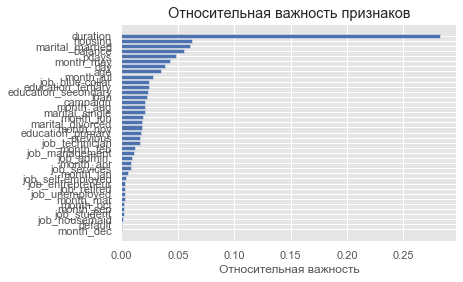

In [123]:
features = os_data_X.columns.tolist()
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Относительная важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Относительная важность')
plt.show()

Наиболее "информативные признаки" для выявления лояльности - это длительность звонков, семейное положение, баланс, месяц и некоторые другие.

### На тестовой выборке, заранее отложенной

Доля правильных ответов Accuracy= 0.8709394205443372
Мера F1= 0.8568941202699718
Точность Precision= 0.8494343218609486
Полнота Recall= 0.8709394205443372


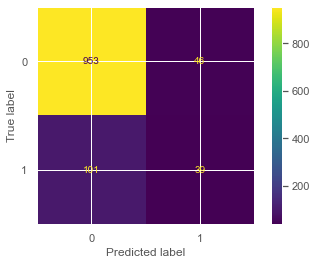

In [124]:
# проверяем на тестовых данных
X_test = pd.read_csv('my_X_test.csv')
y_test = pd.read_csv('my_y_test.csv')

pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred))
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)

ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test)

**Вывод:**
На отложенной выборке доля правильных ответов случайного леса составляет 87.1%

# Boosting

In [193]:
from sklearn.ensemble import AdaBoostClassifier # подключим модуль Adaboost
from sklearn import datasets # наборы данных
from sklearn.model_selection import train_test_split # разделение на обучение и тест
from sklearn import metrics # метрики
from sklearn.svm import SVC

os_data_X = pd.read_csv('my_os_data_X.csv')
os_data_y = pd.read_csv('my_os_data_y.csv').values.ravel()


In [194]:
# разделим данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=17)

# создадим Adaboost классификатор, по умолчанию - на основе деревьев, 50 деревьев, скорость обучения = 1
abc = AdaBoostClassifier(n_estimators=100, learning_rate=1)
# обучим его
model = abc.fit(X_train, y_train)
# проверим на тесте
y_pred = model.predict(X_test)
# посчитаем метрики
print("Доля правильных ответов (Accuracy):", metrics.accuracy_score(y_test, y_pred))

Доля правильных ответов (Accuracy): 0.9435426958362738


C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [195]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import tree # модуль для деревьев
# Инициализируем стратифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# базовый алгоритм для adaboost - деревья решений, 
# параметры возьмем наилучшими, которые определили ранее max_features=6, min_samples_leaf=1,
# а max_depth=1, глубокие деревья не нужны

Tree = tree.DecisionTreeClassifier(max_depth=1, max_features=6, min_samples_leaf=1)

ada = AdaBoostClassifier(base_estimator = Tree)

# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'n_estimators': [75, 100, 125], 'learning_rate': [0.5, 1, 1.5]}

adacv = GridSearchCV(ada, parameters, n_jobs=-1, cv=skf, verbose=1)
adacv.fit(os_data_X, os_data_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                max_features=6)),
             n_jobs=-1,
             param_grid={'learning_rate': [0.5, 1, 1.5],
                         'n_estimators': [75, 100, 125]},
             verbose=1)

Наилучшие параметры

In [128]:
adacv.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         max_features=6),
                   learning_rate=1, n_estimators=100)

Для adaboost: learning_rate=1, n_estimators=100.

In [129]:
print('Средняя доля правильных ответов по кросс-валидации для параметров: ')
print(adacv.best_params_)

Средняя доля правильных ответов по кросс-валидации для параметров: 
{'learning_rate': 1, 'n_estimators': 100}


In [130]:
print('Соответствует ранее определенной accuracy на тестовой выборке для adaboost со значениями параметров по умолчанию:')
print('learning_rate = ',adacv.best_score_)

Соответствует ранее определенной accuracy на тестовой выборке для adaboost со значениями параметров по умолчанию:
learning_rate =  0.937526455026455


Доля правильных ответов Accuracy= 0.8849868305531168
Мера F1= 0.8752415962125054
Точность Precision= 0.8704343129022337
Полнота Recall= 0.8849868305531168


C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


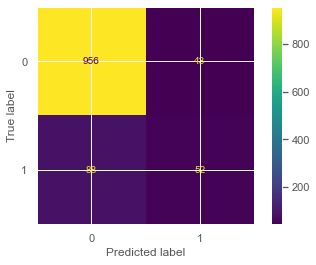

In [199]:
# проверяем на тестовых заранее отложенных данных
X_test = pd.read_csv('my_X_test.csv')
y_test = pd.read_csv('my_y_test.csv')

pred = adacv.predict(X_test)

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred))
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)
ConfusionMatrixDisplay.from_estimator(adacv, X_test, y_test)

C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


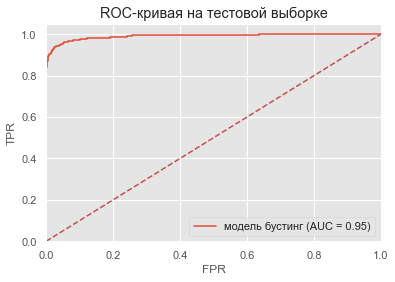

In [198]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, adacv.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, adacv.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='модель бустинг (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на тестовой выборке')
plt.legend(loc="lower right")
plt.show()

C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


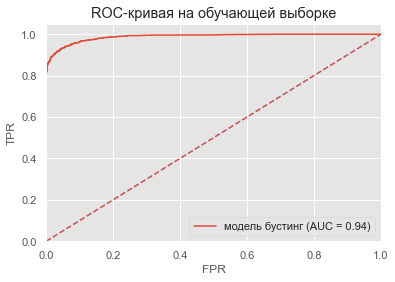

In [197]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_train, adacv.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, adacv.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='модель бустинг (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая на обучающей выборке')
plt.legend(loc="lower right")
plt.show()

## Градиентный бустинг. Xgboost

In [175]:
import xgboost # подключим библиотеку XGboost
from sklearn.metrics import accuracy_score #
from sklearn.model_selection import train_test_split #
os_data_X = pd.read_csv('my_os_data_X.csv')
os_data_y = pd.read_csv('my_os_data_y.csv')

In [176]:
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=17)

# обучаем градиентный бустинг деревьев (по умолчанию)
xgb = xgboost.XGBClassifier() # создаем объект
xgb.fit(X_train, y_train) # обучаем его

# вычисляем выход на тесте
predictions = xgb.predict(X_test) #

# считаем точность
accuracy = accuracy_score(y_test, predictions) #
print("Доля правильных ответов (Accuracy): %.2f%%" % (accuracy * 100.0))

Доля правильных ответов (Accuracy): 94.71%


In [177]:
from sklearn.model_selection import GridSearchCV
    
params = { 'learning_rate': [0.01, 0.05, 0.1, 0.2], # скорость обучения
           'colsample_bytree': [0.3, 0.7], # доля признаков (столбцов), случайным образом выбираемых в качестве потенциальных признаков для каждого нового дерева
           'subsample': [0.5, 0.7, 1], # доля примеров для выбора при построении каждого нового дерева
           'reg_alpha': [0, 1, 3], # параметр регуляризации L1
           'reg_lambda': [1, 3, 5]} # параметр регуляризации L2
xgb = xgboost.XGBClassifier(max_depth=6, n_estimators=75, seed = 17)

clf = GridSearchCV(estimator=xgb, 
                   param_grid=params,
                   scoring='accuracy', # метрика - доля правильных ответов
                   verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Highest accuracy: ", clf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 1}
Highest accuracy:  0.9485627836611196


Наилучшие значения параметров по сетке:

Best parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 1}

Наивысшая доля правильных ответов - 94.85%, что почти совпадает с xbm бустинг без подбора гиперпараметров (94.71%)

### Оценка качества моделей классификации


Доля правильных ответов Accuracy= 0.8700614574187884
Мера F1= 0.8616257258352846
Точность Precision= 0.8558519619099074
Полнота Recall= 0.8700614574187884


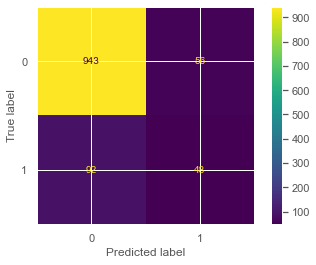

In [178]:
# проверяем на тестовых заранее отложенных данных
X_test = pd.read_csv('my_X_test.csv')
y_test = pd.read_csv('my_y_test.csv')

pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred))
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Доля правильных ответов составляет 87%, Доля правильных ответов случайном лесе на тестовой выборке обеспечил accuracy 87.7%

# Catboost

In [179]:
from catboost import CatBoostRegressor, Pool # регрессор

from sklearn.datasets import load_boston # данные
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance # для оценки важности признаков

os_data_X = pd.read_csv('my_os_data_X.csv').values
os_data_y = pd.read_csv('my_os_data_y.csv').values.ravel()
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.1, random_state=0)



In [180]:
train_dataset = Pool(X_train, y_train) # создаем пул обучающих данных
test_dataset = Pool(X_test, y_test) # создаем пул тестовых данных

In [181]:
model = CatBoostRegressor(loss_function='RMSE') # создаем модель для регрессии

In [182]:
# задаем "сетку" параметров, варианты, которые нужно проверить
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset) # и обучаем модели со всеми вариантами параметров, будет отобрана наилучшая

0:	learn: 0.6919009	test: 0.6972306	best: 0.6972306 (0)	total: 179ms	remaining: 17.7s
1:	learn: 0.6781647	test: 0.6834929	best: 0.6834929 (1)	total: 181ms	remaining: 8.85s
2:	learn: 0.6649510	test: 0.6702854	best: 0.6702854 (2)	total: 182ms	remaining: 5.89s
3:	learn: 0.6528278	test: 0.6583526	best: 0.6583526 (3)	total: 184ms	remaining: 4.41s
4:	learn: 0.6409693	test: 0.6465943	best: 0.6465943 (4)	total: 185ms	remaining: 3.52s
5:	learn: 0.6293103	test: 0.6351525	best: 0.6351525 (5)	total: 186ms	remaining: 2.92s
6:	learn: 0.6183881	test: 0.6241915	best: 0.6241915 (6)	total: 188ms	remaining: 2.49s
7:	learn: 0.6083540	test: 0.6142753	best: 0.6142753 (7)	total: 189ms	remaining: 2.17s
8:	learn: 0.5981448	test: 0.6042283	best: 0.6042283 (8)	total: 190ms	remaining: 1.92s
9:	learn: 0.5881803	test: 0.5944901	best: 0.5944901 (9)	total: 191ms	remaining: 1.72s
10:	learn: 0.5784698	test: 0.5848212	best: 0.5848212 (10)	total: 192ms	remaining: 1.56s
11:	learn: 0.5698405	test: 0.5763797	best: 0.5763797

10:	learn: 0.4246727	test: 0.4337204	best: 0.4337204 (10)	total: 14.5ms	remaining: 117ms
11:	learn: 0.4142665	test: 0.4235936	best: 0.4235936 (11)	total: 16ms	remaining: 118ms
12:	learn: 0.4053587	test: 0.4147425	best: 0.4147425 (12)	total: 17.8ms	remaining: 119ms
13:	learn: 0.3990278	test: 0.4084277	best: 0.4084277 (13)	total: 19.5ms	remaining: 120ms
14:	learn: 0.3906809	test: 0.4005224	best: 0.4005224 (14)	total: 21.2ms	remaining: 120ms
15:	learn: 0.3848244	test: 0.3952446	best: 0.3952446 (15)	total: 22.9ms	remaining: 120ms
16:	learn: 0.3781594	test: 0.3894519	best: 0.3894519 (16)	total: 24.6ms	remaining: 120ms
17:	learn: 0.3725172	test: 0.3847808	best: 0.3847808 (17)	total: 26.6ms	remaining: 121ms
18:	learn: 0.3681179	test: 0.3804611	best: 0.3804611 (18)	total: 28.3ms	remaining: 120ms
19:	learn: 0.3645269	test: 0.3766479	best: 0.3766479 (19)	total: 30ms	remaining: 120ms
20:	learn: 0.3609200	test: 0.3730027	best: 0.3730027 (20)	total: 31.6ms	remaining: 119ms
21:	learn: 0.3570958	test

17:	learn: 0.5231196	test: 0.5302508	best: 0.5302508 (17)	total: 23.4ms	remaining: 107ms
18:	learn: 0.5162461	test: 0.5236241	best: 0.5236241 (18)	total: 26.3ms	remaining: 112ms
19:	learn: 0.5097748	test: 0.5169797	best: 0.5169797 (19)	total: 27.6ms	remaining: 110ms
20:	learn: 0.5036099	test: 0.5107535	best: 0.5107535 (20)	total: 29ms	remaining: 109ms
21:	learn: 0.4978509	test: 0.5049943	best: 0.5049943 (21)	total: 30.6ms	remaining: 108ms
22:	learn: 0.4923539	test: 0.4995518	best: 0.4995518 (22)	total: 31.8ms	remaining: 107ms
23:	learn: 0.4870351	test: 0.4943527	best: 0.4943527 (23)	total: 33.1ms	remaining: 105ms
24:	learn: 0.4813540	test: 0.4888013	best: 0.4888013 (24)	total: 34.4ms	remaining: 103ms
25:	learn: 0.4755318	test: 0.4832336	best: 0.4832336 (25)	total: 35.7ms	remaining: 102ms
26:	learn: 0.4702516	test: 0.4780482	best: 0.4780482 (26)	total: 36.9ms	remaining: 99.9ms
27:	learn: 0.4651567	test: 0.4731202	best: 0.4731202 (27)	total: 38.2ms	remaining: 98.2ms
28:	learn: 0.4602609	

19:	learn: 0.5098355	test: 0.5170390	best: 0.5170390 (19)	total: 26.3ms	remaining: 105ms
20:	learn: 0.5036756	test: 0.5108174	best: 0.5108174 (20)	total: 28ms	remaining: 105ms
21:	learn: 0.4979154	test: 0.5050569	best: 0.5050569 (21)	total: 29.3ms	remaining: 104ms
22:	learn: 0.4924172	test: 0.4996131	best: 0.4996131 (22)	total: 30.5ms	remaining: 102ms
23:	learn: 0.4871013	test: 0.4944169	best: 0.4944169 (23)	total: 31.9ms	remaining: 101ms
24:	learn: 0.4814203	test: 0.4888655	best: 0.4888655 (24)	total: 33.1ms	remaining: 99.4ms
25:	learn: 0.4756003	test: 0.4832996	best: 0.4832996 (25)	total: 34.4ms	remaining: 97.8ms
26:	learn: 0.4703194	test: 0.4781135	best: 0.4781135 (26)	total: 35.6ms	remaining: 96.2ms
27:	learn: 0.4652270	test: 0.4731874	best: 0.4731874 (27)	total: 36.8ms	remaining: 94.5ms
28:	learn: 0.4603323	test: 0.4683840	best: 0.4683840 (28)	total: 38ms	remaining: 93ms
29:	learn: 0.4553968	test: 0.4637396	best: 0.4637396 (29)	total: 39.3ms	remaining: 91.6ms
30:	learn: 0.4510382	

32:	learn: 0.3292229	test: 0.3452754	best: 0.3452754 (32)	total: 43.6ms	remaining: 88.6ms
33:	learn: 0.3270844	test: 0.3432780	best: 0.3432780 (33)	total: 45.4ms	remaining: 88.1ms
34:	learn: 0.3253109	test: 0.3415167	best: 0.3415167 (34)	total: 46.8ms	remaining: 86.8ms
35:	learn: 0.3239803	test: 0.3402452	best: 0.3402452 (35)	total: 48ms	remaining: 85.3ms
36:	learn: 0.3226137	test: 0.3386607	best: 0.3386607 (36)	total: 49.2ms	remaining: 83.7ms
37:	learn: 0.3209267	test: 0.3370997	best: 0.3370997 (37)	total: 50.4ms	remaining: 82.2ms
38:	learn: 0.3195192	test: 0.3355652	best: 0.3355652 (38)	total: 51.7ms	remaining: 80.8ms
39:	learn: 0.3180988	test: 0.3339670	best: 0.3339670 (39)	total: 53ms	remaining: 79.4ms
40:	learn: 0.3171356	test: 0.3330680	best: 0.3330680 (40)	total: 54.3ms	remaining: 78.2ms
41:	learn: 0.3156583	test: 0.3317132	best: 0.3317132 (41)	total: 55.6ms	remaining: 76.8ms
42:	learn: 0.3132078	test: 0.3298822	best: 0.3298822 (42)	total: 56.9ms	remaining: 75.4ms
43:	learn: 0.3

35:	learn: 0.4315091	test: 0.4407985	best: 0.4407985 (35)	total: 49.8ms	remaining: 88.5ms
36:	learn: 0.4280327	test: 0.4375433	best: 0.4375433 (36)	total: 51.4ms	remaining: 87.6ms
37:	learn: 0.4244133	test: 0.4340844	best: 0.4340844 (37)	total: 52.8ms	remaining: 86.1ms
38:	learn: 0.4213532	test: 0.4311518	best: 0.4311518 (38)	total: 54.1ms	remaining: 84.6ms
39:	learn: 0.4180266	test: 0.4279801	best: 0.4279801 (39)	total: 55.5ms	remaining: 83.3ms
40:	learn: 0.4151430	test: 0.4252676	best: 0.4252676 (40)	total: 56.9ms	remaining: 81.8ms
41:	learn: 0.4123725	test: 0.4226680	best: 0.4226680 (41)	total: 58.1ms	remaining: 80.2ms
42:	learn: 0.4094269	test: 0.4199605	best: 0.4199605 (42)	total: 59.4ms	remaining: 78.8ms
43:	learn: 0.4065720	test: 0.4172594	best: 0.4172594 (43)	total: 60.8ms	remaining: 77.4ms
44:	learn: 0.4040083	test: 0.4146684	best: 0.4146684 (44)	total: 62.1ms	remaining: 75.9ms
45:	learn: 0.4015519	test: 0.4124283	best: 0.4124283 (45)	total: 63.4ms	remaining: 74.5ms
46:	learn:

57:	learn: 0.2963678	test: 0.3140656	best: 0.3140656 (57)	total: 71.9ms	remaining: 52.1ms
58:	learn: 0.2955345	test: 0.3131406	best: 0.3131406 (58)	total: 73.6ms	remaining: 51.1ms
59:	learn: 0.2945548	test: 0.3122595	best: 0.3122595 (59)	total: 75ms	remaining: 50ms
60:	learn: 0.2939138	test: 0.3116636	best: 0.3116636 (60)	total: 76.3ms	remaining: 48.8ms
61:	learn: 0.2933854	test: 0.3112063	best: 0.3112063 (61)	total: 77.5ms	remaining: 47.5ms
62:	learn: 0.2920954	test: 0.3103417	best: 0.3103417 (62)	total: 78.7ms	remaining: 46.2ms
63:	learn: 0.2912446	test: 0.3094306	best: 0.3094306 (63)	total: 80ms	remaining: 45ms
64:	learn: 0.2906342	test: 0.3089983	best: 0.3089983 (64)	total: 81.3ms	remaining: 43.8ms
65:	learn: 0.2899075	test: 0.3079136	best: 0.3079136 (65)	total: 82.6ms	remaining: 42.5ms
66:	learn: 0.2891968	test: 0.3071662	best: 0.3071662 (66)	total: 84.3ms	remaining: 41.5ms
67:	learn: 0.2884129	test: 0.3068682	best: 0.3068682 (67)	total: 86ms	remaining: 40.5ms
68:	learn: 0.2878413

68:	learn: 0.3612663	test: 0.3741444	best: 0.3741444 (68)	total: 88.7ms	remaining: 104ms
69:	learn: 0.3602170	test: 0.3730454	best: 0.3730454 (69)	total: 90.5ms	remaining: 103ms
70:	learn: 0.3590913	test: 0.3719736	best: 0.3719736 (70)	total: 91.9ms	remaining: 102ms
71:	learn: 0.3582928	test: 0.3710496	best: 0.3710496 (71)	total: 93.2ms	remaining: 101ms
72:	learn: 0.3572532	test: 0.3699841	best: 0.3699841 (72)	total: 94.4ms	remaining: 99.6ms
73:	learn: 0.3561020	test: 0.3689814	best: 0.3689814 (73)	total: 95.7ms	remaining: 98.3ms
74:	learn: 0.3550098	test: 0.3679271	best: 0.3679271 (74)	total: 96.9ms	remaining: 96.9ms
75:	learn: 0.3541359	test: 0.3670423	best: 0.3670423 (75)	total: 98.3ms	remaining: 95.7ms
76:	learn: 0.3530307	test: 0.3660410	best: 0.3660410 (76)	total: 99.7ms	remaining: 94.5ms
77:	learn: 0.3519934	test: 0.3651996	best: 0.3651996 (77)	total: 101ms	remaining: 93.6ms
78:	learn: 0.3507764	test: 0.3640591	best: 0.3640591 (78)	total: 103ms	remaining: 92.7ms
79:	learn: 0.349

38:	learn: 0.3192147	test: 0.3347903	best: 0.3347903 (38)	total: 48.5ms	remaining: 138ms
39:	learn: 0.3177977	test: 0.3332034	best: 0.3332034 (39)	total: 50.2ms	remaining: 138ms
40:	learn: 0.3168533	test: 0.3323226	best: 0.3323226 (40)	total: 51.5ms	remaining: 137ms
41:	learn: 0.3153560	test: 0.3309462	best: 0.3309462 (41)	total: 52.9ms	remaining: 136ms
42:	learn: 0.3129329	test: 0.3291470	best: 0.3291470 (42)	total: 54.1ms	remaining: 135ms
43:	learn: 0.3109563	test: 0.3277320	best: 0.3277320 (43)	total: 55.4ms	remaining: 133ms
44:	learn: 0.3096344	test: 0.3262654	best: 0.3262654 (44)	total: 56.6ms	remaining: 132ms
45:	learn: 0.3082462	test: 0.3250768	best: 0.3250768 (45)	total: 57.9ms	remaining: 131ms
46:	learn: 0.3068420	test: 0.3241657	best: 0.3241657 (46)	total: 59.2ms	remaining: 130ms
47:	learn: 0.3057326	test: 0.3230140	best: 0.3230140 (47)	total: 60.5ms	remaining: 129ms
48:	learn: 0.3048105	test: 0.3220390	best: 0.3220390 (48)	total: 61.8ms	remaining: 127ms
49:	learn: 0.3035416	

7:	learn: 0.6083783	test: 0.6142996	best: 0.6142996 (7)	total: 10.2ms	remaining: 182ms
8:	learn: 0.5981698	test: 0.6042532	best: 0.6042532 (8)	total: 12ms	remaining: 188ms
9:	learn: 0.5882069	test: 0.5945167	best: 0.5945167 (9)	total: 13.3ms	remaining: 187ms
10:	learn: 0.5784980	test: 0.5848493	best: 0.5848493 (10)	total: 14.6ms	remaining: 184ms
11:	learn: 0.5698702	test: 0.5764092	best: 0.5764092 (11)	total: 15.7ms	remaining: 181ms
12:	learn: 0.5611848	test: 0.5677126	best: 0.5677126 (12)	total: 17ms	remaining: 179ms
13:	learn: 0.5535256	test: 0.5601115	best: 0.5601115 (13)	total: 18.1ms	remaining: 176ms
14:	learn: 0.5457261	test: 0.5523186	best: 0.5523186 (14)	total: 19.4ms	remaining: 174ms
15:	learn: 0.5382089	test: 0.5449680	best: 0.5449680 (15)	total: 20.7ms	remaining: 173ms
16:	learn: 0.5304124	test: 0.5373582	best: 0.5373582 (16)	total: 22ms	remaining: 172ms
17:	learn: 0.5231196	test: 0.5302508	best: 0.5302508 (17)	total: 23.3ms	remaining: 171ms
18:	learn: 0.5162461	test: 0.5236

123:	learn: 0.3211809	test: 0.3374844	best: 0.3374844 (123)	total: 162ms	remaining: 34ms
124:	learn: 0.3208192	test: 0.3369922	best: 0.3369922 (124)	total: 163ms	remaining: 32.7ms
125:	learn: 0.3205124	test: 0.3365743	best: 0.3365743 (125)	total: 165ms	remaining: 31.4ms
126:	learn: 0.3197226	test: 0.3359790	best: 0.3359790 (126)	total: 166ms	remaining: 30.1ms
127:	learn: 0.3193056	test: 0.3354709	best: 0.3354709 (127)	total: 167ms	remaining: 28.8ms
128:	learn: 0.3186994	test: 0.3349374	best: 0.3349374 (128)	total: 169ms	remaining: 27.5ms
129:	learn: 0.3182135	test: 0.3344940	best: 0.3344940 (129)	total: 170ms	remaining: 26.1ms
130:	learn: 0.3178115	test: 0.3341245	best: 0.3341245 (130)	total: 171ms	remaining: 24.8ms
131:	learn: 0.3174421	test: 0.3338228	best: 0.3338228 (131)	total: 173ms	remaining: 23.5ms
132:	learn: 0.3171413	test: 0.3334913	best: 0.3334913 (132)	total: 174ms	remaining: 22.3ms
133:	learn: 0.3166409	test: 0.3329942	best: 0.3329942 (133)	total: 175ms	remaining: 20.9ms
1

88:	learn: 0.2754978	test: 0.2953503	best: 0.2953503 (88)	total: 116ms	remaining: 79.7ms
89:	learn: 0.2750307	test: 0.2949548	best: 0.2949548 (89)	total: 118ms	remaining: 78.9ms
90:	learn: 0.2745485	test: 0.2945287	best: 0.2945287 (90)	total: 120ms	remaining: 77.6ms
91:	learn: 0.2741347	test: 0.2941124	best: 0.2941124 (91)	total: 121ms	remaining: 76.3ms
92:	learn: 0.2737269	test: 0.2936565	best: 0.2936565 (92)	total: 122ms	remaining: 74.9ms
93:	learn: 0.2732755	test: 0.2930152	best: 0.2930152 (93)	total: 124ms	remaining: 73.6ms
94:	learn: 0.2728179	test: 0.2926070	best: 0.2926070 (94)	total: 125ms	remaining: 72.3ms
95:	learn: 0.2723905	test: 0.2923179	best: 0.2923179 (95)	total: 126ms	remaining: 70.9ms
96:	learn: 0.2720136	test: 0.2920937	best: 0.2920937 (96)	total: 128ms	remaining: 69.7ms
97:	learn: 0.2714434	test: 0.2916003	best: 0.2916003 (97)	total: 129ms	remaining: 68.4ms
98:	learn: 0.2707967	test: 0.2913275	best: 0.2913275 (98)	total: 130ms	remaining: 67.1ms
99:	learn: 0.2703820	

62:	learn: 0.3703140	test: 0.3825303	best: 0.3825303 (62)	total: 81.3ms	remaining: 112ms
63:	learn: 0.3690845	test: 0.3814471	best: 0.3814471 (63)	total: 83ms	remaining: 112ms
64:	learn: 0.3677471	test: 0.3801512	best: 0.3801512 (64)	total: 84.5ms	remaining: 110ms
65:	learn: 0.3662971	test: 0.3787014	best: 0.3787014 (65)	total: 85.8ms	remaining: 109ms
66:	learn: 0.3648839	test: 0.3775741	best: 0.3775741 (66)	total: 87ms	remaining: 108ms
67:	learn: 0.3636124	test: 0.3763801	best: 0.3763801 (67)	total: 88.2ms	remaining: 106ms
68:	learn: 0.3621792	test: 0.3750738	best: 0.3750738 (68)	total: 89.5ms	remaining: 105ms
69:	learn: 0.3611287	test: 0.3739735	best: 0.3739735 (69)	total: 90.8ms	remaining: 104ms
70:	learn: 0.3600012	test: 0.3729028	best: 0.3729028 (70)	total: 92.2ms	remaining: 103ms
71:	learn: 0.3592222	test: 0.3720012	best: 0.3720012 (71)	total: 93.5ms	remaining: 101ms
72:	learn: 0.3582041	test: 0.3709568	best: 0.3709568 (72)	total: 94.8ms	remaining: 100ms
73:	learn: 0.3570385	test

26:	learn: 0.3434797	test: 0.3578593	best: 0.3578593 (26)	total: 36.1ms	remaining: 164ms
27:	learn: 0.3411854	test: 0.3555161	best: 0.3555161 (27)	total: 38.1ms	remaining: 166ms
28:	learn: 0.3393363	test: 0.3541607	best: 0.3541607 (28)	total: 39.5ms	remaining: 165ms
29:	learn: 0.3356232	test: 0.3511894	best: 0.3511894 (29)	total: 40.8ms	remaining: 163ms
30:	learn: 0.3334304	test: 0.3488967	best: 0.3488967 (30)	total: 42.1ms	remaining: 162ms
31:	learn: 0.3306571	test: 0.3463777	best: 0.3463777 (31)	total: 43.3ms	remaining: 160ms
32:	learn: 0.3292229	test: 0.3452754	best: 0.3452754 (32)	total: 44.7ms	remaining: 158ms
33:	learn: 0.3270844	test: 0.3432780	best: 0.3432780 (33)	total: 45.9ms	remaining: 157ms
34:	learn: 0.3253109	test: 0.3415167	best: 0.3415167 (34)	total: 47.3ms	remaining: 155ms
35:	learn: 0.3239803	test: 0.3402452	best: 0.3402452 (35)	total: 48.7ms	remaining: 154ms
36:	learn: 0.3226137	test: 0.3386607	best: 0.3386607 (36)	total: 49.9ms	remaining: 153ms
37:	learn: 0.3209267	

141:	learn: 0.2537416	test: 0.2782100	best: 0.2782100 (141)	total: 190ms	remaining: 10.7ms
142:	learn: 0.2534619	test: 0.2778676	best: 0.2778676 (142)	total: 192ms	remaining: 9.4ms
143:	learn: 0.2531513	test: 0.2775647	best: 0.2775647 (143)	total: 193ms	remaining: 8.06ms
144:	learn: 0.2528705	test: 0.2772235	best: 0.2772235 (144)	total: 195ms	remaining: 6.71ms
145:	learn: 0.2526283	test: 0.2770943	best: 0.2770943 (145)	total: 196ms	remaining: 5.37ms
146:	learn: 0.2523710	test: 0.2767751	best: 0.2767751 (146)	total: 197ms	remaining: 4.02ms
147:	learn: 0.2520214	test: 0.2765582	best: 0.2765582 (147)	total: 198ms	remaining: 2.68ms
148:	learn: 0.2517554	test: 0.2761700	best: 0.2761700 (148)	total: 200ms	remaining: 1.34ms
149:	learn: 0.2513720	test: 0.2761050	best: 0.2761050 (149)	total: 201ms	remaining: 0us

bestTest = 0.2761050495
bestIteration = 149

13:	loss: 0.2761050	best: 0.2754285 (9)	total: 3.05s	remaining: 17.9s
0:	learn: 0.6919289	test: 0.6972578	best: 0.6972578 (0)	total: 1.32ms

103:	learn: 0.3318541	test: 0.3473360	best: 0.3473360 (103)	total: 142ms	remaining: 62.7ms
104:	learn: 0.3313757	test: 0.3469322	best: 0.3469322 (104)	total: 143ms	remaining: 61.4ms
105:	learn: 0.3308581	test: 0.3464112	best: 0.3464112 (105)	total: 144ms	remaining: 60ms
106:	learn: 0.3303877	test: 0.3457948	best: 0.3457948 (106)	total: 146ms	remaining: 58.5ms
107:	learn: 0.3297759	test: 0.3452175	best: 0.3452175 (107)	total: 147ms	remaining: 57.1ms
108:	learn: 0.3290112	test: 0.3445346	best: 0.3445346 (108)	total: 148ms	remaining: 55.7ms
109:	learn: 0.3285675	test: 0.3439541	best: 0.3439541 (109)	total: 149ms	remaining: 54.3ms
110:	learn: 0.3281134	test: 0.3436363	best: 0.3436363 (110)	total: 151ms	remaining: 53ms
111:	learn: 0.3275232	test: 0.3430756	best: 0.3430756 (111)	total: 152ms	remaining: 51.7ms
112:	learn: 0.3271033	test: 0.3426318	best: 0.3426318 (112)	total: 154ms	remaining: 50.3ms
113:	learn: 0.3264400	test: 0.3420326	best: 0.3420326 (113)	total: 155ms	remaining: 49ms
114:	

77:	learn: 0.2823368	test: 0.3011078	best: 0.3011078 (77)	total: 101ms	remaining: 92.9ms
78:	learn: 0.2818352	test: 0.3005461	best: 0.3005461 (78)	total: 103ms	remaining: 92.4ms
79:	learn: 0.2812799	test: 0.2999094	best: 0.2999094 (79)	total: 104ms	remaining: 91.2ms
80:	learn: 0.2806048	test: 0.2996027	best: 0.2996027 (80)	total: 105ms	remaining: 89.8ms
81:	learn: 0.2799784	test: 0.2991609	best: 0.2991609 (81)	total: 107ms	remaining: 88.5ms
82:	learn: 0.2793093	test: 0.2988113	best: 0.2988113 (82)	total: 108ms	remaining: 87.1ms
83:	learn: 0.2787660	test: 0.2983947	best: 0.2983947 (83)	total: 109ms	remaining: 85.7ms
84:	learn: 0.2782444	test: 0.2980077	best: 0.2980077 (84)	total: 110ms	remaining: 84.4ms
85:	learn: 0.2776401	test: 0.2973489	best: 0.2973489 (85)	total: 112ms	remaining: 83.2ms
86:	learn: 0.2771175	test: 0.2968671	best: 0.2968671 (86)	total: 113ms	remaining: 82.1ms
87:	learn: 0.2766383	test: 0.2964383	best: 0.2964383 (87)	total: 115ms	remaining: 80.8ms
88:	learn: 0.2761287	

40:	learn: 0.4152847	test: 0.4254441	best: 0.4254441 (40)	total: 54.6ms	remaining: 212ms
41:	learn: 0.4125033	test: 0.4228330	best: 0.4228330 (41)	total: 56.5ms	remaining: 212ms
42:	learn: 0.4095567	test: 0.4201257	best: 0.4201257 (42)	total: 57.8ms	remaining: 211ms
43:	learn: 0.4067037	test: 0.4174250	best: 0.4174250 (43)	total: 59.1ms	remaining: 209ms
44:	learn: 0.4041116	test: 0.4148063	best: 0.4148063 (44)	total: 60.3ms	remaining: 208ms
45:	learn: 0.4016711	test: 0.4123509	best: 0.4123509 (45)	total: 61.6ms	remaining: 206ms
46:	learn: 0.3993057	test: 0.4098981	best: 0.4098981 (46)	total: 63.1ms	remaining: 205ms
47:	learn: 0.3970682	test: 0.4078544	best: 0.4078544 (47)	total: 64.4ms	remaining: 204ms
48:	learn: 0.3946584	test: 0.4055349	best: 0.4055349 (48)	total: 65.9ms	remaining: 203ms
49:	learn: 0.3925660	test: 0.4035977	best: 0.4035977 (49)	total: 67.2ms	remaining: 202ms
50:	learn: 0.3907393	test: 0.4017071	best: 0.4017071 (50)	total: 68.5ms	remaining: 200ms
51:	learn: 0.3886094	

156:	learn: 0.3063351	test: 0.3230148	best: 0.3230148 (156)	total: 208ms	remaining: 57ms
157:	learn: 0.3057663	test: 0.3226038	best: 0.3226038 (157)	total: 210ms	remaining: 55.8ms
158:	learn: 0.3054285	test: 0.3223333	best: 0.3223333 (158)	total: 211ms	remaining: 54.5ms
159:	learn: 0.3051048	test: 0.3219714	best: 0.3219714 (159)	total: 213ms	remaining: 53.1ms
160:	learn: 0.3047491	test: 0.3216189	best: 0.3216189 (160)	total: 214ms	remaining: 51.8ms
161:	learn: 0.3044144	test: 0.3213443	best: 0.3213443 (161)	total: 215ms	remaining: 50.4ms
162:	learn: 0.3040303	test: 0.3210001	best: 0.3210001 (162)	total: 216ms	remaining: 49.1ms
163:	learn: 0.3037680	test: 0.3208584	best: 0.3208584 (163)	total: 218ms	remaining: 47.8ms
164:	learn: 0.3034341	test: 0.3204805	best: 0.3204805 (164)	total: 219ms	remaining: 46.5ms
165:	learn: 0.3030833	test: 0.3201883	best: 0.3201883 (165)	total: 220ms	remaining: 45.1ms
166:	learn: 0.3027678	test: 0.3198603	best: 0.3198603 (166)	total: 222ms	remaining: 43.8ms
1

71:	learn: 0.2850266	test: 0.3036438	best: 0.3036438 (71)	total: 92.2ms	remaining: 164ms
72:	learn: 0.2844271	test: 0.3032285	best: 0.3032285 (72)	total: 93.9ms	remaining: 163ms
73:	learn: 0.2837782	test: 0.3027032	best: 0.3027032 (73)	total: 95.2ms	remaining: 162ms
74:	learn: 0.2832195	test: 0.3021350	best: 0.3021350 (74)	total: 96.5ms	remaining: 161ms
75:	learn: 0.2825409	test: 0.3014054	best: 0.3014054 (75)	total: 97.7ms	remaining: 159ms
76:	learn: 0.2818863	test: 0.3009245	best: 0.3009245 (76)	total: 99ms	remaining: 158ms
77:	learn: 0.2812605	test: 0.3001847	best: 0.3001847 (77)	total: 100ms	remaining: 157ms
78:	learn: 0.2807071	test: 0.2995450	best: 0.2995450 (78)	total: 102ms	remaining: 155ms
79:	learn: 0.2800098	test: 0.2990552	best: 0.2990552 (79)	total: 103ms	remaining: 154ms
80:	learn: 0.2794143	test: 0.2986053	best: 0.2986053 (80)	total: 104ms	remaining: 153ms
81:	learn: 0.2788188	test: 0.2980524	best: 0.2980524 (81)	total: 106ms	remaining: 152ms
82:	learn: 0.2782160	test: 0

197:	learn: 0.2388062	test: 0.2663913	best: 0.2663913 (197)	total: 258ms	remaining: 2.6ms
198:	learn: 0.2385760	test: 0.2661723	best: 0.2661723 (198)	total: 260ms	remaining: 1.3ms
199:	learn: 0.2382369	test: 0.2661325	best: 0.2661325 (199)	total: 261ms	remaining: 0us

bestTest = 0.2661324901
bestIteration = 199

17:	loss: 0.2661325	best: 0.2661325 (17)	total: 4.17s	remaining: 18.1s
0:	learn: 0.6919039	test: 0.6972335	best: 0.6972335 (0)	total: 1.29ms	remaining: 256ms
1:	learn: 0.6781715	test: 0.6834996	best: 0.6834996 (1)	total: 2.58ms	remaining: 255ms
2:	learn: 0.6649612	test: 0.6702955	best: 0.6702955 (2)	total: 3.83ms	remaining: 252ms
3:	learn: 0.6528417	test: 0.6583663	best: 0.6583663 (3)	total: 5.11ms	remaining: 250ms
4:	learn: 0.6409851	test: 0.6466099	best: 0.6466099 (4)	total: 6.62ms	remaining: 258ms
5:	learn: 0.6293285	test: 0.6351706	best: 0.6351706 (5)	total: 7.96ms	remaining: 257ms
6:	learn: 0.6184106	test: 0.6242140	best: 0.6242140 (6)	total: 9.24ms	remaining: 255ms
7:	lea

113:	learn: 0.3261662	test: 0.3418134	best: 0.3418134 (113)	total: 149ms	remaining: 112ms
114:	learn: 0.3256716	test: 0.3413578	best: 0.3413578 (114)	total: 151ms	remaining: 111ms
115:	learn: 0.3252449	test: 0.3411073	best: 0.3411073 (115)	total: 152ms	remaining: 110ms
116:	learn: 0.3248664	test: 0.3407192	best: 0.3407192 (116)	total: 153ms	remaining: 109ms
117:	learn: 0.3239840	test: 0.3400424	best: 0.3400424 (117)	total: 154ms	remaining: 107ms
118:	learn: 0.3234732	test: 0.3396055	best: 0.3396055 (118)	total: 156ms	remaining: 106ms
119:	learn: 0.3230017	test: 0.3392401	best: 0.3392401 (119)	total: 157ms	remaining: 105ms
120:	learn: 0.3225117	test: 0.3387928	best: 0.3387928 (120)	total: 158ms	remaining: 103ms
121:	learn: 0.3220626	test: 0.3384370	best: 0.3384370 (121)	total: 160ms	remaining: 102ms
122:	learn: 0.3215922	test: 0.3379276	best: 0.3379276 (122)	total: 161ms	remaining: 101ms
123:	learn: 0.3211809	test: 0.3374844	best: 0.3374844 (123)	total: 162ms	remaining: 99.5ms
124:	lear

32:	learn: 0.3291734	test: 0.3452309	best: 0.3452309 (32)	total: 43.1ms	remaining: 218ms
33:	learn: 0.3270355	test: 0.3432334	best: 0.3432334 (33)	total: 44.8ms	remaining: 218ms
34:	learn: 0.3252611	test: 0.3414711	best: 0.3414711 (34)	total: 46.3ms	remaining: 218ms
35:	learn: 0.3239312	test: 0.3402001	best: 0.3402001 (35)	total: 47.8ms	remaining: 218ms
36:	learn: 0.3225638	test: 0.3386144	best: 0.3386144 (36)	total: 49.5ms	remaining: 218ms
37:	learn: 0.3208775	test: 0.3370536	best: 0.3370536 (37)	total: 51.3ms	remaining: 219ms
38:	learn: 0.3194662	test: 0.3355132	best: 0.3355132 (38)	total: 52.6ms	remaining: 217ms
39:	learn: 0.3180434	test: 0.3339129	best: 0.3339129 (39)	total: 53.9ms	remaining: 215ms
40:	learn: 0.3170805	test: 0.3330144	best: 0.3330144 (40)	total: 55.1ms	remaining: 214ms
41:	learn: 0.3156039	test: 0.3316598	best: 0.3316598 (41)	total: 56.4ms	remaining: 212ms
42:	learn: 0.3131541	test: 0.3298295	best: 0.3298295 (42)	total: 57.7ms	remaining: 211ms
43:	learn: 0.3111554	

142:	learn: 0.2536278	test: 0.2774320	best: 0.2774320 (142)	total: 189ms	remaining: 75.4ms
143:	learn: 0.2533335	test: 0.2770913	best: 0.2770913 (143)	total: 193ms	remaining: 74.9ms
144:	learn: 0.2530325	test: 0.2767328	best: 0.2767328 (144)	total: 194ms	remaining: 73.5ms
145:	learn: 0.2526746	test: 0.2764195	best: 0.2764195 (145)	total: 195ms	remaining: 72.2ms
146:	learn: 0.2524038	test: 0.2761490	best: 0.2761490 (146)	total: 196ms	remaining: 70.8ms
147:	learn: 0.2520959	test: 0.2759654	best: 0.2759654 (147)	total: 198ms	remaining: 69.4ms
148:	learn: 0.2518204	test: 0.2757883	best: 0.2757883 (148)	total: 199ms	remaining: 68.1ms
149:	learn: 0.2515693	test: 0.2756481	best: 0.2756481 (149)	total: 200ms	remaining: 66.8ms
150:	learn: 0.2512844	test: 0.2753247	best: 0.2753247 (150)	total: 202ms	remaining: 65.4ms
151:	learn: 0.2508798	test: 0.2752482	best: 0.2752482 (151)	total: 203ms	remaining: 64.1ms
152:	learn: 0.2505305	test: 0.2750893	best: 0.2750893 (152)	total: 204ms	remaining: 62.7ms

65:	learn: 0.3662971	test: 0.3787014	best: 0.3787014 (65)	total: 84.9ms	remaining: 172ms
66:	learn: 0.3648839	test: 0.3775741	best: 0.3775741 (66)	total: 86.6ms	remaining: 172ms
67:	learn: 0.3636124	test: 0.3763801	best: 0.3763801 (67)	total: 88.2ms	remaining: 171ms
68:	learn: 0.3621792	test: 0.3750738	best: 0.3750738 (68)	total: 89.5ms	remaining: 170ms
69:	learn: 0.3611287	test: 0.3739735	best: 0.3739735 (69)	total: 90.7ms	remaining: 169ms
70:	learn: 0.3600012	test: 0.3729028	best: 0.3729028 (70)	total: 92ms	remaining: 167ms
71:	learn: 0.3592222	test: 0.3720012	best: 0.3720012 (71)	total: 93.3ms	remaining: 166ms
72:	learn: 0.3582041	test: 0.3709568	best: 0.3709568 (72)	total: 94.5ms	remaining: 164ms
73:	learn: 0.3570385	test: 0.3699955	best: 0.3699955 (73)	total: 95.8ms	remaining: 163ms
74:	learn: 0.3559796	test: 0.3689756	best: 0.3689756 (74)	total: 97.2ms	remaining: 162ms
75:	learn: 0.3551104	test: 0.3680969	best: 0.3680969 (75)	total: 98.5ms	remaining: 161ms
76:	learn: 0.3540044	te

181:	learn: 0.2989914	test: 0.3164067	best: 0.3164067 (181)	total: 239ms	remaining: 23.6ms
182:	learn: 0.2987596	test: 0.3162194	best: 0.3162194 (182)	total: 241ms	remaining: 22.4ms
183:	learn: 0.2984918	test: 0.3158810	best: 0.3158810 (183)	total: 242ms	remaining: 21.1ms
184:	learn: 0.2982184	test: 0.3156263	best: 0.3156263 (184)	total: 246ms	remaining: 19.9ms
185:	learn: 0.2979867	test: 0.3153069	best: 0.3153069 (185)	total: 247ms	remaining: 18.6ms
186:	learn: 0.2976951	test: 0.3150760	best: 0.3150760 (186)	total: 248ms	remaining: 17.3ms
187:	learn: 0.2974346	test: 0.3147800	best: 0.3147800 (187)	total: 250ms	remaining: 15.9ms
188:	learn: 0.2971531	test: 0.3144325	best: 0.3144325 (188)	total: 251ms	remaining: 14.6ms
189:	learn: 0.2969563	test: 0.3142331	best: 0.3142331 (189)	total: 252ms	remaining: 13.3ms
190:	learn: 0.2967439	test: 0.3139519	best: 0.3139519 (190)	total: 254ms	remaining: 12ms
191:	learn: 0.2964775	test: 0.3137120	best: 0.3137120 (191)	total: 255ms	remaining: 10.6ms
1

93:	learn: 0.2731357	test: 0.2930758	best: 0.2930758 (93)	total: 130ms	remaining: 147ms
94:	learn: 0.2726553	test: 0.2927247	best: 0.2927247 (94)	total: 132ms	remaining: 146ms
95:	learn: 0.2722198	test: 0.2924222	best: 0.2924222 (95)	total: 133ms	remaining: 144ms
96:	learn: 0.2717695	test: 0.2920425	best: 0.2920425 (96)	total: 135ms	remaining: 144ms
97:	learn: 0.2713842	test: 0.2917725	best: 0.2917725 (97)	total: 137ms	remaining: 142ms
98:	learn: 0.2709453	test: 0.2911871	best: 0.2911871 (98)	total: 139ms	remaining: 142ms
99:	learn: 0.2704746	test: 0.2907846	best: 0.2907846 (99)	total: 140ms	remaining: 140ms
100:	learn: 0.2698243	test: 0.2905929	best: 0.2905929 (100)	total: 142ms	remaining: 139ms
101:	learn: 0.2693496	test: 0.2900602	best: 0.2900602 (101)	total: 144ms	remaining: 138ms
102:	learn: 0.2688561	test: 0.2897278	best: 0.2897278 (102)	total: 146ms	remaining: 137ms
103:	learn: 0.2684543	test: 0.2894377	best: 0.2894377 (103)	total: 147ms	remaining: 136ms
104:	learn: 0.2680543	te

4:	learn: 0.6411162	test: 0.6467398	best: 0.6467398 (4)	total: 7.14ms	remaining: 278ms
5:	learn: 0.6294802	test: 0.6353207	best: 0.6353207 (5)	total: 9.02ms	remaining: 292ms
6:	learn: 0.6185978	test: 0.6244011	best: 0.6244011 (6)	total: 10.5ms	remaining: 291ms
7:	learn: 0.6085800	test: 0.6145010	best: 0.6145010 (7)	total: 11.8ms	remaining: 283ms
8:	learn: 0.5983776	test: 0.6044609	best: 0.6044609 (8)	total: 13ms	remaining: 277ms
9:	learn: 0.5884278	test: 0.5947370	best: 0.5947370 (9)	total: 14.3ms	remaining: 271ms
10:	learn: 0.5787319	test: 0.5850826	best: 0.5850826 (10)	total: 15.5ms	remaining: 266ms
11:	learn: 0.5701167	test: 0.5766544	best: 0.5766544 (11)	total: 16.7ms	remaining: 261ms
12:	learn: 0.5614401	test: 0.5679659	best: 0.5679659 (12)	total: 18ms	remaining: 259ms
13:	learn: 0.5537836	test: 0.5603666	best: 0.5603666 (13)	total: 19.3ms	remaining: 256ms
14:	learn: 0.5459826	test: 0.5525720	best: 0.5525720 (14)	total: 20.5ms	remaining: 253ms
15:	learn: 0.5384653	test: 0.5452208	

123:	learn: 0.3212882	test: 0.3372841	best: 0.3372841 (123)	total: 165ms	remaining: 101ms
124:	learn: 0.3209125	test: 0.3367775	best: 0.3367775 (124)	total: 166ms	remaining: 99.8ms
125:	learn: 0.3206046	test: 0.3363567	best: 0.3363567 (125)	total: 168ms	remaining: 98.5ms
126:	learn: 0.3197814	test: 0.3357309	best: 0.3357309 (126)	total: 169ms	remaining: 97.2ms
127:	learn: 0.3194578	test: 0.3355114	best: 0.3355114 (127)	total: 170ms	remaining: 95.8ms
128:	learn: 0.3186863	test: 0.3349309	best: 0.3349309 (128)	total: 172ms	remaining: 94.4ms
129:	learn: 0.3182475	test: 0.3344673	best: 0.3344673 (129)	total: 173ms	remaining: 93ms
130:	learn: 0.3177949	test: 0.3339841	best: 0.3339841 (130)	total: 174ms	remaining: 91.7ms
131:	learn: 0.3172579	test: 0.3334955	best: 0.3334955 (131)	total: 175ms	remaining: 90.4ms
132:	learn: 0.3169743	test: 0.3331150	best: 0.3331150 (132)	total: 177ms	remaining: 89.1ms
133:	learn: 0.3165071	test: 0.3326716	best: 0.3326716 (133)	total: 178ms	remaining: 87.8ms
13

34:	learn: 0.3255066	test: 0.3416950	best: 0.3416950 (34)	total: 46.8ms	remaining: 221ms
35:	learn: 0.3241732	test: 0.3404217	best: 0.3404217 (35)	total: 48.9ms	remaining: 223ms
36:	learn: 0.3228100	test: 0.3388420	best: 0.3388420 (36)	total: 56.4ms	remaining: 249ms
37:	learn: 0.3211201	test: 0.3372802	best: 0.3372802 (37)	total: 57.7ms	remaining: 246ms
38:	learn: 0.3197272	test: 0.3357681	best: 0.3357681 (38)	total: 59ms	remaining: 244ms
39:	learn: 0.3183163	test: 0.3341782	best: 0.3341782 (39)	total: 60.3ms	remaining: 241ms
40:	learn: 0.3173518	test: 0.3332773	best: 0.3332773 (40)	total: 61.6ms	remaining: 239ms
41:	learn: 0.3158718	test: 0.3319216	best: 0.3319216 (41)	total: 62.8ms	remaining: 236ms
42:	learn: 0.3134183	test: 0.3300879	best: 0.3300879 (42)	total: 64.3ms	remaining: 235ms
43:	learn: 0.3114156	test: 0.3286429	best: 0.3286429 (43)	total: 65.6ms	remaining: 233ms
44:	learn: 0.3101218	test: 0.3271921	best: 0.3271921 (44)	total: 66.9ms	remaining: 230ms
45:	learn: 0.3087347	te

149:	learn: 0.2526309	test: 0.2767025	best: 0.2767025 (149)	total: 206ms	remaining: 68.6ms
150:	learn: 0.2523358	test: 0.2766243	best: 0.2766243 (150)	total: 207ms	remaining: 67.3ms
151:	learn: 0.2520633	test: 0.2764258	best: 0.2764258 (151)	total: 209ms	remaining: 65.9ms
152:	learn: 0.2518121	test: 0.2762254	best: 0.2762254 (152)	total: 210ms	remaining: 64.5ms
153:	learn: 0.2515185	test: 0.2759396	best: 0.2759396 (153)	total: 211ms	remaining: 63.1ms
154:	learn: 0.2512535	test: 0.2756916	best: 0.2756916 (154)	total: 212ms	remaining: 61.7ms
155:	learn: 0.2509725	test: 0.2754143	best: 0.2754143 (155)	total: 214ms	remaining: 60.3ms
156:	learn: 0.2507016	test: 0.2752508	best: 0.2752508 (156)	total: 215ms	remaining: 58.9ms
157:	learn: 0.2504631	test: 0.2750436	best: 0.2750436 (157)	total: 216ms	remaining: 57.5ms
158:	learn: 0.2501746	test: 0.2745613	best: 0.2745613 (158)	total: 218ms	remaining: 56.1ms
159:	learn: 0.2496937	test: 0.2744422	best: 0.2744422 (159)	total: 219ms	remaining: 54.8ms

3:	learn: 0.5394354	test: 0.5464860	best: 0.5464860 (3)	total: 9.05ms	remaining: 217ms
4:	learn: 0.5094026	test: 0.5166819	best: 0.5166819 (4)	total: 11.6ms	remaining: 221ms
5:	learn: 0.4861002	test: 0.4936316	best: 0.4936316 (5)	total: 13.9ms	remaining: 218ms
6:	learn: 0.4646716	test: 0.4730794	best: 0.4730794 (6)	total: 16.2ms	remaining: 215ms
7:	learn: 0.4437738	test: 0.4526853	best: 0.4526853 (7)	total: 18.6ms	remaining: 213ms
8:	learn: 0.4259503	test: 0.4356723	best: 0.4356723 (8)	total: 21ms	remaining: 213ms
9:	learn: 0.4077278	test: 0.4170513	best: 0.4170513 (9)	total: 23.4ms	remaining: 211ms
10:	learn: 0.3941069	test: 0.4040557	best: 0.4040557 (10)	total: 25.7ms	remaining: 208ms
11:	learn: 0.3791929	test: 0.3898284	best: 0.3898284 (11)	total: 28.1ms	remaining: 206ms
12:	learn: 0.3680499	test: 0.3796479	best: 0.3796479 (12)	total: 30.4ms	remaining: 204ms
13:	learn: 0.3563032	test: 0.3683517	best: 0.3683517 (13)	total: 36.4ms	remaining: 224ms
14:	learn: 0.3471173	test: 0.3607333	

40:	learn: 0.3805734	test: 0.3921572	best: 0.3921572 (40)	total: 95.4ms	remaining: 137ms
41:	learn: 0.3767507	test: 0.3885390	best: 0.3885390 (41)	total: 97.6ms	remaining: 135ms
42:	learn: 0.3733951	test: 0.3853597	best: 0.3853597 (42)	total: 99.9ms	remaining: 132ms
43:	learn: 0.3703733	test: 0.3824211	best: 0.3824211 (43)	total: 102ms	remaining: 130ms
44:	learn: 0.3671129	test: 0.3793996	best: 0.3793996 (44)	total: 105ms	remaining: 128ms
45:	learn: 0.3641819	test: 0.3766098	best: 0.3766098 (45)	total: 107ms	remaining: 126ms
46:	learn: 0.3603109	test: 0.3731183	best: 0.3731183 (46)	total: 110ms	remaining: 124ms
47:	learn: 0.3570795	test: 0.3699409	best: 0.3699409 (47)	total: 112ms	remaining: 122ms
48:	learn: 0.3543328	test: 0.3675332	best: 0.3675332 (48)	total: 115ms	remaining: 119ms
49:	learn: 0.3511234	test: 0.3644091	best: 0.3644091 (49)	total: 118ms	remaining: 118ms
50:	learn: 0.3482784	test: 0.3616145	best: 0.3616145 (50)	total: 121ms	remaining: 116ms
51:	learn: 0.3455816	test: 0.

72:	learn: 0.2398633	test: 0.2669598	best: 0.2669598 (72)	total: 203ms	remaining: 74.9ms
73:	learn: 0.2391852	test: 0.2662827	best: 0.2662827 (73)	total: 208ms	remaining: 73ms
74:	learn: 0.2387030	test: 0.2659225	best: 0.2659225 (74)	total: 210ms	remaining: 70ms
75:	learn: 0.2377669	test: 0.2655646	best: 0.2655646 (75)	total: 212ms	remaining: 67ms
76:	learn: 0.2373062	test: 0.2651455	best: 0.2651455 (76)	total: 216ms	remaining: 64.4ms
77:	learn: 0.2367292	test: 0.2647692	best: 0.2647692 (77)	total: 218ms	remaining: 61.5ms
78:	learn: 0.2361468	test: 0.2642551	best: 0.2642551 (78)	total: 220ms	remaining: 58.5ms
79:	learn: 0.2356538	test: 0.2637766	best: 0.2637766 (79)	total: 223ms	remaining: 55.7ms
80:	learn: 0.2349758	test: 0.2632343	best: 0.2632343 (80)	total: 225ms	remaining: 52.8ms
81:	learn: 0.2343799	test: 0.2627458	best: 0.2627458 (81)	total: 229ms	remaining: 50.2ms
82:	learn: 0.2338030	test: 0.2623212	best: 0.2623212 (82)	total: 231ms	remaining: 47.4ms
83:	learn: 0.2332374	test: 

4:	learn: 0.5097963	test: 0.5170476	best: 0.5170476 (4)	total: 19.5ms	remaining: 371ms
5:	learn: 0.4864709	test: 0.4939737	best: 0.4939737 (5)	total: 29.1ms	remaining: 456ms
6:	learn: 0.4650538	test: 0.4734242	best: 0.4734242 (6)	total: 38.3ms	remaining: 509ms
7:	learn: 0.4441756	test: 0.4530509	best: 0.4530509 (7)	total: 47.1ms	remaining: 541ms
8:	learn: 0.4263366	test: 0.4360264	best: 0.4360264 (8)	total: 53.5ms	remaining: 540ms
9:	learn: 0.4081062	test: 0.4174007	best: 0.4174007 (9)	total: 55.8ms	remaining: 502ms
10:	learn: 0.3944835	test: 0.4044016	best: 0.4044016 (10)	total: 58.3ms	remaining: 471ms
11:	learn: 0.3795530	test: 0.3901512	best: 0.3901512 (11)	total: 60.7ms	remaining: 445ms
12:	learn: 0.3683938	test: 0.3799518	best: 0.3799518 (12)	total: 63.1ms	remaining: 422ms
13:	learn: 0.3566311	test: 0.3686416	best: 0.3686416 (13)	total: 65.3ms	remaining: 401ms
14:	learn: 0.3474393	test: 0.3610108	best: 0.3610108 (14)	total: 67.5ms	remaining: 382ms
15:	learn: 0.3386577	test: 0.3523

29:	learn: 0.4291322	test: 0.4391380	best: 0.4391380 (29)	total: 69.3ms	remaining: 162ms
30:	learn: 0.4230276	test: 0.4332437	best: 0.4332437 (30)	total: 74.3ms	remaining: 165ms
31:	learn: 0.4183677	test: 0.4287956	best: 0.4287956 (31)	total: 76.6ms	remaining: 163ms
32:	learn: 0.4140712	test: 0.4246546	best: 0.4246546 (32)	total: 79ms	remaining: 160ms
33:	learn: 0.4099447	test: 0.4205276	best: 0.4205276 (33)	total: 81.5ms	remaining: 158ms
34:	learn: 0.4056504	test: 0.4165102	best: 0.4165102 (34)	total: 83.8ms	remaining: 156ms
35:	learn: 0.4016785	test: 0.4129562	best: 0.4129562 (35)	total: 86.3ms	remaining: 153ms
36:	learn: 0.3967853	test: 0.4080605	best: 0.4080605 (36)	total: 88.6ms	remaining: 151ms
37:	learn: 0.3930567	test: 0.4045152	best: 0.4045152 (37)	total: 90.8ms	remaining: 148ms
38:	learn: 0.3895089	test: 0.4009915	best: 0.4009915 (38)	total: 95.9ms	remaining: 150ms
39:	learn: 0.3859464	test: 0.3975352	best: 0.3975352 (39)	total: 99.2ms	remaining: 149ms
40:	learn: 0.3816887	te

42:	learn: 0.2654884	test: 0.2886981	best: 0.2886981 (42)	total: 106ms	remaining: 140ms
43:	learn: 0.2643168	test: 0.2877943	best: 0.2877943 (43)	total: 109ms	remaining: 139ms
44:	learn: 0.2629218	test: 0.2865919	best: 0.2865919 (44)	total: 112ms	remaining: 137ms
45:	learn: 0.2618735	test: 0.2857238	best: 0.2857238 (45)	total: 115ms	remaining: 135ms
46:	learn: 0.2609183	test: 0.2851056	best: 0.2851056 (46)	total: 119ms	remaining: 134ms
47:	learn: 0.2601073	test: 0.2844622	best: 0.2844622 (47)	total: 127ms	remaining: 137ms
48:	learn: 0.2593087	test: 0.2839558	best: 0.2839558 (48)	total: 136ms	remaining: 141ms
49:	learn: 0.2584844	test: 0.2833106	best: 0.2833106 (49)	total: 144ms	remaining: 144ms
50:	learn: 0.2577192	test: 0.2828493	best: 0.2828493 (50)	total: 146ms	remaining: 141ms
51:	learn: 0.2565567	test: 0.2821894	best: 0.2821894 (51)	total: 149ms	remaining: 138ms
52:	learn: 0.2559752	test: 0.2817524	best: 0.2817524 (52)	total: 151ms	remaining: 134ms
53:	learn: 0.2550943	test: 0.281

76:	learn: 0.3056031	test: 0.3226439	best: 0.3226439 (76)	total: 193ms	remaining: 183ms
77:	learn: 0.3042035	test: 0.3214750	best: 0.3214750 (77)	total: 195ms	remaining: 180ms
78:	learn: 0.3032004	test: 0.3204020	best: 0.3204020 (78)	total: 197ms	remaining: 177ms
79:	learn: 0.3021759	test: 0.3195611	best: 0.3195611 (79)	total: 199ms	remaining: 174ms
80:	learn: 0.3011075	test: 0.3186236	best: 0.3186236 (80)	total: 202ms	remaining: 172ms
81:	learn: 0.2997892	test: 0.3173389	best: 0.3173389 (81)	total: 204ms	remaining: 170ms
82:	learn: 0.2989783	test: 0.3166869	best: 0.3166869 (82)	total: 207ms	remaining: 167ms
83:	learn: 0.2980964	test: 0.3159310	best: 0.3159310 (83)	total: 209ms	remaining: 164ms
84:	learn: 0.2973619	test: 0.3152585	best: 0.3152585 (84)	total: 212ms	remaining: 162ms
85:	learn: 0.2965573	test: 0.3143896	best: 0.3143896 (85)	total: 215ms	remaining: 160ms
86:	learn: 0.2958986	test: 0.3137668	best: 0.3137668 (86)	total: 218ms	remaining: 158ms
87:	learn: 0.2952072	test: 0.313

59:	learn: 0.2495494	test: 0.2736519	best: 0.2736519 (59)	total: 143ms	remaining: 215ms
60:	learn: 0.2489441	test: 0.2731251	best: 0.2731251 (60)	total: 149ms	remaining: 217ms
61:	learn: 0.2478969	test: 0.2724878	best: 0.2724878 (61)	total: 151ms	remaining: 214ms
62:	learn: 0.2470822	test: 0.2719691	best: 0.2719691 (62)	total: 154ms	remaining: 212ms
63:	learn: 0.2464772	test: 0.2714064	best: 0.2714064 (63)	total: 156ms	remaining: 210ms
64:	learn: 0.2456760	test: 0.2710347	best: 0.2710347 (64)	total: 158ms	remaining: 207ms
65:	learn: 0.2450134	test: 0.2703993	best: 0.2703993 (65)	total: 161ms	remaining: 204ms
66:	learn: 0.2441929	test: 0.2700137	best: 0.2700137 (66)	total: 163ms	remaining: 202ms
67:	learn: 0.2435450	test: 0.2695816	best: 0.2695816 (67)	total: 170ms	remaining: 205ms
68:	learn: 0.2427986	test: 0.2692206	best: 0.2692206 (68)	total: 172ms	remaining: 202ms
69:	learn: 0.2422387	test: 0.2689502	best: 0.2689502 (69)	total: 174ms	remaining: 199ms
70:	learn: 0.2417873	test: 0.268

43:	learn: 0.3703733	test: 0.3824211	best: 0.3824211 (43)	total: 98.4ms	remaining: 237ms
44:	learn: 0.3671129	test: 0.3793996	best: 0.3793996 (44)	total: 101ms	remaining: 235ms
45:	learn: 0.3641819	test: 0.3766098	best: 0.3766098 (45)	total: 103ms	remaining: 233ms
46:	learn: 0.3603109	test: 0.3731183	best: 0.3731183 (46)	total: 105ms	remaining: 231ms
47:	learn: 0.3570795	test: 0.3699409	best: 0.3699409 (47)	total: 108ms	remaining: 229ms
48:	learn: 0.3543328	test: 0.3675332	best: 0.3675332 (48)	total: 110ms	remaining: 227ms
49:	learn: 0.3511234	test: 0.3644091	best: 0.3644091 (49)	total: 115ms	remaining: 230ms
50:	learn: 0.3482784	test: 0.3616145	best: 0.3616145 (50)	total: 120ms	remaining: 234ms
51:	learn: 0.3455816	test: 0.3592495	best: 0.3592495 (51)	total: 127ms	remaining: 239ms
52:	learn: 0.3435543	test: 0.3573944	best: 0.3573944 (52)	total: 129ms	remaining: 237ms
53:	learn: 0.3413405	test: 0.3553457	best: 0.3553457 (53)	total: 132ms	remaining: 234ms
54:	learn: 0.3388148	test: 0.35

30:	learn: 0.2803622	test: 0.2997165	best: 0.2997165 (30)	total: 73.3ms	remaining: 281ms
31:	learn: 0.2784752	test: 0.2974507	best: 0.2974507 (31)	total: 76.7ms	remaining: 283ms
32:	learn: 0.2768891	test: 0.2963205	best: 0.2963205 (32)	total: 79.9ms	remaining: 283ms
33:	learn: 0.2758484	test: 0.2953432	best: 0.2953432 (33)	total: 89.5ms	remaining: 305ms
34:	learn: 0.2745580	test: 0.2943236	best: 0.2943236 (34)	total: 98.7ms	remaining: 324ms
35:	learn: 0.2734920	test: 0.2932219	best: 0.2932219 (35)	total: 106ms	remaining: 336ms
36:	learn: 0.2722349	test: 0.2919272	best: 0.2919272 (36)	total: 108ms	remaining: 331ms
37:	learn: 0.2711043	test: 0.2908734	best: 0.2908734 (37)	total: 111ms	remaining: 328ms
38:	learn: 0.2694509	test: 0.2896372	best: 0.2896372 (38)	total: 114ms	remaining: 324ms
39:	learn: 0.2680925	test: 0.2885542	best: 0.2885542 (39)	total: 116ms	remaining: 319ms
40:	learn: 0.2668054	test: 0.2871276	best: 0.2871276 (40)	total: 119ms	remaining: 316ms
41:	learn: 0.2658621	test: 

6:	learn: 0.6130293	test: 0.6186838	best: 0.6186838 (6)	total: 21.1ms	remaining: 430ms
7:	learn: 0.6014701	test: 0.6072942	best: 0.6072942 (7)	total: 23.4ms	remaining: 416ms
8:	learn: 0.5905070	test: 0.5965695	best: 0.5965695 (8)	total: 25.8ms	remaining: 404ms
9:	learn: 0.5794670	test: 0.5855309	best: 0.5855309 (9)	total: 28ms	remaining: 392ms
10:	learn: 0.5695868	test: 0.5758117	best: 0.5758117 (10)	total: 30.5ms	remaining: 386ms
11:	learn: 0.5597850	test: 0.5660170	best: 0.5660170 (11)	total: 35.5ms	remaining: 409ms
12:	learn: 0.5503194	test: 0.5567461	best: 0.5567461 (12)	total: 38ms	remaining: 400ms
13:	learn: 0.5410367	test: 0.5476062	best: 0.5476062 (13)	total: 40.4ms	remaining: 392ms
14:	learn: 0.5323206	test: 0.5389991	best: 0.5389991 (14)	total: 43.3ms	remaining: 389ms
15:	learn: 0.5237197	test: 0.5305762	best: 0.5305762 (15)	total: 46.3ms	remaining: 388ms
16:	learn: 0.5155440	test: 0.5226200	best: 0.5226200 (16)	total: 48.5ms	remaining: 380ms
17:	learn: 0.5078569	test: 0.5151

144:	learn: 0.2638697	test: 0.2859765	best: 0.2859765 (144)	total: 360ms	remaining: 12.4ms
145:	learn: 0.2636233	test: 0.2857809	best: 0.2857809 (145)	total: 365ms	remaining: 10ms
146:	learn: 0.2633169	test: 0.2855820	best: 0.2855820 (146)	total: 367ms	remaining: 7.49ms
147:	learn: 0.2630372	test: 0.2853596	best: 0.2853596 (147)	total: 369ms	remaining: 4.99ms
148:	learn: 0.2626685	test: 0.2850568	best: 0.2850568 (148)	total: 375ms	remaining: 2.52ms
149:	learn: 0.2624158	test: 0.2847745	best: 0.2847745 (149)	total: 377ms	remaining: 0us

bestTest = 0.2847745185
bestIteration = 149

36:	loss: 0.2847745	best: 0.2433322 (35)	total: 10.6s	remaining: 16.8s
0:	learn: 0.6573518	test: 0.6631077	best: 0.6631077 (0)	total: 2.38ms	remaining: 354ms
1:	learn: 0.6146238	test: 0.6202941	best: 0.6202941 (1)	total: 5.21ms	remaining: 386ms
2:	learn: 0.5754954	test: 0.5814839	best: 0.5814839 (2)	total: 8.3ms	remaining: 407ms
3:	learn: 0.5397375	test: 0.5467620	best: 0.5467620 (3)	total: 10.5ms	remaining: 3

123:	learn: 0.2117405	test: 0.2501317	best: 0.2501317 (123)	total: 308ms	remaining: 64.5ms
124:	learn: 0.2113787	test: 0.2500558	best: 0.2500558 (124)	total: 313ms	remaining: 62.5ms
125:	learn: 0.2107742	test: 0.2496297	best: 0.2496297 (125)	total: 315ms	remaining: 60ms
126:	learn: 0.2101943	test: 0.2494382	best: 0.2494382 (126)	total: 318ms	remaining: 57.5ms
127:	learn: 0.2097200	test: 0.2493448	best: 0.2493448 (127)	total: 323ms	remaining: 55.5ms
128:	learn: 0.2093019	test: 0.2490834	best: 0.2490834 (128)	total: 325ms	remaining: 53ms
129:	learn: 0.2089196	test: 0.2491305	best: 0.2490834 (128)	total: 328ms	remaining: 50.4ms
130:	learn: 0.2085215	test: 0.2489084	best: 0.2489084 (130)	total: 330ms	remaining: 47.9ms
131:	learn: 0.2079858	test: 0.2484950	best: 0.2484950 (131)	total: 333ms	remaining: 45.5ms
132:	learn: 0.2076041	test: 0.2483100	best: 0.2483100 (132)	total: 336ms	remaining: 43ms
133:	learn: 0.2071558	test: 0.2480790	best: 0.2480790 (133)	total: 339ms	remaining: 40.4ms
134:	

110:	learn: 0.2782900	test: 0.2989336	best: 0.2989336 (110)	total: 270ms	remaining: 95ms
111:	learn: 0.2776945	test: 0.2983264	best: 0.2983264 (111)	total: 276ms	remaining: 93.8ms
112:	learn: 0.2773376	test: 0.2980345	best: 0.2980345 (112)	total: 279ms	remaining: 91.3ms
113:	learn: 0.2768387	test: 0.2976063	best: 0.2976063 (113)	total: 281ms	remaining: 88.8ms
114:	learn: 0.2763967	test: 0.2972634	best: 0.2972634 (114)	total: 284ms	remaining: 86.3ms
115:	learn: 0.2759603	test: 0.2968654	best: 0.2968654 (115)	total: 286ms	remaining: 83.9ms
116:	learn: 0.2755030	test: 0.2965072	best: 0.2965072 (116)	total: 288ms	remaining: 81.3ms
117:	learn: 0.2751496	test: 0.2961083	best: 0.2961083 (117)	total: 291ms	remaining: 78.8ms
118:	learn: 0.2745963	test: 0.2956997	best: 0.2956997 (118)	total: 293ms	remaining: 76.4ms
119:	learn: 0.2741696	test: 0.2953994	best: 0.2953994 (119)	total: 300ms	remaining: 75ms
120:	learn: 0.2736946	test: 0.2950063	best: 0.2950063 (120)	total: 306ms	remaining: 73.3ms
121

90:	learn: 0.2315852	test: 0.2644789	best: 0.2644789 (90)	total: 222ms	remaining: 144ms
91:	learn: 0.2310026	test: 0.2640638	best: 0.2640638 (91)	total: 225ms	remaining: 142ms
92:	learn: 0.2304020	test: 0.2633309	best: 0.2633309 (92)	total: 227ms	remaining: 139ms
93:	learn: 0.2299408	test: 0.2630476	best: 0.2630476 (93)	total: 229ms	remaining: 137ms
94:	learn: 0.2295618	test: 0.2627839	best: 0.2627839 (94)	total: 232ms	remaining: 134ms
95:	learn: 0.2290540	test: 0.2621962	best: 0.2621962 (95)	total: 234ms	remaining: 132ms
96:	learn: 0.2286357	test: 0.2619922	best: 0.2619922 (96)	total: 237ms	remaining: 129ms
97:	learn: 0.2281477	test: 0.2615633	best: 0.2615633 (97)	total: 239ms	remaining: 127ms
98:	learn: 0.2275958	test: 0.2612211	best: 0.2612211 (98)	total: 243ms	remaining: 125ms
99:	learn: 0.2270510	test: 0.2610504	best: 0.2610504 (99)	total: 250ms	remaining: 125ms
100:	learn: 0.2263786	test: 0.2606084	best: 0.2606084 (100)	total: 252ms	remaining: 122ms
101:	learn: 0.2258860	test: 0.

78:	learn: 0.3032004	test: 0.3204020	best: 0.3204020 (78)	total: 191ms	remaining: 293ms
79:	learn: 0.3021759	test: 0.3195611	best: 0.3195611 (79)	total: 194ms	remaining: 291ms
80:	learn: 0.3011075	test: 0.3186236	best: 0.3186236 (80)	total: 196ms	remaining: 288ms
81:	learn: 0.2997892	test: 0.3173389	best: 0.3173389 (81)	total: 198ms	remaining: 285ms
82:	learn: 0.2989783	test: 0.3166869	best: 0.3166869 (82)	total: 201ms	remaining: 283ms
83:	learn: 0.2980964	test: 0.3159310	best: 0.3159310 (83)	total: 204ms	remaining: 281ms
84:	learn: 0.2973619	test: 0.3152585	best: 0.3152585 (84)	total: 207ms	remaining: 280ms
85:	learn: 0.2965573	test: 0.3143896	best: 0.3143896 (85)	total: 210ms	remaining: 278ms
86:	learn: 0.2958986	test: 0.3137668	best: 0.3137668 (86)	total: 212ms	remaining: 275ms
87:	learn: 0.2952072	test: 0.3132444	best: 0.3132444 (87)	total: 214ms	remaining: 273ms
88:	learn: 0.2938635	test: 0.3120707	best: 0.3120707 (88)	total: 219ms	remaining: 273ms
89:	learn: 0.2932275	test: 0.311

11:	learn: 0.3791929	test: 0.3898284	best: 0.3898284 (11)	total: 30.6ms	remaining: 480ms
12:	learn: 0.3680499	test: 0.3796479	best: 0.3796479 (12)	total: 33.3ms	remaining: 478ms
13:	learn: 0.3563032	test: 0.3683517	best: 0.3683517 (13)	total: 35.6ms	remaining: 473ms
14:	learn: 0.3471173	test: 0.3607333	best: 0.3607333 (14)	total: 37.8ms	remaining: 466ms
15:	learn: 0.3383471	test: 0.3520313	best: 0.3520313 (15)	total: 40ms	remaining: 460ms
16:	learn: 0.3316283	test: 0.3456822	best: 0.3456822 (16)	total: 42.6ms	remaining: 459ms
17:	learn: 0.3257245	test: 0.3403505	best: 0.3403505 (17)	total: 45.1ms	remaining: 456ms
18:	learn: 0.3208057	test: 0.3355933	best: 0.3355933 (18)	total: 47.3ms	remaining: 451ms
19:	learn: 0.3161158	test: 0.3313688	best: 0.3313688 (19)	total: 49.7ms	remaining: 448ms
20:	learn: 0.3108645	test: 0.3269296	best: 0.3269296 (20)	total: 52.1ms	remaining: 444ms
21:	learn: 0.3044814	test: 0.3216644	best: 0.3216644 (21)	total: 54.6ms	remaining: 441ms
22:	learn: 0.2999598	te

150:	learn: 0.1996697	test: 0.2439948	best: 0.2439948 (150)	total: 372ms	remaining: 121ms
151:	learn: 0.1993090	test: 0.2437892	best: 0.2437892 (151)	total: 374ms	remaining: 118ms
152:	learn: 0.1989558	test: 0.2436246	best: 0.2436246 (152)	total: 376ms	remaining: 116ms
153:	learn: 0.1985574	test: 0.2431940	best: 0.2431940 (153)	total: 379ms	remaining: 113ms
154:	learn: 0.1982539	test: 0.2430348	best: 0.2430348 (154)	total: 381ms	remaining: 111ms
155:	learn: 0.1977109	test: 0.2429002	best: 0.2429002 (155)	total: 383ms	remaining: 108ms
156:	learn: 0.1974547	test: 0.2428966	best: 0.2428966 (156)	total: 386ms	remaining: 106ms
157:	learn: 0.1970642	test: 0.2426198	best: 0.2426198 (157)	total: 388ms	remaining: 103ms
158:	learn: 0.1967602	test: 0.2425552	best: 0.2425552 (158)	total: 391ms	remaining: 101ms
159:	learn: 0.1964702	test: 0.2423988	best: 0.2423988 (159)	total: 393ms	remaining: 98.3ms
160:	learn: 0.1960866	test: 0.2422064	best: 0.2422064 (160)	total: 396ms	remaining: 95.8ms
161:	lea

85:	learn: 0.2959060	test: 0.3139879	best: 0.3139879 (85)	total: 214ms	remaining: 284ms
86:	learn: 0.2952528	test: 0.3133755	best: 0.3133755 (86)	total: 217ms	remaining: 281ms
87:	learn: 0.2945784	test: 0.3128575	best: 0.3128575 (87)	total: 219ms	remaining: 279ms
88:	learn: 0.2936931	test: 0.3120519	best: 0.3120519 (88)	total: 221ms	remaining: 276ms
89:	learn: 0.2929924	test: 0.3116525	best: 0.3116525 (89)	total: 224ms	remaining: 274ms
90:	learn: 0.2923909	test: 0.3110897	best: 0.3110897 (90)	total: 226ms	remaining: 271ms
91:	learn: 0.2916835	test: 0.3105102	best: 0.3105102 (91)	total: 229ms	remaining: 269ms
92:	learn: 0.2902335	test: 0.3093428	best: 0.3093428 (92)	total: 231ms	remaining: 266ms
93:	learn: 0.2896581	test: 0.3087994	best: 0.3087994 (93)	total: 234ms	remaining: 264ms
94:	learn: 0.2887370	test: 0.3079097	best: 0.3079097 (94)	total: 237ms	remaining: 262ms
95:	learn: 0.2881916	test: 0.3075137	best: 0.3075137 (95)	total: 239ms	remaining: 259ms
96:	learn: 0.2868989	test: 0.306

17:	learn: 0.3258329	test: 0.3404440	best: 0.3404440 (17)	total: 42.8ms	remaining: 432ms
18:	learn: 0.3209134	test: 0.3356866	best: 0.3356866 (18)	total: 48.2ms	remaining: 459ms
19:	learn: 0.3162196	test: 0.3314595	best: 0.3314595 (19)	total: 50.5ms	remaining: 455ms
20:	learn: 0.3109696	test: 0.3270172	best: 0.3270172 (20)	total: 52.8ms	remaining: 450ms
21:	learn: 0.3045856	test: 0.3217505	best: 0.3217505 (21)	total: 55.2ms	remaining: 447ms
22:	learn: 0.3000614	test: 0.3177313	best: 0.3177313 (22)	total: 57.7ms	remaining: 444ms
23:	learn: 0.2964997	test: 0.3143599	best: 0.3143599 (23)	total: 60ms	remaining: 440ms
24:	learn: 0.2936357	test: 0.3110542	best: 0.3110542 (24)	total: 62.6ms	remaining: 438ms
25:	learn: 0.2906464	test: 0.3092456	best: 0.3092456 (25)	total: 65ms	remaining: 435ms
26:	learn: 0.2878961	test: 0.3069219	best: 0.3069219 (26)	total: 67.9ms	remaining: 435ms
27:	learn: 0.2856023	test: 0.3046902	best: 0.3046902 (27)	total: 71.1ms	remaining: 437ms
28:	learn: 0.2839629	test

148:	learn: 0.2005101	test: 0.2433322	best: 0.2433322 (148)	total: 374ms	remaining: 128ms
149:	learn: 0.2001726	test: 0.2436124	best: 0.2433322 (148)	total: 377ms	remaining: 126ms
150:	learn: 0.1998452	test: 0.2434084	best: 0.2433322 (148)	total: 379ms	remaining: 123ms
151:	learn: 0.1995108	test: 0.2432135	best: 0.2432135 (151)	total: 382ms	remaining: 120ms
152:	learn: 0.1992044	test: 0.2431368	best: 0.2431368 (152)	total: 384ms	remaining: 118ms
153:	learn: 0.1988400	test: 0.2430908	best: 0.2430908 (153)	total: 387ms	remaining: 116ms
154:	learn: 0.1984039	test: 0.2427375	best: 0.2427375 (154)	total: 392ms	remaining: 114ms
155:	learn: 0.1979265	test: 0.2426188	best: 0.2426188 (155)	total: 397ms	remaining: 112ms
156:	learn: 0.1975915	test: 0.2424723	best: 0.2424723 (156)	total: 400ms	remaining: 110ms
157:	learn: 0.1972519	test: 0.2422509	best: 0.2422509 (157)	total: 403ms	remaining: 107ms
158:	learn: 0.1969430	test: 0.2421943	best: 0.2421943 (158)	total: 405ms	remaining: 104ms
159:	learn

84:	learn: 0.2967040	test: 0.3145309	best: 0.3145309 (84)	total: 215ms	remaining: 291ms
85:	learn: 0.2960182	test: 0.3139661	best: 0.3139661 (85)	total: 217ms	remaining: 288ms
86:	learn: 0.2946971	test: 0.3127842	best: 0.3127842 (86)	total: 219ms	remaining: 285ms
87:	learn: 0.2939558	test: 0.3122336	best: 0.3122336 (87)	total: 222ms	remaining: 282ms
88:	learn: 0.2928794	test: 0.3112068	best: 0.3112068 (88)	total: 228ms	remaining: 284ms
89:	learn: 0.2922918	test: 0.3107739	best: 0.3107739 (89)	total: 230ms	remaining: 281ms
90:	learn: 0.2917107	test: 0.3102351	best: 0.3102351 (90)	total: 233ms	remaining: 279ms
91:	learn: 0.2909629	test: 0.3095635	best: 0.3095635 (91)	total: 235ms	remaining: 276ms
92:	learn: 0.2904280	test: 0.3090626	best: 0.3090626 (92)	total: 238ms	remaining: 274ms
93:	learn: 0.2892602	test: 0.3080332	best: 0.3080332 (93)	total: 241ms	remaining: 272ms
94:	learn: 0.2885556	test: 0.3074131	best: 0.3074131 (94)	total: 243ms	remaining: 269ms
95:	learn: 0.2880538	test: 0.307

16:	learn: 0.3319225	test: 0.3459369	best: 0.3459369 (16)	total: 38.3ms	remaining: 413ms
17:	learn: 0.3260096	test: 0.3405979	best: 0.3405979 (17)	total: 40.8ms	remaining: 413ms
18:	learn: 0.3210882	test: 0.3358397	best: 0.3358397 (18)	total: 43.1ms	remaining: 410ms
19:	learn: 0.3163875	test: 0.3316076	best: 0.3316076 (19)	total: 45.3ms	remaining: 408ms
20:	learn: 0.3111375	test: 0.3271601	best: 0.3271601 (20)	total: 47.6ms	remaining: 406ms
21:	learn: 0.3047523	test: 0.3218909	best: 0.3218909 (21)	total: 50.2ms	remaining: 406ms
22:	learn: 0.3002234	test: 0.3178664	best: 0.3178664 (22)	total: 52.5ms	remaining: 404ms
23:	learn: 0.2966582	test: 0.3144915	best: 0.3144915 (23)	total: 54.9ms	remaining: 403ms
24:	learn: 0.2938014	test: 0.3112009	best: 0.3112009 (24)	total: 57.5ms	remaining: 402ms
25:	learn: 0.2908101	test: 0.3093853	best: 0.3093853 (25)	total: 59.9ms	remaining: 401ms
26:	learn: 0.2880558	test: 0.3070583	best: 0.3070583 (26)	total: 62.8ms	remaining: 403ms
27:	learn: 0.2857615	

156:	learn: 0.1985485	test: 0.2439167	best: 0.2439167 (156)	total: 386ms	remaining: 106ms
157:	learn: 0.1981083	test: 0.2437357	best: 0.2437357 (157)	total: 395ms	remaining: 105ms
158:	learn: 0.1978177	test: 0.2437679	best: 0.2437357 (157)	total: 405ms	remaining: 104ms
159:	learn: 0.1974971	test: 0.2436696	best: 0.2436696 (159)	total: 413ms	remaining: 103ms
160:	learn: 0.1971982	test: 0.2435809	best: 0.2435809 (160)	total: 419ms	remaining: 101ms
161:	learn: 0.1968082	test: 0.2431411	best: 0.2431411 (161)	total: 425ms	remaining: 99.6ms
162:	learn: 0.1964352	test: 0.2430771	best: 0.2430771 (162)	total: 430ms	remaining: 97.6ms
163:	learn: 0.1961274	test: 0.2433322	best: 0.2430771 (162)	total: 435ms	remaining: 95.5ms
164:	learn: 0.1958422	test: 0.2432463	best: 0.2430771 (162)	total: 437ms	remaining: 92.7ms
165:	learn: 0.1955046	test: 0.2429794	best: 0.2429794 (165)	total: 442ms	remaining: 90.6ms
166:	learn: 0.1952567	test: 0.2427835	best: 0.2427835 (166)	total: 445ms	remaining: 87.9ms
167:

76:	learn: 0.3057413	test: 0.3226307	best: 0.3226307 (76)	total: 184ms	remaining: 294ms
77:	learn: 0.3043391	test: 0.3214445	best: 0.3214445 (77)	total: 187ms	remaining: 292ms
78:	learn: 0.3032881	test: 0.3203657	best: 0.3203657 (78)	total: 189ms	remaining: 290ms
79:	learn: 0.3022984	test: 0.3195435	best: 0.3195435 (79)	total: 191ms	remaining: 287ms
80:	learn: 0.3014474	test: 0.3188080	best: 0.3188080 (80)	total: 194ms	remaining: 284ms
81:	learn: 0.3001071	test: 0.3175041	best: 0.3175041 (81)	total: 196ms	remaining: 283ms
82:	learn: 0.2993116	test: 0.3168665	best: 0.3168665 (82)	total: 199ms	remaining: 280ms
83:	learn: 0.2984250	test: 0.3161027	best: 0.3161027 (83)	total: 201ms	remaining: 278ms
84:	learn: 0.2978353	test: 0.3156445	best: 0.3156445 (84)	total: 204ms	remaining: 275ms
85:	learn: 0.2969086	test: 0.3148443	best: 0.3148443 (85)	total: 210ms	remaining: 279ms
86:	learn: 0.2962132	test: 0.3142690	best: 0.3142690 (86)	total: 216ms	remaining: 281ms
87:	learn: 0.2955435	test: 0.313

13:	learn: 0.3630268	test: 0.3771683	best: 0.3771683 (13)	total: 31.7ms	remaining: 421ms
14:	learn: 0.3516333	test: 0.3670034	best: 0.3670034 (14)	total: 35ms	remaining: 431ms
15:	learn: 0.3410889	test: 0.3569807	best: 0.3569807 (15)	total: 44.7ms	remaining: 514ms
16:	learn: 0.3352708	test: 0.3514228	best: 0.3514228 (16)	total: 54.1ms	remaining: 582ms
17:	learn: 0.3287412	test: 0.3456067	best: 0.3456067 (17)	total: 63.1ms	remaining: 638ms
18:	learn: 0.3224852	test: 0.3405366	best: 0.3405366 (18)	total: 65.5ms	remaining: 624ms
19:	learn: 0.3162814	test: 0.3346989	best: 0.3346989 (19)	total: 68ms	remaining: 612ms
20:	learn: 0.3119459	test: 0.3309203	best: 0.3309203 (20)	total: 71.1ms	remaining: 606ms
21:	learn: 0.3063021	test: 0.3251500	best: 0.3251500 (21)	total: 76.7ms	remaining: 620ms
22:	learn: 0.3011852	test: 0.3205328	best: 0.3205328 (22)	total: 79.1ms	remaining: 608ms
23:	learn: 0.2977520	test: 0.3174828	best: 0.3174828 (23)	total: 81.3ms	remaining: 596ms
24:	learn: 0.2950270	test

134:	learn: 0.2111858	test: 0.2512352	best: 0.2512352 (134)	total: 362ms	remaining: 174ms
135:	learn: 0.2108765	test: 0.2510549	best: 0.2510549 (135)	total: 364ms	remaining: 171ms
136:	learn: 0.2103304	test: 0.2507283	best: 0.2507283 (136)	total: 367ms	remaining: 169ms
137:	learn: 0.2100198	test: 0.2505458	best: 0.2505458 (137)	total: 369ms	remaining: 166ms
138:	learn: 0.2095231	test: 0.2503511	best: 0.2503511 (138)	total: 371ms	remaining: 163ms
139:	learn: 0.2091715	test: 0.2503085	best: 0.2503085 (139)	total: 377ms	remaining: 161ms
140:	learn: 0.2088683	test: 0.2501851	best: 0.2501851 (140)	total: 379ms	remaining: 159ms
141:	learn: 0.2084590	test: 0.2501180	best: 0.2501180 (141)	total: 381ms	remaining: 156ms
142:	learn: 0.2084098	test: 0.2501075	best: 0.2501075 (142)	total: 387ms	remaining: 154ms
143:	learn: 0.2079269	test: 0.2497520	best: 0.2497520 (143)	total: 390ms	remaining: 152ms
144:	learn: 0.2075455	test: 0.2496916	best: 0.2496916 (144)	total: 392ms	remaining: 149ms
145:	learn

35:	learn: 0.3779844	test: 0.3913727	best: 0.3913727 (35)	total: 183ms	remaining: 325ms
36:	learn: 0.3733922	test: 0.3871886	best: 0.3871886 (36)	total: 188ms	remaining: 320ms
37:	learn: 0.3689268	test: 0.3829861	best: 0.3829861 (37)	total: 194ms	remaining: 316ms
38:	learn: 0.3644147	test: 0.3785246	best: 0.3785246 (38)	total: 199ms	remaining: 311ms
39:	learn: 0.3602705	test: 0.3748217	best: 0.3748217 (39)	total: 205ms	remaining: 308ms
40:	learn: 0.3567051	test: 0.3713869	best: 0.3713869 (40)	total: 211ms	remaining: 304ms
41:	learn: 0.3530623	test: 0.3678641	best: 0.3678641 (41)	total: 216ms	remaining: 298ms
42:	learn: 0.3492995	test: 0.3642017	best: 0.3642017 (42)	total: 221ms	remaining: 293ms
43:	learn: 0.3453569	test: 0.3606021	best: 0.3606021 (43)	total: 226ms	remaining: 288ms
44:	learn: 0.3423110	test: 0.3575604	best: 0.3575604 (44)	total: 231ms	remaining: 282ms
45:	learn: 0.3394461	test: 0.3549310	best: 0.3549310 (45)	total: 235ms	remaining: 276ms
46:	learn: 0.3371287	test: 0.352

33:	learn: 0.2417660	test: 0.2716182	best: 0.2716182 (33)	total: 203ms	remaining: 393ms
34:	learn: 0.2402371	test: 0.2700710	best: 0.2700710 (34)	total: 207ms	remaining: 385ms
35:	learn: 0.2386360	test: 0.2688298	best: 0.2688298 (35)	total: 213ms	remaining: 378ms
36:	learn: 0.2368570	test: 0.2676880	best: 0.2676880 (36)	total: 218ms	remaining: 371ms
37:	learn: 0.2354142	test: 0.2666252	best: 0.2666252 (37)	total: 226ms	remaining: 369ms
38:	learn: 0.2340484	test: 0.2657008	best: 0.2657008 (38)	total: 231ms	remaining: 362ms
39:	learn: 0.2328516	test: 0.2648670	best: 0.2648670 (39)	total: 236ms	remaining: 354ms
40:	learn: 0.2316138	test: 0.2638387	best: 0.2638387 (40)	total: 241ms	remaining: 347ms
41:	learn: 0.2307135	test: 0.2633194	best: 0.2633194 (41)	total: 246ms	remaining: 340ms
42:	learn: 0.2295202	test: 0.2621521	best: 0.2621521 (42)	total: 251ms	remaining: 333ms
43:	learn: 0.2286118	test: 0.2612905	best: 0.2612905 (43)	total: 256ms	remaining: 326ms
44:	learn: 0.2277681	test: 0.260

35:	learn: 0.3816397	test: 0.3944951	best: 0.3944951 (35)	total: 186ms	remaining: 331ms
36:	learn: 0.3769776	test: 0.3902550	best: 0.3902550 (36)	total: 191ms	remaining: 325ms
37:	learn: 0.3724619	test: 0.3860106	best: 0.3860106 (37)	total: 196ms	remaining: 320ms
38:	learn: 0.3678383	test: 0.3814224	best: 0.3814224 (38)	total: 201ms	remaining: 315ms
39:	learn: 0.3636288	test: 0.3776550	best: 0.3776550 (39)	total: 207ms	remaining: 310ms
40:	learn: 0.3597861	test: 0.3740625	best: 0.3740625 (40)	total: 213ms	remaining: 306ms
41:	learn: 0.3555160	test: 0.3697944	best: 0.3697944 (41)	total: 218ms	remaining: 301ms
42:	learn: 0.3516752	test: 0.3660451	best: 0.3660451 (42)	total: 223ms	remaining: 295ms
43:	learn: 0.3477321	test: 0.3623663	best: 0.3623663 (43)	total: 228ms	remaining: 290ms
44:	learn: 0.3445581	test: 0.3592177	best: 0.3592177 (44)	total: 233ms	remaining: 285ms
45:	learn: 0.3410679	test: 0.3558097	best: 0.3558097 (45)	total: 238ms	remaining: 279ms
46:	learn: 0.3387643	test: 0.353

35:	learn: 0.2450050	test: 0.2747900	best: 0.2747900 (35)	total: 182ms	remaining: 323ms
36:	learn: 0.2435553	test: 0.2737883	best: 0.2737883 (36)	total: 187ms	remaining: 318ms
37:	learn: 0.2421286	test: 0.2727140	best: 0.2727140 (37)	total: 192ms	remaining: 314ms
38:	learn: 0.2394781	test: 0.2708453	best: 0.2708453 (38)	total: 199ms	remaining: 311ms
39:	learn: 0.2381319	test: 0.2701314	best: 0.2701314 (39)	total: 212ms	remaining: 318ms
40:	learn: 0.2367369	test: 0.2688990	best: 0.2688990 (40)	total: 217ms	remaining: 312ms
41:	learn: 0.2356262	test: 0.2682000	best: 0.2682000 (41)	total: 222ms	remaining: 306ms
42:	learn: 0.2346326	test: 0.2673633	best: 0.2673633 (42)	total: 227ms	remaining: 301ms
43:	learn: 0.2335742	test: 0.2663714	best: 0.2663714 (43)	total: 232ms	remaining: 295ms
44:	learn: 0.2322584	test: 0.2655902	best: 0.2655902 (44)	total: 237ms	remaining: 289ms
45:	learn: 0.2312054	test: 0.2649232	best: 0.2649232 (45)	total: 242ms	remaining: 284ms
46:	learn: 0.2298198	test: 0.264

37:	learn: 0.3732538	test: 0.3868378	best: 0.3868378 (37)	total: 196ms	remaining: 320ms
38:	learn: 0.3686486	test: 0.3822605	best: 0.3822605 (38)	total: 207ms	remaining: 324ms
39:	learn: 0.3644642	test: 0.3785035	best: 0.3785035 (39)	total: 213ms	remaining: 319ms
40:	learn: 0.3606013	test: 0.3749209	best: 0.3749209 (40)	total: 218ms	remaining: 314ms
41:	learn: 0.3562291	test: 0.3706877	best: 0.3706877 (41)	total: 223ms	remaining: 309ms
42:	learn: 0.3523838	test: 0.3669378	best: 0.3669378 (42)	total: 234ms	remaining: 310ms
43:	learn: 0.3484571	test: 0.3632662	best: 0.3632662 (43)	total: 239ms	remaining: 304ms
44:	learn: 0.3452882	test: 0.3601178	best: 0.3601178 (44)	total: 244ms	remaining: 298ms
45:	learn: 0.3418011	test: 0.3567118	best: 0.3567118 (45)	total: 249ms	remaining: 292ms
46:	learn: 0.3394707	test: 0.3545004	best: 0.3545004 (46)	total: 253ms	remaining: 285ms
47:	learn: 0.3365464	test: 0.3517934	best: 0.3517934 (47)	total: 258ms	remaining: 279ms
48:	learn: 0.3337231	test: 0.349

40:	learn: 0.2355296	test: 0.2644804	best: 0.2644804 (40)	total: 213ms	remaining: 307ms
41:	learn: 0.2344838	test: 0.2638463	best: 0.2638463 (41)	total: 218ms	remaining: 301ms
42:	learn: 0.2332621	test: 0.2630786	best: 0.2630786 (42)	total: 223ms	remaining: 296ms
43:	learn: 0.2318945	test: 0.2620107	best: 0.2620107 (43)	total: 228ms	remaining: 291ms
44:	learn: 0.2308350	test: 0.2615582	best: 0.2615582 (44)	total: 233ms	remaining: 285ms
45:	learn: 0.2300636	test: 0.2610989	best: 0.2610989 (45)	total: 239ms	remaining: 280ms
46:	learn: 0.2287180	test: 0.2601228	best: 0.2601228 (46)	total: 245ms	remaining: 276ms
47:	learn: 0.2278005	test: 0.2593873	best: 0.2593873 (47)	total: 249ms	remaining: 270ms
48:	learn: 0.2270014	test: 0.2589539	best: 0.2589539 (48)	total: 255ms	remaining: 265ms
49:	learn: 0.2259905	test: 0.2581625	best: 0.2581625 (49)	total: 260ms	remaining: 260ms
50:	learn: 0.2250263	test: 0.2574759	best: 0.2574759 (50)	total: 264ms	remaining: 254ms
51:	learn: 0.2239525	test: 0.256

36:	learn: 0.3785292	test: 0.3919462	best: 0.3919462 (36)	total: 234ms	remaining: 398ms
37:	learn: 0.3739875	test: 0.3876560	best: 0.3876560 (37)	total: 239ms	remaining: 389ms
38:	learn: 0.3694800	test: 0.3831766	best: 0.3831766 (38)	total: 244ms	remaining: 382ms
39:	learn: 0.3655390	test: 0.3796957	best: 0.3796957 (39)	total: 249ms	remaining: 374ms
40:	learn: 0.3619179	test: 0.3761887	best: 0.3761887 (40)	total: 255ms	remaining: 367ms
41:	learn: 0.3577751	test: 0.3720509	best: 0.3720509 (41)	total: 261ms	remaining: 360ms
42:	learn: 0.3539370	test: 0.3682945	best: 0.3682945 (42)	total: 266ms	remaining: 352ms
43:	learn: 0.3501022	test: 0.3646961	best: 0.3646961 (43)	total: 270ms	remaining: 344ms
44:	learn: 0.3470016	test: 0.3615914	best: 0.3615914 (44)	total: 276ms	remaining: 337ms
45:	learn: 0.3441582	test: 0.3588232	best: 0.3588232 (45)	total: 281ms	remaining: 330ms
46:	learn: 0.3417996	test: 0.3565779	best: 0.3565779 (46)	total: 284ms	remaining: 321ms
47:	learn: 0.3388655	test: 0.353

37:	learn: 0.2444580	test: 0.2739754	best: 0.2739754 (37)	total: 190ms	remaining: 311ms
38:	learn: 0.2417353	test: 0.2721089	best: 0.2721089 (38)	total: 196ms	remaining: 306ms
39:	learn: 0.2407800	test: 0.2714856	best: 0.2714856 (39)	total: 201ms	remaining: 301ms
40:	learn: 0.2396124	test: 0.2702912	best: 0.2702912 (40)	total: 206ms	remaining: 296ms
41:	learn: 0.2387001	test: 0.2696618	best: 0.2696618 (41)	total: 211ms	remaining: 292ms
42:	learn: 0.2378443	test: 0.2689062	best: 0.2689062 (42)	total: 217ms	remaining: 287ms
43:	learn: 0.2367292	test: 0.2681834	best: 0.2681834 (43)	total: 221ms	remaining: 282ms
44:	learn: 0.2356301	test: 0.2674510	best: 0.2674510 (44)	total: 226ms	remaining: 277ms
45:	learn: 0.2349050	test: 0.2669462	best: 0.2669462 (45)	total: 232ms	remaining: 272ms
46:	learn: 0.2339919	test: 0.2664131	best: 0.2664131 (46)	total: 237ms	remaining: 267ms
47:	learn: 0.2330979	test: 0.2658013	best: 0.2658013 (47)	total: 241ms	remaining: 262ms
48:	learn: 0.2326129	test: 0.265

37:	learn: 0.3689268	test: 0.3829861	best: 0.3829861 (37)	total: 197ms	remaining: 580ms
38:	learn: 0.3644147	test: 0.3785246	best: 0.3785246 (38)	total: 202ms	remaining: 574ms
39:	learn: 0.3602705	test: 0.3748217	best: 0.3748217 (39)	total: 207ms	remaining: 569ms
40:	learn: 0.3567051	test: 0.3713869	best: 0.3713869 (40)	total: 212ms	remaining: 563ms
41:	learn: 0.3530623	test: 0.3678641	best: 0.3678641 (41)	total: 218ms	remaining: 560ms
42:	learn: 0.3492995	test: 0.3642017	best: 0.3642017 (42)	total: 223ms	remaining: 556ms
43:	learn: 0.3453569	test: 0.3606021	best: 0.3606021 (43)	total: 229ms	remaining: 551ms
44:	learn: 0.3423110	test: 0.3575604	best: 0.3575604 (44)	total: 233ms	remaining: 545ms
45:	learn: 0.3394461	test: 0.3549310	best: 0.3549310 (45)	total: 238ms	remaining: 538ms
46:	learn: 0.3371287	test: 0.3527394	best: 0.3527394 (46)	total: 242ms	remaining: 530ms
47:	learn: 0.3341878	test: 0.3500288	best: 0.3500288 (47)	total: 247ms	remaining: 525ms
48:	learn: 0.3315525	test: 0.347

142:	learn: 0.2323034	test: 0.2640976	best: 0.2640976 (142)	total: 729ms	remaining: 35.7ms
143:	learn: 0.2317320	test: 0.2636810	best: 0.2636810 (143)	total: 734ms	remaining: 30.6ms
144:	learn: 0.2314023	test: 0.2634494	best: 0.2634494 (144)	total: 739ms	remaining: 25.5ms
145:	learn: 0.2310805	test: 0.2630875	best: 0.2630875 (145)	total: 745ms	remaining: 20.4ms
146:	learn: 0.2307797	test: 0.2627979	best: 0.2627979 (146)	total: 750ms	remaining: 15.3ms
147:	learn: 0.2304954	test: 0.2625816	best: 0.2625816 (147)	total: 756ms	remaining: 10.2ms
148:	learn: 0.2301937	test: 0.2622891	best: 0.2622891 (148)	total: 761ms	remaining: 5.11ms
149:	learn: 0.2299277	test: 0.2620565	best: 0.2620565 (149)	total: 765ms	remaining: 0us

bestTest = 0.2620564692
bestIteration = 149

56:	loss: 0.2620565	best: 0.2370629 (43)	total: 21.7s	remaining: 14.8s
0:	learn: 0.6552357	test: 0.6612127	best: 0.6612127 (0)	total: 4.8ms	remaining: 715ms
1:	learn: 0.6076369	test: 0.6145407	best: 0.6145407 (1)	total: 9.6ms	rem

93:	learn: 0.1891572	test: 0.2403331	best: 0.2403331 (93)	total: 490ms	remaining: 292ms
94:	learn: 0.1881493	test: 0.2398117	best: 0.2398117 (94)	total: 495ms	remaining: 287ms
95:	learn: 0.1875301	test: 0.2396082	best: 0.2396082 (95)	total: 501ms	remaining: 282ms
96:	learn: 0.1869269	test: 0.2393786	best: 0.2393786 (96)	total: 506ms	remaining: 276ms
97:	learn: 0.1862375	test: 0.2392150	best: 0.2392150 (97)	total: 512ms	remaining: 271ms
98:	learn: 0.1857691	test: 0.2390816	best: 0.2390816 (98)	total: 517ms	remaining: 267ms
99:	learn: 0.1847660	test: 0.2389519	best: 0.2389519 (99)	total: 525ms	remaining: 263ms
100:	learn: 0.1840579	test: 0.2387632	best: 0.2387632 (100)	total: 531ms	remaining: 258ms
101:	learn: 0.1831655	test: 0.2381574	best: 0.2381574 (101)	total: 536ms	remaining: 252ms
102:	learn: 0.1823757	test: 0.2378280	best: 0.2378280 (102)	total: 541ms	remaining: 247ms
103:	learn: 0.1817397	test: 0.2376387	best: 0.2376387 (103)	total: 546ms	remaining: 242ms
104:	learn: 0.1811604	te

42:	learn: 0.3516752	test: 0.3660451	best: 0.3660451 (42)	total: 226ms	remaining: 562ms
43:	learn: 0.3477321	test: 0.3623663	best: 0.3623663 (43)	total: 231ms	remaining: 556ms
44:	learn: 0.3445581	test: 0.3592177	best: 0.3592177 (44)	total: 236ms	remaining: 551ms
45:	learn: 0.3410679	test: 0.3558097	best: 0.3558097 (45)	total: 241ms	remaining: 545ms
46:	learn: 0.3387643	test: 0.3536260	best: 0.3536260 (46)	total: 245ms	remaining: 537ms
47:	learn: 0.3358235	test: 0.3509139	best: 0.3509139 (47)	total: 251ms	remaining: 534ms
48:	learn: 0.3333762	test: 0.3486022	best: 0.3486022 (48)	total: 256ms	remaining: 528ms
49:	learn: 0.3309442	test: 0.3463815	best: 0.3463815 (49)	total: 264ms	remaining: 528ms
50:	learn: 0.3272088	test: 0.3430602	best: 0.3430602 (50)	total: 269ms	remaining: 523ms
51:	learn: 0.3249004	test: 0.3410344	best: 0.3410344 (51)	total: 275ms	remaining: 517ms
52:	learn: 0.3221321	test: 0.3385123	best: 0.3385123 (52)	total: 280ms	remaining: 512ms
53:	learn: 0.3197656	test: 0.336

137:	learn: 0.2359717	test: 0.2663169	best: 0.2663169 (137)	total: 738ms	remaining: 64.2ms
138:	learn: 0.2355358	test: 0.2659209	best: 0.2659209 (138)	total: 743ms	remaining: 58.8ms
139:	learn: 0.2352849	test: 0.2657884	best: 0.2657884 (139)	total: 748ms	remaining: 53.4ms
140:	learn: 0.2349353	test: 0.2654395	best: 0.2654395 (140)	total: 753ms	remaining: 48.1ms
141:	learn: 0.2346224	test: 0.2651952	best: 0.2651952 (141)	total: 758ms	remaining: 42.7ms
142:	learn: 0.2342116	test: 0.2648783	best: 0.2648783 (142)	total: 764ms	remaining: 37.4ms
143:	learn: 0.2338410	test: 0.2645269	best: 0.2645269 (143)	total: 770ms	remaining: 32.1ms
144:	learn: 0.2335283	test: 0.2643485	best: 0.2643485 (144)	total: 775ms	remaining: 26.7ms
145:	learn: 0.2332093	test: 0.2639860	best: 0.2639860 (145)	total: 779ms	remaining: 21.4ms
146:	learn: 0.2328489	test: 0.2637641	best: 0.2637641 (146)	total: 784ms	remaining: 16ms
147:	learn: 0.2325635	test: 0.2636080	best: 0.2636080 (147)	total: 789ms	remaining: 10.7ms
1

86:	learn: 0.1970520	test: 0.2464927	best: 0.2464927 (86)	total: 459ms	remaining: 333ms
87:	learn: 0.1958291	test: 0.2455633	best: 0.2455633 (87)	total: 464ms	remaining: 327ms
88:	learn: 0.1952025	test: 0.2453291	best: 0.2453291 (88)	total: 470ms	remaining: 322ms
89:	learn: 0.1944841	test: 0.2453088	best: 0.2453088 (89)	total: 475ms	remaining: 317ms
90:	learn: 0.1936630	test: 0.2447466	best: 0.2447466 (90)	total: 481ms	remaining: 312ms
91:	learn: 0.1928979	test: 0.2442428	best: 0.2442428 (91)	total: 486ms	remaining: 306ms
92:	learn: 0.1921505	test: 0.2441860	best: 0.2441860 (92)	total: 491ms	remaining: 301ms
93:	learn: 0.1913032	test: 0.2437835	best: 0.2437835 (93)	total: 496ms	remaining: 296ms
94:	learn: 0.1906012	test: 0.2435897	best: 0.2435897 (94)	total: 502ms	remaining: 290ms
95:	learn: 0.1900007	test: 0.2434703	best: 0.2434703 (95)	total: 507ms	remaining: 285ms
96:	learn: 0.1894559	test: 0.2434222	best: 0.2434222 (96)	total: 512ms	remaining: 280ms
97:	learn: 0.1884758	test: 0.243

37:	learn: 0.3732538	test: 0.3868378	best: 0.3868378 (37)	total: 201ms	remaining: 591ms
38:	learn: 0.3686486	test: 0.3822605	best: 0.3822605 (38)	total: 206ms	remaining: 585ms
39:	learn: 0.3644642	test: 0.3785035	best: 0.3785035 (39)	total: 211ms	remaining: 580ms
40:	learn: 0.3606013	test: 0.3749209	best: 0.3749209 (40)	total: 216ms	remaining: 574ms
41:	learn: 0.3562291	test: 0.3706877	best: 0.3706877 (41)	total: 221ms	remaining: 569ms
42:	learn: 0.3523838	test: 0.3669378	best: 0.3669378 (42)	total: 227ms	remaining: 564ms
43:	learn: 0.3484571	test: 0.3632662	best: 0.3632662 (43)	total: 232ms	remaining: 558ms
44:	learn: 0.3452882	test: 0.3601178	best: 0.3601178 (44)	total: 236ms	remaining: 552ms
45:	learn: 0.3418011	test: 0.3567118	best: 0.3567118 (45)	total: 242ms	remaining: 546ms
46:	learn: 0.3394707	test: 0.3545004	best: 0.3545004 (46)	total: 245ms	remaining: 537ms
47:	learn: 0.3365464	test: 0.3517934	best: 0.3517934 (47)	total: 250ms	remaining: 531ms
48:	learn: 0.3337231	test: 0.349

135:	learn: 0.2383043	test: 0.2685420	best: 0.2685420 (135)	total: 716ms	remaining: 73.7ms
136:	learn: 0.2379200	test: 0.2683016	best: 0.2683016 (136)	total: 724ms	remaining: 68.7ms
137:	learn: 0.2371322	test: 0.2677456	best: 0.2677456 (137)	total: 729ms	remaining: 63.4ms
138:	learn: 0.2367352	test: 0.2674189	best: 0.2674189 (138)	total: 735ms	remaining: 58.2ms
139:	learn: 0.2363168	test: 0.2670414	best: 0.2670414 (139)	total: 741ms	remaining: 52.9ms
140:	learn: 0.2360616	test: 0.2668954	best: 0.2668954 (140)	total: 748ms	remaining: 47.7ms
141:	learn: 0.2357342	test: 0.2666963	best: 0.2666963 (141)	total: 753ms	remaining: 42.4ms
142:	learn: 0.2352826	test: 0.2663096	best: 0.2663096 (142)	total: 758ms	remaining: 37.1ms
143:	learn: 0.2348880	test: 0.2659915	best: 0.2659915 (143)	total: 763ms	remaining: 31.8ms
144:	learn: 0.2345451	test: 0.2658128	best: 0.2658128 (144)	total: 768ms	remaining: 26.5ms
145:	learn: 0.2342273	test: 0.2654522	best: 0.2654522 (145)	total: 773ms	remaining: 21.2ms

87:	learn: 0.1978432	test: 0.2408472	best: 0.2408472 (87)	total: 458ms	remaining: 323ms
88:	learn: 0.1971053	test: 0.2406489	best: 0.2406489 (88)	total: 464ms	remaining: 318ms
89:	learn: 0.1965866	test: 0.2406296	best: 0.2406296 (89)	total: 468ms	remaining: 312ms
90:	learn: 0.1957961	test: 0.2399675	best: 0.2399675 (90)	total: 474ms	remaining: 307ms
91:	learn: 0.1952105	test: 0.2397265	best: 0.2397265 (91)	total: 479ms	remaining: 302ms
92:	learn: 0.1945097	test: 0.2392113	best: 0.2392113 (92)	total: 485ms	remaining: 297ms
93:	learn: 0.1937931	test: 0.2388503	best: 0.2388503 (93)	total: 490ms	remaining: 292ms
94:	learn: 0.1929355	test: 0.2385096	best: 0.2385096 (94)	total: 495ms	remaining: 287ms
95:	learn: 0.1923904	test: 0.2383268	best: 0.2383268 (95)	total: 500ms	remaining: 281ms
96:	learn: 0.1915920	test: 0.2379093	best: 0.2379093 (96)	total: 505ms	remaining: 276ms
97:	learn: 0.1909332	test: 0.2377040	best: 0.2377040 (97)	total: 510ms	remaining: 270ms
98:	learn: 0.1901392	test: 0.237

43:	learn: 0.3501022	test: 0.3646961	best: 0.3646961 (43)	total: 219ms	remaining: 526ms
44:	learn: 0.3470016	test: 0.3615914	best: 0.3615914 (44)	total: 224ms	remaining: 522ms
45:	learn: 0.3441582	test: 0.3588232	best: 0.3588232 (45)	total: 229ms	remaining: 517ms
46:	learn: 0.3417996	test: 0.3565779	best: 0.3565779 (46)	total: 233ms	remaining: 510ms
47:	learn: 0.3388655	test: 0.3538464	best: 0.3538464 (47)	total: 238ms	remaining: 505ms
48:	learn: 0.3360177	test: 0.3513896	best: 0.3513896 (48)	total: 255ms	remaining: 527ms
49:	learn: 0.3334794	test: 0.3491137	best: 0.3491137 (49)	total: 261ms	remaining: 521ms
50:	learn: 0.3298070	test: 0.3458499	best: 0.3458499 (50)	total: 266ms	remaining: 516ms
51:	learn: 0.3274660	test: 0.3437788	best: 0.3437788 (51)	total: 271ms	remaining: 510ms
52:	learn: 0.3247225	test: 0.3415871	best: 0.3415871 (52)	total: 276ms	remaining: 505ms
53:	learn: 0.3228219	test: 0.3398405	best: 0.3398405 (53)	total: 278ms	remaining: 495ms
54:	learn: 0.3205277	test: 0.337

141:	learn: 0.2389120	test: 0.2693051	best: 0.2693051 (141)	total: 751ms	remaining: 42.3ms
142:	learn: 0.2383568	test: 0.2688637	best: 0.2688637 (142)	total: 757ms	remaining: 37ms
143:	learn: 0.2379326	test: 0.2685979	best: 0.2685979 (143)	total: 762ms	remaining: 31.8ms
144:	learn: 0.2376048	test: 0.2684235	best: 0.2684235 (144)	total: 767ms	remaining: 26.5ms
145:	learn: 0.2372979	test: 0.2680755	best: 0.2680755 (145)	total: 773ms	remaining: 21.2ms
146:	learn: 0.2369773	test: 0.2679393	best: 0.2679393 (146)	total: 778ms	remaining: 15.9ms
147:	learn: 0.2366047	test: 0.2677404	best: 0.2677404 (147)	total: 783ms	remaining: 10.6ms
148:	learn: 0.2363011	test: 0.2674847	best: 0.2674847 (148)	total: 789ms	remaining: 5.29ms
149:	learn: 0.2359627	test: 0.2671938	best: 0.2671938 (149)	total: 794ms	remaining: 0us

bestTest = 0.2671938045
bestIteration = 149

62:	loss: 0.2671938	best: 0.2270852 (61)	total: 26.8s	remaining: 14s
0:	learn: 0.6560193	test: 0.6618911	best: 0.6618911 (0)	total: 4.5ms	re

91:	learn: 0.2037395	test: 0.2464583	best: 0.2464583 (91)	total: 474ms	remaining: 299ms
92:	learn: 0.2031602	test: 0.2458865	best: 0.2458865 (92)	total: 479ms	remaining: 294ms
93:	learn: 0.2024367	test: 0.2454047	best: 0.2454047 (93)	total: 484ms	remaining: 288ms
94:	learn: 0.2014407	test: 0.2447918	best: 0.2447918 (94)	total: 489ms	remaining: 283ms
95:	learn: 0.2007738	test: 0.2444674	best: 0.2444674 (95)	total: 496ms	remaining: 279ms
96:	learn: 0.2002319	test: 0.2440955	best: 0.2440955 (96)	total: 501ms	remaining: 274ms
97:	learn: 0.1992138	test: 0.2435306	best: 0.2435306 (97)	total: 507ms	remaining: 269ms
98:	learn: 0.1986075	test: 0.2430973	best: 0.2430973 (98)	total: 512ms	remaining: 264ms
99:	learn: 0.1980896	test: 0.2425095	best: 0.2425095 (99)	total: 516ms	remaining: 258ms
100:	learn: 0.1972771	test: 0.2421140	best: 0.2421140 (100)	total: 522ms	remaining: 253ms
101:	learn: 0.1965899	test: 0.2417725	best: 0.2417725 (101)	total: 527ms	remaining: 248ms
102:	learn: 0.1961590	test: 

43:	learn: 0.3453569	test: 0.3606021	best: 0.3606021 (43)	total: 220ms	remaining: 780ms
44:	learn: 0.3423110	test: 0.3575604	best: 0.3575604 (44)	total: 225ms	remaining: 775ms
45:	learn: 0.3394461	test: 0.3549310	best: 0.3549310 (45)	total: 232ms	remaining: 778ms
46:	learn: 0.3371287	test: 0.3527394	best: 0.3527394 (46)	total: 237ms	remaining: 773ms
47:	learn: 0.3341878	test: 0.3500288	best: 0.3500288 (47)	total: 245ms	remaining: 775ms
48:	learn: 0.3315525	test: 0.3475905	best: 0.3475905 (48)	total: 251ms	remaining: 774ms
49:	learn: 0.3291181	test: 0.3454321	best: 0.3454321 (49)	total: 256ms	remaining: 769ms
50:	learn: 0.3254334	test: 0.3421637	best: 0.3421637 (50)	total: 261ms	remaining: 764ms
51:	learn: 0.3230833	test: 0.3401121	best: 0.3401121 (51)	total: 266ms	remaining: 758ms
52:	learn: 0.3203468	test: 0.3377890	best: 0.3377890 (52)	total: 271ms	remaining: 752ms
53:	learn: 0.3179758	test: 0.3356182	best: 0.3356182 (53)	total: 276ms	remaining: 747ms
54:	learn: 0.3155169	test: 0.333

141:	learn: 0.2327247	test: 0.2644210	best: 0.2644210 (141)	total: 746ms	remaining: 305ms
142:	learn: 0.2323034	test: 0.2640976	best: 0.2640976 (142)	total: 751ms	remaining: 299ms
143:	learn: 0.2317320	test: 0.2636810	best: 0.2636810 (143)	total: 756ms	remaining: 294ms
144:	learn: 0.2314023	test: 0.2634494	best: 0.2634494 (144)	total: 761ms	remaining: 289ms
145:	learn: 0.2310805	test: 0.2630875	best: 0.2630875 (145)	total: 767ms	remaining: 284ms
146:	learn: 0.2307797	test: 0.2627979	best: 0.2627979 (146)	total: 773ms	remaining: 279ms
147:	learn: 0.2304954	test: 0.2625816	best: 0.2625816 (147)	total: 778ms	remaining: 273ms
148:	learn: 0.2301937	test: 0.2622891	best: 0.2622891 (148)	total: 782ms	remaining: 268ms
149:	learn: 0.2299277	test: 0.2620565	best: 0.2620565 (149)	total: 788ms	remaining: 263ms
150:	learn: 0.2295789	test: 0.2618573	best: 0.2618573 (150)	total: 792ms	remaining: 257ms
151:	learn: 0.2292710	test: 0.2617287	best: 0.2617287 (151)	total: 797ms	remaining: 252ms
152:	learn

45:	learn: 0.2270196	test: 0.2603761	best: 0.2603761 (45)	total: 229ms	remaining: 767ms
46:	learn: 0.2264942	test: 0.2599599	best: 0.2599599 (46)	total: 233ms	remaining: 757ms
47:	learn: 0.2255178	test: 0.2592312	best: 0.2592312 (47)	total: 238ms	remaining: 753ms
48:	learn: 0.2244824	test: 0.2583148	best: 0.2583148 (48)	total: 243ms	remaining: 748ms
49:	learn: 0.2239693	test: 0.2579939	best: 0.2579939 (49)	total: 248ms	remaining: 744ms
50:	learn: 0.2228811	test: 0.2573955	best: 0.2573955 (50)	total: 264ms	remaining: 771ms
51:	learn: 0.2221554	test: 0.2565793	best: 0.2565793 (51)	total: 269ms	remaining: 766ms
52:	learn: 0.2212597	test: 0.2559766	best: 0.2559766 (52)	total: 274ms	remaining: 760ms
53:	learn: 0.2209219	test: 0.2556326	best: 0.2556326 (53)	total: 277ms	remaining: 749ms
54:	learn: 0.2197642	test: 0.2549530	best: 0.2549530 (54)	total: 282ms	remaining: 743ms
55:	learn: 0.2186792	test: 0.2546227	best: 0.2546227 (55)	total: 287ms	remaining: 737ms
56:	learn: 0.2178541	test: 0.253

143:	learn: 0.1574687	test: 0.2303775	best: 0.2303775 (143)	total: 754ms	remaining: 293ms
144:	learn: 0.1570918	test: 0.2305748	best: 0.2303775 (143)	total: 759ms	remaining: 288ms
145:	learn: 0.1566086	test: 0.2305210	best: 0.2303775 (143)	total: 764ms	remaining: 283ms
146:	learn: 0.1562237	test: 0.2303604	best: 0.2303604 (146)	total: 771ms	remaining: 278ms
147:	learn: 0.1556179	test: 0.2302006	best: 0.2302006 (147)	total: 779ms	remaining: 274ms
148:	learn: 0.1551471	test: 0.2298418	best: 0.2298418 (148)	total: 786ms	remaining: 269ms
149:	learn: 0.1548203	test: 0.2295614	best: 0.2295614 (149)	total: 791ms	remaining: 264ms
150:	learn: 0.1544150	test: 0.2294261	best: 0.2294261 (150)	total: 796ms	remaining: 258ms
151:	learn: 0.1540052	test: 0.2293988	best: 0.2293988 (151)	total: 801ms	remaining: 253ms
152:	learn: 0.1534553	test: 0.2292004	best: 0.2292004 (152)	total: 806ms	remaining: 248ms
153:	learn: 0.1529955	test: 0.2290721	best: 0.2290721 (153)	total: 811ms	remaining: 242ms
154:	learn

39:	learn: 0.3636288	test: 0.3776550	best: 0.3776550 (39)	total: 207ms	remaining: 828ms
40:	learn: 0.3597861	test: 0.3740625	best: 0.3740625 (40)	total: 212ms	remaining: 822ms
41:	learn: 0.3555160	test: 0.3697944	best: 0.3697944 (41)	total: 217ms	remaining: 817ms
42:	learn: 0.3516752	test: 0.3660451	best: 0.3660451 (42)	total: 222ms	remaining: 812ms
43:	learn: 0.3477321	test: 0.3623663	best: 0.3623663 (43)	total: 229ms	remaining: 811ms
44:	learn: 0.3445581	test: 0.3592177	best: 0.3592177 (44)	total: 234ms	remaining: 805ms
45:	learn: 0.3410679	test: 0.3558097	best: 0.3558097 (45)	total: 239ms	remaining: 799ms
46:	learn: 0.3387643	test: 0.3536260	best: 0.3536260 (46)	total: 242ms	remaining: 789ms
47:	learn: 0.3358235	test: 0.3509139	best: 0.3509139 (47)	total: 247ms	remaining: 783ms
48:	learn: 0.3333762	test: 0.3486022	best: 0.3486022 (48)	total: 252ms	remaining: 778ms
49:	learn: 0.3309442	test: 0.3463815	best: 0.3463815 (49)	total: 257ms	remaining: 772ms
50:	learn: 0.3272088	test: 0.343

141:	learn: 0.2346224	test: 0.2651952	best: 0.2651952 (141)	total: 727ms	remaining: 297ms
142:	learn: 0.2342116	test: 0.2648783	best: 0.2648783 (142)	total: 732ms	remaining: 292ms
143:	learn: 0.2338410	test: 0.2645269	best: 0.2645269 (143)	total: 737ms	remaining: 287ms
144:	learn: 0.2335283	test: 0.2643485	best: 0.2643485 (144)	total: 742ms	remaining: 282ms
145:	learn: 0.2332093	test: 0.2639860	best: 0.2639860 (145)	total: 747ms	remaining: 276ms
146:	learn: 0.2328489	test: 0.2637641	best: 0.2637641 (146)	total: 753ms	remaining: 272ms
147:	learn: 0.2325635	test: 0.2636080	best: 0.2636080 (147)	total: 758ms	remaining: 266ms
148:	learn: 0.2322749	test: 0.2633424	best: 0.2633424 (148)	total: 763ms	remaining: 261ms
149:	learn: 0.2319996	test: 0.2631673	best: 0.2631673 (149)	total: 768ms	remaining: 256ms
150:	learn: 0.2317680	test: 0.2629859	best: 0.2629859 (150)	total: 773ms	remaining: 251ms
151:	learn: 0.2314647	test: 0.2628583	best: 0.2628583 (151)	total: 784ms	remaining: 248ms
152:	learn

33:	learn: 0.2488038	test: 0.2778256	best: 0.2778256 (33)	total: 171ms	remaining: 833ms
34:	learn: 0.2463353	test: 0.2755596	best: 0.2755596 (34)	total: 176ms	remaining: 829ms
35:	learn: 0.2450050	test: 0.2747900	best: 0.2747900 (35)	total: 181ms	remaining: 824ms
36:	learn: 0.2435553	test: 0.2737883	best: 0.2737883 (36)	total: 186ms	remaining: 820ms
37:	learn: 0.2421286	test: 0.2727140	best: 0.2727140 (37)	total: 191ms	remaining: 816ms
38:	learn: 0.2394781	test: 0.2708453	best: 0.2708453 (38)	total: 197ms	remaining: 813ms
39:	learn: 0.2381319	test: 0.2701314	best: 0.2701314 (39)	total: 202ms	remaining: 809ms
40:	learn: 0.2367369	test: 0.2688990	best: 0.2688990 (40)	total: 207ms	remaining: 803ms
41:	learn: 0.2356262	test: 0.2682000	best: 0.2682000 (41)	total: 212ms	remaining: 797ms
42:	learn: 0.2346326	test: 0.2673633	best: 0.2673633 (42)	total: 217ms	remaining: 792ms
43:	learn: 0.2335742	test: 0.2663714	best: 0.2663714 (43)	total: 222ms	remaining: 786ms
44:	learn: 0.2322584	test: 0.265

137:	learn: 0.1635421	test: 0.2338158	best: 0.2338158 (137)	total: 703ms	remaining: 316ms
138:	learn: 0.1628943	test: 0.2335733	best: 0.2335733 (138)	total: 708ms	remaining: 311ms
139:	learn: 0.1624538	test: 0.2333938	best: 0.2333938 (139)	total: 714ms	remaining: 306ms
140:	learn: 0.1620153	test: 0.2332170	best: 0.2332170 (140)	total: 719ms	remaining: 301ms
141:	learn: 0.1614438	test: 0.2329868	best: 0.2329868 (141)	total: 724ms	remaining: 296ms
142:	learn: 0.1611079	test: 0.2331386	best: 0.2329868 (141)	total: 731ms	remaining: 291ms
143:	learn: 0.1607191	test: 0.2330484	best: 0.2329868 (141)	total: 736ms	remaining: 286ms
144:	learn: 0.1601739	test: 0.2329705	best: 0.2329705 (144)	total: 741ms	remaining: 281ms
145:	learn: 0.1595786	test: 0.2327385	best: 0.2327385 (145)	total: 746ms	remaining: 276ms
146:	learn: 0.1591071	test: 0.2326617	best: 0.2326617 (146)	total: 751ms	remaining: 271ms
147:	learn: 0.1585403	test: 0.2325753	best: 0.2325753 (147)	total: 756ms	remaining: 266ms
148:	learn

39:	learn: 0.3644642	test: 0.3785035	best: 0.3785035 (39)	total: 206ms	remaining: 824ms
40:	learn: 0.3606013	test: 0.3749209	best: 0.3749209 (40)	total: 211ms	remaining: 819ms
41:	learn: 0.3562291	test: 0.3706877	best: 0.3706877 (41)	total: 216ms	remaining: 813ms
42:	learn: 0.3523838	test: 0.3669378	best: 0.3669378 (42)	total: 221ms	remaining: 808ms
43:	learn: 0.3484571	test: 0.3632662	best: 0.3632662 (43)	total: 226ms	remaining: 803ms
44:	learn: 0.3452882	test: 0.3601178	best: 0.3601178 (44)	total: 231ms	remaining: 797ms
45:	learn: 0.3418011	test: 0.3567118	best: 0.3567118 (45)	total: 236ms	remaining: 792ms
46:	learn: 0.3394707	test: 0.3545004	best: 0.3545004 (46)	total: 241ms	remaining: 784ms
47:	learn: 0.3365464	test: 0.3517934	best: 0.3517934 (47)	total: 266ms	remaining: 841ms
48:	learn: 0.3337231	test: 0.3493963	best: 0.3493963 (48)	total: 271ms	remaining: 834ms
49:	learn: 0.3310787	test: 0.3468205	best: 0.3468205 (49)	total: 276ms	remaining: 827ms
50:	learn: 0.3273469	test: 0.343

136:	learn: 0.2379200	test: 0.2683016	best: 0.2683016 (136)	total: 715ms	remaining: 329ms
137:	learn: 0.2371322	test: 0.2677456	best: 0.2677456 (137)	total: 720ms	remaining: 323ms
138:	learn: 0.2367352	test: 0.2674189	best: 0.2674189 (138)	total: 725ms	remaining: 318ms
139:	learn: 0.2363168	test: 0.2670414	best: 0.2670414 (139)	total: 730ms	remaining: 313ms
140:	learn: 0.2360616	test: 0.2668954	best: 0.2668954 (140)	total: 735ms	remaining: 308ms
141:	learn: 0.2357342	test: 0.2666963	best: 0.2666963 (141)	total: 745ms	remaining: 304ms
142:	learn: 0.2352826	test: 0.2663096	best: 0.2663096 (142)	total: 750ms	remaining: 299ms
143:	learn: 0.2348880	test: 0.2659915	best: 0.2659915 (143)	total: 755ms	remaining: 294ms
144:	learn: 0.2345451	test: 0.2658128	best: 0.2658128 (144)	total: 760ms	remaining: 288ms
145:	learn: 0.2342273	test: 0.2654522	best: 0.2654522 (145)	total: 765ms	remaining: 283ms
146:	learn: 0.2338653	test: 0.2652714	best: 0.2652714 (146)	total: 770ms	remaining: 278ms
147:	learn

37:	learn: 0.2406253	test: 0.2681750	best: 0.2681750 (37)	total: 193ms	remaining: 822ms
38:	learn: 0.2380868	test: 0.2663779	best: 0.2663779 (38)	total: 198ms	remaining: 816ms
39:	learn: 0.2368981	test: 0.2656914	best: 0.2656914 (39)	total: 204ms	remaining: 815ms
40:	learn: 0.2355296	test: 0.2644804	best: 0.2644804 (40)	total: 209ms	remaining: 810ms
41:	learn: 0.2344838	test: 0.2638463	best: 0.2638463 (41)	total: 214ms	remaining: 805ms
42:	learn: 0.2332621	test: 0.2630786	best: 0.2630786 (42)	total: 220ms	remaining: 804ms
43:	learn: 0.2318945	test: 0.2620107	best: 0.2620107 (43)	total: 225ms	remaining: 799ms
44:	learn: 0.2308350	test: 0.2615582	best: 0.2615582 (44)	total: 230ms	remaining: 792ms
45:	learn: 0.2300636	test: 0.2610989	best: 0.2610989 (45)	total: 236ms	remaining: 790ms
46:	learn: 0.2287180	test: 0.2601228	best: 0.2601228 (46)	total: 241ms	remaining: 784ms
47:	learn: 0.2278005	test: 0.2593873	best: 0.2593873 (47)	total: 246ms	remaining: 778ms
48:	learn: 0.2270014	test: 0.258

140:	learn: 0.1659005	test: 0.2287137	best: 0.2287137 (140)	total: 715ms	remaining: 299ms
141:	learn: 0.1655100	test: 0.2284803	best: 0.2284803 (141)	total: 720ms	remaining: 294ms
142:	learn: 0.1650299	test: 0.2282428	best: 0.2282428 (142)	total: 726ms	remaining: 289ms
143:	learn: 0.1645402	test: 0.2278323	best: 0.2278323 (143)	total: 732ms	remaining: 285ms
144:	learn: 0.1641285	test: 0.2280626	best: 0.2278323 (143)	total: 737ms	remaining: 280ms
145:	learn: 0.1636190	test: 0.2277792	best: 0.2277792 (145)	total: 747ms	remaining: 276ms
146:	learn: 0.1630013	test: 0.2273620	best: 0.2273620 (146)	total: 752ms	remaining: 271ms
147:	learn: 0.1626744	test: 0.2273987	best: 0.2273620 (146)	total: 756ms	remaining: 266ms
148:	learn: 0.1621170	test: 0.2271336	best: 0.2271336 (148)	total: 761ms	remaining: 261ms
149:	learn: 0.1615074	test: 0.2270852	best: 0.2270852 (149)	total: 767ms	remaining: 256ms
150:	learn: 0.1610058	test: 0.2269182	best: 0.2269182 (150)	total: 771ms	remaining: 250ms
151:	learn

39:	learn: 0.3655390	test: 0.3796957	best: 0.3796957 (39)	total: 230ms	remaining: 922ms
40:	learn: 0.3619179	test: 0.3761887	best: 0.3761887 (40)	total: 235ms	remaining: 912ms
41:	learn: 0.3577751	test: 0.3720509	best: 0.3720509 (41)	total: 241ms	remaining: 905ms
42:	learn: 0.3539370	test: 0.3682945	best: 0.3682945 (42)	total: 246ms	remaining: 897ms
43:	learn: 0.3501022	test: 0.3646961	best: 0.3646961 (43)	total: 251ms	remaining: 890ms
44:	learn: 0.3470016	test: 0.3615914	best: 0.3615914 (44)	total: 257ms	remaining: 885ms
45:	learn: 0.3441582	test: 0.3588232	best: 0.3588232 (45)	total: 262ms	remaining: 877ms
46:	learn: 0.3417996	test: 0.3565779	best: 0.3565779 (46)	total: 265ms	remaining: 864ms
47:	learn: 0.3388655	test: 0.3538464	best: 0.3538464 (47)	total: 271ms	remaining: 857ms
48:	learn: 0.3360177	test: 0.3513896	best: 0.3513896 (48)	total: 275ms	remaining: 849ms
49:	learn: 0.3334794	test: 0.3491137	best: 0.3491137 (49)	total: 280ms	remaining: 841ms
50:	learn: 0.3298070	test: 0.345

145:	learn: 0.2372979	test: 0.2680755	best: 0.2680755 (145)	total: 759ms	remaining: 281ms
146:	learn: 0.2369773	test: 0.2679393	best: 0.2679393 (146)	total: 764ms	remaining: 275ms
147:	learn: 0.2366047	test: 0.2677404	best: 0.2677404 (147)	total: 769ms	remaining: 270ms
148:	learn: 0.2363011	test: 0.2674847	best: 0.2674847 (148)	total: 774ms	remaining: 265ms
149:	learn: 0.2359627	test: 0.2671938	best: 0.2671938 (149)	total: 779ms	remaining: 260ms
150:	learn: 0.2356110	test: 0.2669931	best: 0.2669931 (150)	total: 789ms	remaining: 256ms
151:	learn: 0.2353127	test: 0.2667675	best: 0.2667675 (151)	total: 794ms	remaining: 251ms
152:	learn: 0.2349584	test: 0.2664448	best: 0.2664448 (152)	total: 799ms	remaining: 245ms
153:	learn: 0.2346087	test: 0.2662121	best: 0.2662121 (153)	total: 804ms	remaining: 240ms
154:	learn: 0.2343054	test: 0.2659407	best: 0.2659407 (154)	total: 809ms	remaining: 235ms
155:	learn: 0.2339542	test: 0.2657908	best: 0.2657908 (155)	total: 814ms	remaining: 230ms
156:	learn

44:	learn: 0.2356301	test: 0.2674510	best: 0.2674510 (44)	total: 225ms	remaining: 776ms
45:	learn: 0.2349050	test: 0.2669462	best: 0.2669462 (45)	total: 230ms	remaining: 771ms
46:	learn: 0.2339919	test: 0.2664131	best: 0.2664131 (46)	total: 236ms	remaining: 767ms
47:	learn: 0.2330979	test: 0.2658013	best: 0.2658013 (47)	total: 241ms	remaining: 763ms
48:	learn: 0.2326129	test: 0.2655452	best: 0.2655452 (48)	total: 246ms	remaining: 759ms
49:	learn: 0.2317584	test: 0.2648232	best: 0.2648232 (49)	total: 253ms	remaining: 758ms
50:	learn: 0.2310791	test: 0.2644441	best: 0.2644441 (50)	total: 258ms	remaining: 753ms
51:	learn: 0.2300898	test: 0.2632543	best: 0.2632543 (51)	total: 263ms	remaining: 747ms
52:	learn: 0.2293103	test: 0.2626965	best: 0.2626965 (52)	total: 267ms	remaining: 741ms
53:	learn: 0.2288133	test: 0.2622880	best: 0.2622880 (53)	total: 272ms	remaining: 737ms
54:	learn: 0.2283057	test: 0.2617959	best: 0.2617959 (54)	total: 277ms	remaining: 731ms
55:	learn: 0.2278026	test: 0.261

147:	learn: 0.1735602	test: 0.2337851	best: 0.2337851 (147)	total: 752ms	remaining: 264ms
148:	learn: 0.1732561	test: 0.2335707	best: 0.2335707 (148)	total: 757ms	remaining: 259ms
149:	learn: 0.1727567	test: 0.2333156	best: 0.2333156 (149)	total: 762ms	remaining: 254ms
150:	learn: 0.1720603	test: 0.2332083	best: 0.2332083 (150)	total: 768ms	remaining: 249ms
151:	learn: 0.1716574	test: 0.2331318	best: 0.2331318 (151)	total: 773ms	remaining: 244ms
152:	learn: 0.1711652	test: 0.2332094	best: 0.2331318 (151)	total: 781ms	remaining: 240ms
153:	learn: 0.1708018	test: 0.2332435	best: 0.2331318 (151)	total: 788ms	remaining: 235ms
154:	learn: 0.1703909	test: 0.2332083	best: 0.2331318 (151)	total: 807ms	remaining: 234ms
155:	learn: 0.1700257	test: 0.2331047	best: 0.2331047 (155)	total: 812ms	remaining: 229ms
156:	learn: 0.1696648	test: 0.2330247	best: 0.2330247 (156)	total: 817ms	remaining: 224ms
157:	learn: 0.1693723	test: 0.2329496	best: 0.2329496 (157)	total: 822ms	remaining: 219ms
158:	learn

48:	learn: 0.3122500	test: 0.3341845	best: 0.3341845 (48)	total: 584ms	remaining: 607ms
49:	learn: 0.3089088	test: 0.3313111	best: 0.3313111 (49)	total: 596ms	remaining: 596ms
50:	learn: 0.3055622	test: 0.3283829	best: 0.3283829 (50)	total: 611ms	remaining: 587ms
51:	learn: 0.3025245	test: 0.3257190	best: 0.3257190 (51)	total: 624ms	remaining: 576ms
52:	learn: 0.2992000	test: 0.3227793	best: 0.3227793 (52)	total: 636ms	remaining: 564ms
53:	learn: 0.2962697	test: 0.3204514	best: 0.3204514 (53)	total: 650ms	remaining: 554ms
54:	learn: 0.2930475	test: 0.3175748	best: 0.3175748 (54)	total: 662ms	remaining: 541ms
55:	learn: 0.2901435	test: 0.3150679	best: 0.3150679 (55)	total: 676ms	remaining: 531ms
56:	learn: 0.2875722	test: 0.3127630	best: 0.3127630 (56)	total: 689ms	remaining: 520ms
57:	learn: 0.2855286	test: 0.3109882	best: 0.3109882 (57)	total: 701ms	remaining: 508ms
58:	learn: 0.2833725	test: 0.3089985	best: 0.3089985 (58)	total: 713ms	remaining: 495ms
59:	learn: 0.2814176	test: 0.307

46:	learn: 0.1986961	test: 0.2468849	best: 0.2468849 (46)	total: 636ms	remaining: 717ms
47:	learn: 0.1974425	test: 0.2462114	best: 0.2462114 (47)	total: 648ms	remaining: 702ms
48:	learn: 0.1960680	test: 0.2458770	best: 0.2458770 (48)	total: 661ms	remaining: 688ms
49:	learn: 0.1944062	test: 0.2450374	best: 0.2450374 (49)	total: 673ms	remaining: 673ms
50:	learn: 0.1931235	test: 0.2441475	best: 0.2441475 (50)	total: 685ms	remaining: 659ms
51:	learn: 0.1920309	test: 0.2435914	best: 0.2435914 (51)	total: 697ms	remaining: 644ms
52:	learn: 0.1908588	test: 0.2429443	best: 0.2429443 (52)	total: 709ms	remaining: 629ms
53:	learn: 0.1897486	test: 0.2428617	best: 0.2428617 (53)	total: 721ms	remaining: 614ms
54:	learn: 0.1889328	test: 0.2426623	best: 0.2426623 (54)	total: 732ms	remaining: 599ms
55:	learn: 0.1874255	test: 0.2421225	best: 0.2421225 (55)	total: 744ms	remaining: 585ms
56:	learn: 0.1864997	test: 0.2416496	best: 0.2416496 (56)	total: 756ms	remaining: 570ms
57:	learn: 0.1850382	test: 0.241

52:	learn: 0.2995527	test: 0.3226515	best: 0.3226515 (52)	total: 646ms	remaining: 573ms
53:	learn: 0.2970430	test: 0.3206561	best: 0.3206561 (53)	total: 659ms	remaining: 561ms
54:	learn: 0.2942604	test: 0.3181307	best: 0.3181307 (54)	total: 671ms	remaining: 549ms
55:	learn: 0.2918352	test: 0.3161464	best: 0.3161464 (55)	total: 683ms	remaining: 537ms
56:	learn: 0.2892730	test: 0.3140827	best: 0.3140827 (56)	total: 695ms	remaining: 524ms
57:	learn: 0.2872644	test: 0.3122556	best: 0.3122556 (57)	total: 707ms	remaining: 512ms
58:	learn: 0.2849613	test: 0.3102191	best: 0.3102191 (58)	total: 719ms	remaining: 500ms
59:	learn: 0.2830229	test: 0.3085174	best: 0.3085174 (59)	total: 730ms	remaining: 487ms
60:	learn: 0.2807930	test: 0.3067393	best: 0.3067393 (60)	total: 742ms	remaining: 475ms
61:	learn: 0.2786332	test: 0.3050024	best: 0.3050024 (61)	total: 754ms	remaining: 462ms
62:	learn: 0.2767104	test: 0.3034033	best: 0.3034033 (62)	total: 766ms	remaining: 450ms
63:	learn: 0.2749764	test: 0.301

50:	learn: 0.1944204	test: 0.2467081	best: 0.2467081 (50)	total: 633ms	remaining: 608ms
51:	learn: 0.1933607	test: 0.2462374	best: 0.2462374 (51)	total: 645ms	remaining: 596ms
52:	learn: 0.1923072	test: 0.2459330	best: 0.2459330 (52)	total: 660ms	remaining: 585ms
53:	learn: 0.1911483	test: 0.2452451	best: 0.2452451 (53)	total: 672ms	remaining: 573ms
54:	learn: 0.1903148	test: 0.2445363	best: 0.2445363 (54)	total: 685ms	remaining: 560ms
55:	learn: 0.1888420	test: 0.2438425	best: 0.2438425 (55)	total: 699ms	remaining: 549ms
56:	learn: 0.1880488	test: 0.2433978	best: 0.2433978 (56)	total: 711ms	remaining: 536ms
57:	learn: 0.1872633	test: 0.2428879	best: 0.2428879 (57)	total: 722ms	remaining: 523ms
58:	learn: 0.1862083	test: 0.2426842	best: 0.2426842 (58)	total: 734ms	remaining: 510ms
59:	learn: 0.1850729	test: 0.2419064	best: 0.2419064 (59)	total: 748ms	remaining: 498ms
60:	learn: 0.1837884	test: 0.2416792	best: 0.2416792 (60)	total: 761ms	remaining: 487ms
61:	learn: 0.1823991	test: 0.241

52:	learn: 0.3017649	test: 0.3244638	best: 0.3244638 (52)	total: 643ms	remaining: 570ms
53:	learn: 0.2990306	test: 0.3222258	best: 0.3222258 (53)	total: 655ms	remaining: 558ms
54:	learn: 0.2954997	test: 0.3191365	best: 0.3191365 (54)	total: 680ms	remaining: 556ms
55:	learn: 0.2926273	test: 0.3166318	best: 0.3166318 (55)	total: 716ms	remaining: 563ms
56:	learn: 0.2900778	test: 0.3145587	best: 0.3145587 (56)	total: 728ms	remaining: 549ms
57:	learn: 0.2880792	test: 0.3127350	best: 0.3127350 (57)	total: 741ms	remaining: 536ms
58:	learn: 0.2859065	test: 0.3107206	best: 0.3107206 (58)	total: 752ms	remaining: 523ms
59:	learn: 0.2839827	test: 0.3090175	best: 0.3090175 (59)	total: 764ms	remaining: 510ms
60:	learn: 0.2817741	test: 0.3072258	best: 0.3072258 (60)	total: 776ms	remaining: 496ms
61:	learn: 0.2796676	test: 0.3055139	best: 0.3055139 (61)	total: 787ms	remaining: 483ms
62:	learn: 0.2779603	test: 0.3040063	best: 0.3040063 (62)	total: 799ms	remaining: 469ms
63:	learn: 0.2762166	test: 0.302

50:	learn: 0.1970333	test: 0.2466278	best: 0.2466278 (50)	total: 627ms	remaining: 602ms
51:	learn: 0.1960905	test: 0.2460379	best: 0.2460379 (51)	total: 640ms	remaining: 591ms
52:	learn: 0.1949288	test: 0.2455644	best: 0.2455644 (52)	total: 653ms	remaining: 579ms
53:	learn: 0.1940826	test: 0.2453323	best: 0.2453323 (53)	total: 665ms	remaining: 567ms
54:	learn: 0.1933755	test: 0.2446281	best: 0.2446281 (54)	total: 678ms	remaining: 555ms
55:	learn: 0.1924491	test: 0.2440502	best: 0.2440502 (55)	total: 690ms	remaining: 542ms
56:	learn: 0.1913146	test: 0.2434435	best: 0.2434435 (56)	total: 702ms	remaining: 530ms
57:	learn: 0.1900004	test: 0.2430332	best: 0.2430332 (57)	total: 715ms	remaining: 517ms
58:	learn: 0.1889166	test: 0.2428951	best: 0.2428951 (58)	total: 726ms	remaining: 505ms
59:	learn: 0.1878704	test: 0.2423067	best: 0.2423067 (59)	total: 738ms	remaining: 492ms
60:	learn: 0.1868954	test: 0.2419462	best: 0.2419462 (60)	total: 750ms	remaining: 479ms
61:	learn: 0.1856698	test: 0.241

54:	learn: 0.3015808	test: 0.3215866	best: 0.3215866 (54)	total: 648ms	remaining: 530ms
55:	learn: 0.2987466	test: 0.3190804	best: 0.3190804 (55)	total: 661ms	remaining: 519ms
56:	learn: 0.2961833	test: 0.3168304	best: 0.3168304 (56)	total: 677ms	remaining: 511ms
57:	learn: 0.2943354	test: 0.3152205	best: 0.3152205 (57)	total: 689ms	remaining: 499ms
58:	learn: 0.2922523	test: 0.3134363	best: 0.3134363 (58)	total: 701ms	remaining: 487ms
59:	learn: 0.2904677	test: 0.3118878	best: 0.3118878 (59)	total: 713ms	remaining: 475ms
60:	learn: 0.2880653	test: 0.3096989	best: 0.3096989 (60)	total: 725ms	remaining: 464ms
61:	learn: 0.2862045	test: 0.3081144	best: 0.3081144 (61)	total: 737ms	remaining: 452ms
62:	learn: 0.2844938	test: 0.3065801	best: 0.3065801 (62)	total: 749ms	remaining: 440ms
63:	learn: 0.2826343	test: 0.3048854	best: 0.3048854 (63)	total: 761ms	remaining: 428ms
64:	learn: 0.2803956	test: 0.3030644	best: 0.3030644 (64)	total: 773ms	remaining: 416ms
65:	learn: 0.2784592	test: 0.301

58:	learn: 0.1972371	test: 0.2417157	best: 0.2417157 (58)	total: 719ms	remaining: 499ms
59:	learn: 0.1963185	test: 0.2411824	best: 0.2411824 (59)	total: 732ms	remaining: 488ms
60:	learn: 0.1951233	test: 0.2405235	best: 0.2405235 (60)	total: 744ms	remaining: 476ms
61:	learn: 0.1941059	test: 0.2400156	best: 0.2400156 (61)	total: 757ms	remaining: 464ms
62:	learn: 0.1936912	test: 0.2397425	best: 0.2397425 (62)	total: 770ms	remaining: 452ms
63:	learn: 0.1928483	test: 0.2391948	best: 0.2391948 (63)	total: 782ms	remaining: 440ms
64:	learn: 0.1921651	test: 0.2387224	best: 0.2387224 (64)	total: 793ms	remaining: 427ms
65:	learn: 0.1912933	test: 0.2383101	best: 0.2383101 (65)	total: 806ms	remaining: 415ms
66:	learn: 0.1902982	test: 0.2379424	best: 0.2379424 (66)	total: 818ms	remaining: 403ms
67:	learn: 0.1897492	test: 0.2380454	best: 0.2379424 (66)	total: 829ms	remaining: 390ms
68:	learn: 0.1891698	test: 0.2377762	best: 0.2377762 (68)	total: 858ms	remaining: 385ms
69:	learn: 0.1883406	test: 0.237

61:	learn: 0.2768027	test: 0.3034032	best: 0.3034032 (61)	total: 746ms	remaining: 1.06s
62:	learn: 0.2749828	test: 0.3019142	best: 0.3019142 (62)	total: 759ms	remaining: 1.05s
63:	learn: 0.2724892	test: 0.2999032	best: 0.2999032 (63)	total: 774ms	remaining: 1.04s
64:	learn: 0.2707302	test: 0.2985605	best: 0.2985605 (64)	total: 786ms	remaining: 1.03s
65:	learn: 0.2688006	test: 0.2968691	best: 0.2968691 (65)	total: 798ms	remaining: 1.01s
66:	learn: 0.2674483	test: 0.2957549	best: 0.2957549 (66)	total: 810ms	remaining: 1s
67:	learn: 0.2659928	test: 0.2945737	best: 0.2945737 (67)	total: 822ms	remaining: 991ms
68:	learn: 0.2646974	test: 0.2934163	best: 0.2934163 (68)	total: 834ms	remaining: 979ms
69:	learn: 0.2633779	test: 0.2922704	best: 0.2922704 (69)	total: 846ms	remaining: 966ms
70:	learn: 0.2616155	test: 0.2908285	best: 0.2908285 (70)	total: 857ms	remaining: 954ms
71:	learn: 0.2600644	test: 0.2897568	best: 0.2897568 (71)	total: 869ms	remaining: 942ms
72:	learn: 0.2584480	test: 0.288662

12:	learn: 0.3258271	test: 0.3458010	best: 0.3458010 (12)	total: 158ms	remaining: 1.67s
13:	learn: 0.3147398	test: 0.3360926	best: 0.3360926 (13)	total: 171ms	remaining: 1.66s
14:	learn: 0.3049126	test: 0.3269738	best: 0.3269738 (14)	total: 185ms	remaining: 1.67s
15:	learn: 0.2950928	test: 0.3181692	best: 0.3181692 (15)	total: 197ms	remaining: 1.65s
16:	learn: 0.2883015	test: 0.3116407	best: 0.3116407 (16)	total: 201ms	remaining: 1.57s
17:	learn: 0.2809039	test: 0.3061149	best: 0.3061149 (17)	total: 213ms	remaining: 1.56s
18:	learn: 0.2742420	test: 0.3006080	best: 0.3006080 (18)	total: 226ms	remaining: 1.55s
19:	learn: 0.2666134	test: 0.2945685	best: 0.2945685 (19)	total: 237ms	remaining: 1.54s
20:	learn: 0.2617264	test: 0.2909373	best: 0.2909373 (20)	total: 249ms	remaining: 1.53s
21:	learn: 0.2571372	test: 0.2878477	best: 0.2878477 (21)	total: 262ms	remaining: 1.52s
22:	learn: 0.2516454	test: 0.2840430	best: 0.2840430 (22)	total: 273ms	remaining: 1.51s
23:	learn: 0.2476529	test: 0.280

112:	learn: 0.1326082	test: 0.2238300	best: 0.2238300 (112)	total: 1.44s	remaining: 473ms
113:	learn: 0.1316085	test: 0.2238540	best: 0.2238300 (112)	total: 1.46s	remaining: 462ms
114:	learn: 0.1309138	test: 0.2237682	best: 0.2237682 (114)	total: 1.48s	remaining: 449ms
115:	learn: 0.1303250	test: 0.2234884	best: 0.2234884 (115)	total: 1.49s	remaining: 436ms
116:	learn: 0.1295274	test: 0.2235770	best: 0.2234884 (115)	total: 1.5s	remaining: 423ms
117:	learn: 0.1289164	test: 0.2234501	best: 0.2234501 (117)	total: 1.51s	remaining: 410ms
118:	learn: 0.1279857	test: 0.2227149	best: 0.2227149 (118)	total: 1.52s	remaining: 397ms
119:	learn: 0.1274649	test: 0.2227480	best: 0.2227149 (118)	total: 1.54s	remaining: 384ms
120:	learn: 0.1263681	test: 0.2227036	best: 0.2227036 (120)	total: 1.55s	remaining: 371ms
121:	learn: 0.1257822	test: 0.2227146	best: 0.2227036 (120)	total: 1.56s	remaining: 358ms
122:	learn: 0.1250652	test: 0.2226522	best: 0.2226522 (122)	total: 1.57s	remaining: 345ms
123:	learn:

64:	learn: 0.2726678	test: 0.3000147	best: 0.3000147 (64)	total: 817ms	remaining: 1.07s
65:	learn: 0.2707140	test: 0.2982818	best: 0.2982818 (65)	total: 829ms	remaining: 1.05s
66:	learn: 0.2693509	test: 0.2971471	best: 0.2971471 (66)	total: 841ms	remaining: 1.04s
67:	learn: 0.2678871	test: 0.2958969	best: 0.2958969 (67)	total: 855ms	remaining: 1.03s
68:	learn: 0.2664743	test: 0.2946725	best: 0.2946725 (68)	total: 868ms	remaining: 1.02s
69:	learn: 0.2649774	test: 0.2933157	best: 0.2933157 (69)	total: 879ms	remaining: 1s
70:	learn: 0.2632118	test: 0.2918605	best: 0.2918605 (70)	total: 891ms	remaining: 992ms
71:	learn: 0.2615022	test: 0.2906960	best: 0.2906960 (71)	total: 903ms	remaining: 979ms
72:	learn: 0.2599005	test: 0.2895867	best: 0.2895867 (72)	total: 915ms	remaining: 965ms
73:	learn: 0.2589035	test: 0.2886687	best: 0.2886687 (73)	total: 919ms	remaining: 944ms
74:	learn: 0.2568822	test: 0.2872679	best: 0.2872679 (74)	total: 931ms	remaining: 931ms
75:	learn: 0.2551322	test: 0.285861

19:	learn: 0.2666695	test: 0.2942985	best: 0.2942985 (19)	total: 236ms	remaining: 1.53s
20:	learn: 0.2613941	test: 0.2908550	best: 0.2908550 (20)	total: 248ms	remaining: 1.52s
21:	learn: 0.2560723	test: 0.2870188	best: 0.2870188 (21)	total: 263ms	remaining: 1.53s
22:	learn: 0.2515861	test: 0.2834706	best: 0.2834706 (22)	total: 275ms	remaining: 1.52s
23:	learn: 0.2476831	test: 0.2799216	best: 0.2799216 (23)	total: 287ms	remaining: 1.51s
24:	learn: 0.2434559	test: 0.2766213	best: 0.2766213 (24)	total: 299ms	remaining: 1.5s
25:	learn: 0.2404746	test: 0.2746927	best: 0.2746927 (25)	total: 311ms	remaining: 1.48s
26:	learn: 0.2376132	test: 0.2726576	best: 0.2726576 (26)	total: 323ms	remaining: 1.47s
27:	learn: 0.2345383	test: 0.2704277	best: 0.2704277 (27)	total: 335ms	remaining: 1.46s
28:	learn: 0.2317638	test: 0.2682588	best: 0.2682588 (28)	total: 347ms	remaining: 1.45s
29:	learn: 0.2280498	test: 0.2661418	best: 0.2661418 (29)	total: 359ms	remaining: 1.43s
30:	learn: 0.2257686	test: 0.2639

121:	learn: 0.1304729	test: 0.2267359	best: 0.2267359 (121)	total: 1.54s	remaining: 353ms
122:	learn: 0.1298963	test: 0.2266137	best: 0.2266137 (122)	total: 1.55s	remaining: 340ms
123:	learn: 0.1292286	test: 0.2262440	best: 0.2262440 (123)	total: 1.56s	remaining: 328ms
124:	learn: 0.1286064	test: 0.2261142	best: 0.2261142 (124)	total: 1.58s	remaining: 316ms
125:	learn: 0.1280953	test: 0.2259716	best: 0.2259716 (125)	total: 1.59s	remaining: 303ms
126:	learn: 0.1275897	test: 0.2260026	best: 0.2259716 (125)	total: 1.6s	remaining: 290ms
127:	learn: 0.1269757	test: 0.2256558	best: 0.2256558 (127)	total: 1.61s	remaining: 277ms
128:	learn: 0.1263181	test: 0.2254368	best: 0.2254368 (128)	total: 1.63s	remaining: 265ms
129:	learn: 0.1257224	test: 0.2254056	best: 0.2254056 (129)	total: 1.64s	remaining: 252ms
130:	learn: 0.1251030	test: 0.2253055	best: 0.2253055 (130)	total: 1.65s	remaining: 239ms
131:	learn: 0.1246399	test: 0.2252061	best: 0.2252061 (131)	total: 1.66s	remaining: 226ms
132:	learn:

72:	learn: 0.2615561	test: 0.2904549	best: 0.2904549 (72)	total: 890ms	remaining: 939ms
73:	learn: 0.2605484	test: 0.2895362	best: 0.2895362 (73)	total: 894ms	remaining: 919ms
74:	learn: 0.2587039	test: 0.2881560	best: 0.2881560 (74)	total: 907ms	remaining: 907ms
75:	learn: 0.2569317	test: 0.2867448	best: 0.2867448 (75)	total: 919ms	remaining: 895ms
76:	learn: 0.2554916	test: 0.2854594	best: 0.2854594 (76)	total: 936ms	remaining: 887ms
77:	learn: 0.2542678	test: 0.2843644	best: 0.2843644 (77)	total: 948ms	remaining: 875ms
78:	learn: 0.2530049	test: 0.2833104	best: 0.2833104 (78)	total: 959ms	remaining: 862ms
79:	learn: 0.2519137	test: 0.2823560	best: 0.2823560 (79)	total: 972ms	remaining: 851ms
80:	learn: 0.2503347	test: 0.2810337	best: 0.2810337 (80)	total: 984ms	remaining: 838ms
81:	learn: 0.2486722	test: 0.2798783	best: 0.2798783 (81)	total: 995ms	remaining: 825ms
82:	learn: 0.2475558	test: 0.2790993	best: 0.2790993 (82)	total: 1.01s	remaining: 813ms
83:	learn: 0.2465125	test: 0.278

25:	learn: 0.2417012	test: 0.2748794	best: 0.2748794 (25)	total: 307ms	remaining: 1.46s
26:	learn: 0.2389482	test: 0.2729111	best: 0.2729111 (26)	total: 319ms	remaining: 1.45s
27:	learn: 0.2362242	test: 0.2709031	best: 0.2709031 (27)	total: 335ms	remaining: 1.46s
28:	learn: 0.2332008	test: 0.2692848	best: 0.2692848 (28)	total: 346ms	remaining: 1.44s
29:	learn: 0.2293902	test: 0.2669687	best: 0.2669687 (29)	total: 358ms	remaining: 1.43s
30:	learn: 0.2271351	test: 0.2647653	best: 0.2647653 (30)	total: 370ms	remaining: 1.42s
31:	learn: 0.2252328	test: 0.2632888	best: 0.2632888 (31)	total: 381ms	remaining: 1.41s
32:	learn: 0.2234639	test: 0.2619067	best: 0.2619067 (32)	total: 394ms	remaining: 1.4s
33:	learn: 0.2217362	test: 0.2604798	best: 0.2604798 (33)	total: 405ms	remaining: 1.38s
34:	learn: 0.2195485	test: 0.2597067	best: 0.2597067 (34)	total: 417ms	remaining: 1.37s
35:	learn: 0.2178394	test: 0.2586773	best: 0.2586773 (35)	total: 429ms	remaining: 1.36s
36:	learn: 0.2159544	test: 0.2570

123:	learn: 0.1348028	test: 0.2242076	best: 0.2242076 (123)	total: 1.58s	remaining: 331ms
124:	learn: 0.1340494	test: 0.2240133	best: 0.2240133 (124)	total: 1.59s	remaining: 318ms
125:	learn: 0.1332648	test: 0.2236475	best: 0.2236475 (125)	total: 1.61s	remaining: 308ms
126:	learn: 0.1327439	test: 0.2234371	best: 0.2234371 (126)	total: 1.63s	remaining: 296ms
127:	learn: 0.1322756	test: 0.2232538	best: 0.2232538 (127)	total: 1.65s	remaining: 284ms
128:	learn: 0.1316636	test: 0.2229853	best: 0.2229853 (128)	total: 1.67s	remaining: 272ms
129:	learn: 0.1309617	test: 0.2227798	best: 0.2227798 (129)	total: 1.69s	remaining: 259ms
130:	learn: 0.1304056	test: 0.2229295	best: 0.2227798 (129)	total: 1.7s	remaining: 246ms
131:	learn: 0.1299406	test: 0.2228256	best: 0.2227798 (129)	total: 1.71s	remaining: 233ms
132:	learn: 0.1294302	test: 0.2225750	best: 0.2225750 (132)	total: 1.72s	remaining: 220ms
133:	learn: 0.1289775	test: 0.2223828	best: 0.2223828 (133)	total: 1.73s	remaining: 207ms
134:	learn:

73:	learn: 0.2663660	test: 0.2913708	best: 0.2913708 (73)	total: 915ms	remaining: 940ms
74:	learn: 0.2650131	test: 0.2902491	best: 0.2902491 (74)	total: 927ms	remaining: 927ms
75:	learn: 0.2632356	test: 0.2889433	best: 0.2889433 (75)	total: 944ms	remaining: 919ms
76:	learn: 0.2619978	test: 0.2878959	best: 0.2878959 (76)	total: 958ms	remaining: 908ms
77:	learn: 0.2604612	test: 0.2867731	best: 0.2867731 (77)	total: 969ms	remaining: 895ms
78:	learn: 0.2591074	test: 0.2857406	best: 0.2857406 (78)	total: 981ms	remaining: 882ms
79:	learn: 0.2574326	test: 0.2845487	best: 0.2845487 (79)	total: 993ms	remaining: 869ms
80:	learn: 0.2562595	test: 0.2836717	best: 0.2836717 (80)	total: 1s	remaining: 856ms
81:	learn: 0.2545922	test: 0.2822516	best: 0.2822516 (81)	total: 1.02s	remaining: 843ms
82:	learn: 0.2533386	test: 0.2811582	best: 0.2811582 (82)	total: 1.03s	remaining: 830ms
83:	learn: 0.2518531	test: 0.2800720	best: 0.2800720 (83)	total: 1.04s	remaining: 818ms
84:	learn: 0.2502698	test: 0.278781

24:	learn: 0.2507078	test: 0.2799473	best: 0.2799473 (24)	total: 311ms	remaining: 1.55s
25:	learn: 0.2481958	test: 0.2779611	best: 0.2779611 (25)	total: 330ms	remaining: 1.57s
26:	learn: 0.2455954	test: 0.2757950	best: 0.2757950 (26)	total: 343ms	remaining: 1.56s
27:	learn: 0.2413328	test: 0.2729994	best: 0.2729994 (27)	total: 355ms	remaining: 1.54s
28:	learn: 0.2382585	test: 0.2707697	best: 0.2707697 (28)	total: 367ms	remaining: 1.53s
29:	learn: 0.2347536	test: 0.2684097	best: 0.2684097 (29)	total: 379ms	remaining: 1.52s
30:	learn: 0.2324177	test: 0.2664299	best: 0.2664299 (30)	total: 391ms	remaining: 1.5s
31:	learn: 0.2304755	test: 0.2651121	best: 0.2651121 (31)	total: 403ms	remaining: 1.48s
32:	learn: 0.2285528	test: 0.2638116	best: 0.2638116 (32)	total: 414ms	remaining: 1.47s
33:	learn: 0.2266335	test: 0.2621566	best: 0.2621566 (33)	total: 426ms	remaining: 1.45s
34:	learn: 0.2242686	test: 0.2602562	best: 0.2602562 (34)	total: 438ms	remaining: 1.44s
35:	learn: 0.2227010	test: 0.2594

125:	learn: 0.1511166	test: 0.2245948	best: 0.2245948 (125)	total: 1.56s	remaining: 298ms
126:	learn: 0.1504653	test: 0.2244991	best: 0.2244991 (126)	total: 1.58s	remaining: 286ms
127:	learn: 0.1500534	test: 0.2243150	best: 0.2243150 (127)	total: 1.59s	remaining: 273ms
128:	learn: 0.1497091	test: 0.2243362	best: 0.2243150 (127)	total: 1.6s	remaining: 261ms
129:	learn: 0.1491640	test: 0.2242711	best: 0.2242711 (129)	total: 1.62s	remaining: 249ms
130:	learn: 0.1491272	test: 0.2242725	best: 0.2242711 (129)	total: 1.63s	remaining: 236ms
131:	learn: 0.1485061	test: 0.2240576	best: 0.2240576 (131)	total: 1.64s	remaining: 224ms
132:	learn: 0.1484843	test: 0.2240534	best: 0.2240534 (132)	total: 1.64s	remaining: 210ms
133:	learn: 0.1480302	test: 0.2239536	best: 0.2239536 (133)	total: 1.66s	remaining: 198ms
134:	learn: 0.1480070	test: 0.2239480	best: 0.2239480 (134)	total: 1.66s	remaining: 184ms
135:	learn: 0.1474568	test: 0.2238270	best: 0.2238270 (135)	total: 1.67s	remaining: 172ms
136:	learn:

79:	learn: 0.2494475	test: 0.2814654	best: 0.2814654 (79)	total: 996ms	remaining: 1.49s
80:	learn: 0.2478145	test: 0.2801449	best: 0.2801449 (80)	total: 1.01s	remaining: 1.48s
81:	learn: 0.2466444	test: 0.2790939	best: 0.2790939 (81)	total: 1.02s	remaining: 1.47s
82:	learn: 0.2454815	test: 0.2783156	best: 0.2783156 (82)	total: 1.03s	remaining: 1.46s
83:	learn: 0.2443651	test: 0.2777023	best: 0.2777023 (83)	total: 1.05s	remaining: 1.45s
84:	learn: 0.2432411	test: 0.2768330	best: 0.2768330 (84)	total: 1.06s	remaining: 1.44s
85:	learn: 0.2420870	test: 0.2760818	best: 0.2760818 (85)	total: 1.08s	remaining: 1.44s
86:	learn: 0.2411214	test: 0.2752735	best: 0.2752735 (86)	total: 1.1s	remaining: 1.43s
87:	learn: 0.2399238	test: 0.2743984	best: 0.2743984 (87)	total: 1.11s	remaining: 1.41s
88:	learn: 0.2386646	test: 0.2734473	best: 0.2734473 (88)	total: 1.12s	remaining: 1.4s
89:	learn: 0.2376613	test: 0.2728200	best: 0.2728200 (89)	total: 1.13s	remaining: 1.38s
90:	learn: 0.2363994	test: 0.27200

181:	learn: 0.1880708	test: 0.2434109	best: 0.2434109 (181)	total: 2.26s	remaining: 223ms
182:	learn: 0.1877464	test: 0.2433393	best: 0.2433393 (182)	total: 2.27s	remaining: 211ms
183:	learn: 0.1871416	test: 0.2430062	best: 0.2430062 (183)	total: 2.28s	remaining: 199ms
184:	learn: 0.1865993	test: 0.2427685	best: 0.2427685 (184)	total: 2.3s	remaining: 186ms
185:	learn: 0.1863010	test: 0.2425956	best: 0.2425956 (185)	total: 2.31s	remaining: 174ms
186:	learn: 0.1860046	test: 0.2423927	best: 0.2423927 (186)	total: 2.32s	remaining: 161ms
187:	learn: 0.1857541	test: 0.2422448	best: 0.2422448 (187)	total: 2.33s	remaining: 149ms
188:	learn: 0.1853831	test: 0.2421136	best: 0.2421136 (188)	total: 2.34s	remaining: 136ms
189:	learn: 0.1850348	test: 0.2419463	best: 0.2419463 (189)	total: 2.36s	remaining: 124ms
190:	learn: 0.1846468	test: 0.2416658	best: 0.2416658 (190)	total: 2.37s	remaining: 112ms
191:	learn: 0.1844203	test: 0.2415659	best: 0.2415659 (191)	total: 2.38s	remaining: 99.1ms
192:	learn

83:	learn: 0.1587705	test: 0.2314022	best: 0.2314022 (83)	total: 1.05s	remaining: 1.45s
84:	learn: 0.1578964	test: 0.2311223	best: 0.2311223 (84)	total: 1.07s	remaining: 1.44s
85:	learn: 0.1568786	test: 0.2309231	best: 0.2309231 (85)	total: 1.08s	remaining: 1.43s
86:	learn: 0.1559994	test: 0.2304480	best: 0.2304480 (86)	total: 1.09s	remaining: 1.42s
87:	learn: 0.1548468	test: 0.2301300	best: 0.2301300 (87)	total: 1.11s	remaining: 1.41s
88:	learn: 0.1536793	test: 0.2299004	best: 0.2299004 (88)	total: 1.12s	remaining: 1.4s
89:	learn: 0.1528902	test: 0.2295590	best: 0.2295590 (89)	total: 1.13s	remaining: 1.38s
90:	learn: 0.1518705	test: 0.2293039	best: 0.2293039 (90)	total: 1.14s	remaining: 1.37s
91:	learn: 0.1506280	test: 0.2290448	best: 0.2290448 (91)	total: 1.16s	remaining: 1.36s
92:	learn: 0.1497709	test: 0.2287831	best: 0.2287831 (92)	total: 1.17s	remaining: 1.34s
93:	learn: 0.1489313	test: 0.2285475	best: 0.2285475 (93)	total: 1.18s	remaining: 1.33s
94:	learn: 0.1482256	test: 0.2283

184:	learn: 0.0904119	test: 0.2171876	best: 0.2171876 (184)	total: 2.32s	remaining: 188ms
185:	learn: 0.0900513	test: 0.2173236	best: 0.2171876 (184)	total: 2.34s	remaining: 176ms
186:	learn: 0.0896202	test: 0.2172237	best: 0.2171876 (184)	total: 2.35s	remaining: 163ms
187:	learn: 0.0892960	test: 0.2173466	best: 0.2171876 (184)	total: 2.36s	remaining: 151ms
188:	learn: 0.0890632	test: 0.2172829	best: 0.2171876 (184)	total: 2.38s	remaining: 138ms
189:	learn: 0.0885930	test: 0.2171013	best: 0.2171013 (189)	total: 2.39s	remaining: 126ms
190:	learn: 0.0881388	test: 0.2170888	best: 0.2170888 (190)	total: 2.4s	remaining: 113ms
191:	learn: 0.0875620	test: 0.2168517	best: 0.2168517 (191)	total: 2.41s	remaining: 101ms
192:	learn: 0.0871415	test: 0.2168359	best: 0.2168359 (192)	total: 2.42s	remaining: 88ms
193:	learn: 0.0868753	test: 0.2168866	best: 0.2168359 (192)	total: 2.44s	remaining: 75.4ms
194:	learn: 0.0862396	test: 0.2168040	best: 0.2168040 (194)	total: 2.45s	remaining: 62.8ms
195:	learn

87:	learn: 0.2410884	test: 0.2751863	best: 0.2751863 (87)	total: 1.08s	remaining: 1.37s
88:	learn: 0.2395719	test: 0.2739966	best: 0.2739966 (88)	total: 1.09s	remaining: 1.36s
89:	learn: 0.2386000	test: 0.2733360	best: 0.2733360 (89)	total: 1.1s	remaining: 1.35s
90:	learn: 0.2377576	test: 0.2726871	best: 0.2726871 (90)	total: 1.12s	remaining: 1.34s
91:	learn: 0.2371355	test: 0.2721632	best: 0.2721632 (91)	total: 1.13s	remaining: 1.33s
92:	learn: 0.2362899	test: 0.2715892	best: 0.2715892 (92)	total: 1.14s	remaining: 1.31s
93:	learn: 0.2350971	test: 0.2706774	best: 0.2706774 (93)	total: 1.15s	remaining: 1.3s
94:	learn: 0.2342404	test: 0.2700174	best: 0.2700174 (94)	total: 1.17s	remaining: 1.29s
95:	learn: 0.2333161	test: 0.2694219	best: 0.2694219 (95)	total: 1.18s	remaining: 1.27s
96:	learn: 0.2323014	test: 0.2687449	best: 0.2687449 (96)	total: 1.19s	remaining: 1.26s
97:	learn: 0.2315533	test: 0.2680739	best: 0.2680739 (97)	total: 1.2s	remaining: 1.25s
98:	learn: 0.2307084	test: 0.267490

191:	learn: 0.1866175	test: 0.2420752	best: 0.2420752 (191)	total: 2.36s	remaining: 98.4ms
192:	learn: 0.1863493	test: 0.2419757	best: 0.2419757 (192)	total: 2.37s	remaining: 86.1ms
193:	learn: 0.1859692	test: 0.2417880	best: 0.2417880 (193)	total: 2.39s	remaining: 74ms
194:	learn: 0.1856545	test: 0.2417276	best: 0.2417276 (194)	total: 2.4s	remaining: 61.6ms
195:	learn: 0.1854574	test: 0.2416382	best: 0.2416382 (195)	total: 2.42s	remaining: 49.3ms
196:	learn: 0.1850644	test: 0.2415413	best: 0.2415413 (196)	total: 2.43s	remaining: 37ms
197:	learn: 0.1847326	test: 0.2413565	best: 0.2413565 (197)	total: 2.44s	remaining: 24.7ms
198:	learn: 0.1844129	test: 0.2413058	best: 0.2413058 (198)	total: 2.45s	remaining: 12.3ms
199:	learn: 0.1841492	test: 0.2412181	best: 0.2412181 (199)	total: 2.46s	remaining: 0us

bestTest = 0.2412181288
bestIteration = 199

90:	loss: 0.2412181	best: 0.2163605 (89)	total: 1m 10s	remaining: 3.86s
0:	learn: 0.6552373	test: 0.6613581	best: 0.6613581 (0)	total: 10.9ms	r

94:	learn: 0.1513461	test: 0.2307849	best: 0.2307849 (94)	total: 1.2s	remaining: 1.32s
95:	learn: 0.1500816	test: 0.2305390	best: 0.2305390 (95)	total: 1.21s	remaining: 1.31s
96:	learn: 0.1492949	test: 0.2304566	best: 0.2304566 (96)	total: 1.22s	remaining: 1.3s
97:	learn: 0.1485059	test: 0.2303434	best: 0.2303434 (97)	total: 1.24s	remaining: 1.29s
98:	learn: 0.1477965	test: 0.2300457	best: 0.2300457 (98)	total: 1.25s	remaining: 1.27s
99:	learn: 0.1469648	test: 0.2298480	best: 0.2298480 (99)	total: 1.26s	remaining: 1.26s
100:	learn: 0.1462018	test: 0.2296550	best: 0.2296550 (100)	total: 1.27s	remaining: 1.25s
101:	learn: 0.1453394	test: 0.2293591	best: 0.2293591 (101)	total: 1.28s	remaining: 1.24s
102:	learn: 0.1446592	test: 0.2291130	best: 0.2291130 (102)	total: 1.3s	remaining: 1.22s
103:	learn: 0.1437188	test: 0.2288353	best: 0.2288353 (103)	total: 1.31s	remaining: 1.21s
104:	learn: 0.1428000	test: 0.2286666	best: 0.2286666 (104)	total: 1.32s	remaining: 1.19s
105:	learn: 0.1420830	tes

192:	learn: 0.0936129	test: 0.2200920	best: 0.2200920 (192)	total: 2.47s	remaining: 89.5ms
193:	learn: 0.0931656	test: 0.2199204	best: 0.2199204 (193)	total: 2.48s	remaining: 76.7ms
194:	learn: 0.0927956	test: 0.2196499	best: 0.2196499 (194)	total: 2.49s	remaining: 63.9ms
195:	learn: 0.0924710	test: 0.2196170	best: 0.2196170 (195)	total: 2.51s	remaining: 51.2ms
196:	learn: 0.0921017	test: 0.2196606	best: 0.2196170 (195)	total: 2.52s	remaining: 38.4ms
197:	learn: 0.0916781	test: 0.2195827	best: 0.2195827 (197)	total: 2.53s	remaining: 25.6ms
198:	learn: 0.0913592	test: 0.2193683	best: 0.2193683 (198)	total: 2.54s	remaining: 12.8ms
199:	learn: 0.0910443	test: 0.2192896	best: 0.2192896 (199)	total: 2.56s	remaining: 0us

bestTest = 0.2192895615
bestIteration = 199

91:	loss: 0.2192896	best: 0.2163605 (89)	total: 1m 12s	remaining: 3.17s
0:	learn: 0.6906648	test: 0.6961836	best: 0.6961836 (0)	total: 11.1ms	remaining: 2.2s
1:	learn: 0.6749631	test: 0.6809304	best: 0.6809304 (1)	total: 23.1ms	r

95:	learn: 0.2352051	test: 0.2699125	best: 0.2699125 (95)	total: 1.19s	remaining: 1.28s
96:	learn: 0.2343708	test: 0.2693109	best: 0.2693109 (96)	total: 1.2s	remaining: 1.27s
97:	learn: 0.2336485	test: 0.2686689	best: 0.2686689 (97)	total: 1.21s	remaining: 1.26s
98:	learn: 0.2328065	test: 0.2680870	best: 0.2680870 (98)	total: 1.22s	remaining: 1.25s
99:	learn: 0.2318804	test: 0.2674688	best: 0.2674688 (99)	total: 1.24s	remaining: 1.24s
100:	learn: 0.2311662	test: 0.2668051	best: 0.2668051 (100)	total: 1.25s	remaining: 1.23s
101:	learn: 0.2303716	test: 0.2664906	best: 0.2664906 (101)	total: 1.26s	remaining: 1.21s
102:	learn: 0.2296339	test: 0.2660518	best: 0.2660518 (102)	total: 1.27s	remaining: 1.2s
103:	learn: 0.2285674	test: 0.2652137	best: 0.2652137 (103)	total: 1.28s	remaining: 1.19s
104:	learn: 0.2284711	test: 0.2651531	best: 0.2651531 (104)	total: 1.29s	remaining: 1.17s
105:	learn: 0.2278935	test: 0.2645766	best: 0.2645766 (105)	total: 1.3s	remaining: 1.15s
106:	learn: 0.2272303	t

198:	learn: 0.1893014	test: 0.2420115	best: 0.2420115 (198)	total: 2.44s	remaining: 12.3ms
199:	learn: 0.1889388	test: 0.2418433	best: 0.2418433 (199)	total: 2.46s	remaining: 0us

bestTest = 0.2418432593
bestIteration = 199

92:	loss: 0.2418433	best: 0.2163605 (89)	total: 1m 15s	remaining: 2.43s
0:	learn: 0.6554955	test: 0.6615882	best: 0.6615882 (0)	total: 24.2ms	remaining: 4.82s
1:	learn: 0.6075676	test: 0.6152455	best: 0.6152455 (1)	total: 39.4ms	remaining: 3.9s
2:	learn: 0.5689027	test: 0.5774807	best: 0.5774807 (2)	total: 51.2ms	remaining: 3.36s
3:	learn: 0.5321007	test: 0.5406902	best: 0.5406902 (3)	total: 63.1ms	remaining: 3.09s
4:	learn: 0.4979602	test: 0.5071619	best: 0.5071619 (4)	total: 74.8ms	remaining: 2.92s
5:	learn: 0.4653038	test: 0.4761295	best: 0.4761295 (5)	total: 86.7ms	remaining: 2.8s
6:	learn: 0.4399635	test: 0.4517251	best: 0.4517251 (6)	total: 98.5ms	remaining: 2.72s
7:	learn: 0.4176315	test: 0.4305188	best: 0.4305188 (7)	total: 110ms	remaining: 2.64s
8:	learn: 

100:	learn: 0.1518777	test: 0.2294107	best: 0.2294107 (100)	total: 1.24s	remaining: 1.22s
101:	learn: 0.1509623	test: 0.2294968	best: 0.2294107 (100)	total: 1.25s	remaining: 1.21s
102:	learn: 0.1499506	test: 0.2292720	best: 0.2292720 (102)	total: 1.27s	remaining: 1.19s
103:	learn: 0.1493708	test: 0.2289199	best: 0.2289199 (103)	total: 1.28s	remaining: 1.18s
104:	learn: 0.1483933	test: 0.2283520	best: 0.2283520 (104)	total: 1.29s	remaining: 1.17s
105:	learn: 0.1478900	test: 0.2283404	best: 0.2283404 (105)	total: 1.3s	remaining: 1.16s
106:	learn: 0.1468572	test: 0.2280922	best: 0.2280922 (106)	total: 1.32s	remaining: 1.14s
107:	learn: 0.1459588	test: 0.2275267	best: 0.2275267 (107)	total: 1.33s	remaining: 1.13s
108:	learn: 0.1452002	test: 0.2272665	best: 0.2272665 (108)	total: 1.34s	remaining: 1.12s
109:	learn: 0.1443017	test: 0.2270896	best: 0.2270896 (109)	total: 1.35s	remaining: 1.11s
110:	learn: 0.1436323	test: 0.2271465	best: 0.2270896 (109)	total: 1.36s	remaining: 1.09s
111:	learn:

2:	learn: 0.6623247	test: 0.6683067	best: 0.6683067 (2)	total: 48.2ms	remaining: 3.17s
3:	learn: 0.6487737	test: 0.6545573	best: 0.6545573 (3)	total: 61.6ms	remaining: 3.02s
4:	learn: 0.6347712	test: 0.6404302	best: 0.6404302 (4)	total: 74ms	remaining: 2.88s
5:	learn: 0.6223432	test: 0.6283326	best: 0.6283326 (5)	total: 86ms	remaining: 2.78s
6:	learn: 0.6096074	test: 0.6157513	best: 0.6157513 (6)	total: 97.7ms	remaining: 2.69s
7:	learn: 0.5977982	test: 0.6040292	best: 0.6040292 (7)	total: 109ms	remaining: 2.62s
8:	learn: 0.5857174	test: 0.5921136	best: 0.5921136 (8)	total: 121ms	remaining: 2.57s
9:	learn: 0.5736405	test: 0.5804201	best: 0.5804201 (9)	total: 133ms	remaining: 2.53s
10:	learn: 0.5621215	test: 0.5690910	best: 0.5690910 (10)	total: 145ms	remaining: 2.49s
11:	learn: 0.5514922	test: 0.5588630	best: 0.5588630 (11)	total: 157ms	remaining: 2.46s
12:	learn: 0.5413213	test: 0.5488809	best: 0.5488809 (12)	total: 169ms	remaining: 2.43s
13:	learn: 0.5312074	test: 0.5389938	best: 0.53

98:	learn: 0.2380256	test: 0.2691711	best: 0.2691711 (98)	total: 1.3s	remaining: 1.33s
99:	learn: 0.2372697	test: 0.2685821	best: 0.2685821 (99)	total: 1.31s	remaining: 1.31s
100:	learn: 0.2363061	test: 0.2677371	best: 0.2677371 (100)	total: 1.33s	remaining: 1.3s
101:	learn: 0.2355790	test: 0.2672283	best: 0.2672283 (101)	total: 1.34s	remaining: 1.29s
102:	learn: 0.2350689	test: 0.2668806	best: 0.2668806 (102)	total: 1.35s	remaining: 1.27s
103:	learn: 0.2345384	test: 0.2665268	best: 0.2665268 (103)	total: 1.36s	remaining: 1.26s
104:	learn: 0.2338343	test: 0.2658811	best: 0.2658811 (104)	total: 1.38s	remaining: 1.24s
105:	learn: 0.2332679	test: 0.2655395	best: 0.2655395 (105)	total: 1.39s	remaining: 1.23s
106:	learn: 0.2325876	test: 0.2652306	best: 0.2652306 (106)	total: 1.4s	remaining: 1.22s
107:	learn: 0.2321156	test: 0.2649581	best: 0.2649581 (107)	total: 1.41s	remaining: 1.2s
108:	learn: 0.2313953	test: 0.2644421	best: 0.2644421 (108)	total: 1.43s	remaining: 1.19s
109:	learn: 0.2307


bestTest = 0.2448878748
bestIteration = 199

94:	loss: 0.2448879	best: 0.2162869 (93)	total: 1m 20s	remaining: 850ms
0:	learn: 0.6562999	test: 0.6623276	best: 0.6623276 (0)	total: 11.7ms	remaining: 2.32s
1:	learn: 0.6104655	test: 0.6178172	best: 0.6178172 (1)	total: 37ms	remaining: 3.66s
2:	learn: 0.5723927	test: 0.5804612	best: 0.5804612 (2)	total: 49.8ms	remaining: 3.27s
3:	learn: 0.5355155	test: 0.5436212	best: 0.5436212 (3)	total: 61.9ms	remaining: 3.03s
4:	learn: 0.5016492	test: 0.5102599	best: 0.5102599 (4)	total: 75.4ms	remaining: 2.94s
5:	learn: 0.4697271	test: 0.4798484	best: 0.4798484 (5)	total: 87.1ms	remaining: 2.82s
6:	learn: 0.4442677	test: 0.4552580	best: 0.4552580 (6)	total: 98.9ms	remaining: 2.73s
7:	learn: 0.4220214	test: 0.4339261	best: 0.4339261 (7)	total: 112ms	remaining: 2.69s
8:	learn: 0.4012019	test: 0.4135165	best: 0.4135165 (8)	total: 126ms	remaining: 2.66s
9:	learn: 0.3810273	test: 0.3950611	best: 0.3950611 (9)	total: 137ms	remaining: 2.61s
10:	learn: 0.3630

99:	learn: 0.1677449	test: 0.2292927	best: 0.2292927 (99)	total: 1.27s	remaining: 1.27s
100:	learn: 0.1669887	test: 0.2289930	best: 0.2289930 (100)	total: 1.28s	remaining: 1.25s
101:	learn: 0.1661594	test: 0.2287619	best: 0.2287619 (101)	total: 1.29s	remaining: 1.24s
102:	learn: 0.1652469	test: 0.2285119	best: 0.2285119 (102)	total: 1.31s	remaining: 1.23s
103:	learn: 0.1641771	test: 0.2280744	best: 0.2280744 (103)	total: 1.32s	remaining: 1.22s
104:	learn: 0.1641551	test: 0.2280750	best: 0.2280744 (103)	total: 1.32s	remaining: 1.2s
105:	learn: 0.1634973	test: 0.2279815	best: 0.2279815 (105)	total: 1.33s	remaining: 1.18s
106:	learn: 0.1625891	test: 0.2276377	best: 0.2276377 (106)	total: 1.34s	remaining: 1.17s
107:	learn: 0.1617889	test: 0.2276383	best: 0.2276377 (106)	total: 1.36s	remaining: 1.16s
108:	learn: 0.1611278	test: 0.2273056	best: 0.2273056 (108)	total: 1.37s	remaining: 1.14s
109:	learn: 0.1603095	test: 0.2267470	best: 0.2267470 (109)	total: 1.38s	remaining: 1.13s
110:	learn: 0

191:	learn: 0.1228084	test: 0.2179548	best: 0.2179548 (191)	total: 2.35s	remaining: 97.8ms
192:	learn: 0.1219561	test: 0.2178399	best: 0.2178399 (192)	total: 2.36s	remaining: 85.7ms
193:	learn: 0.1215317	test: 0.2176259	best: 0.2176259 (193)	total: 2.38s	remaining: 73.5ms
194:	learn: 0.1215186	test: 0.2176275	best: 0.2176259 (193)	total: 2.38s	remaining: 61.1ms
195:	learn: 0.1210969	test: 0.2175878	best: 0.2175878 (195)	total: 2.39s	remaining: 48.9ms
196:	learn: 0.1203751	test: 0.2174870	best: 0.2174870 (196)	total: 2.41s	remaining: 36.6ms
197:	learn: 0.1200010	test: 0.2175478	best: 0.2174870 (196)	total: 2.42s	remaining: 24.4ms
198:	learn: 0.1196653	test: 0.2174829	best: 0.2174829 (198)	total: 2.43s	remaining: 12.2ms
199:	learn: 0.1192593	test: 0.2173753	best: 0.2173753 (199)	total: 2.44s	remaining: 0us

bestTest = 0.2173752903
bestIteration = 199

95:	loss: 0.2173753	best: 0.2162869 (93)	total: 1m 23s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 0.65086

94:	learn: 0.1574764	test: 0.2207756	best: 0.2207756 (94)	total: 1.14s	remaining: 1.26s
95:	learn: 0.1567895	test: 0.2205250	best: 0.2205250 (95)	total: 1.15s	remaining: 1.24s
96:	learn: 0.1558774	test: 0.2202215	best: 0.2202215 (96)	total: 1.16s	remaining: 1.24s
97:	learn: 0.1548628	test: 0.2201924	best: 0.2201924 (97)	total: 1.18s	remaining: 1.22s
98:	learn: 0.1539620	test: 0.2196728	best: 0.2196728 (98)	total: 1.19s	remaining: 1.21s
99:	learn: 0.1531398	test: 0.2196833	best: 0.2196728 (98)	total: 1.2s	remaining: 1.2s
100:	learn: 0.1525053	test: 0.2194542	best: 0.2194542 (100)	total: 1.21s	remaining: 1.19s
101:	learn: 0.1514837	test: 0.2191684	best: 0.2191684 (101)	total: 1.22s	remaining: 1.17s
102:	learn: 0.1504764	test: 0.2190163	best: 0.2190163 (102)	total: 1.23s	remaining: 1.16s
103:	learn: 0.1496359	test: 0.2189293	best: 0.2189293 (103)	total: 1.25s	remaining: 1.15s
104:	learn: 0.1485987	test: 0.2186764	best: 0.2186764 (104)	total: 1.26s	remaining: 1.14s
105:	learn: 0.1475863	te

198:	learn: 0.0946815	test: 0.2096153	best: 0.2096153 (198)	total: 2.41s	remaining: 12.1ms
199:	learn: 0.0943434	test: 0.2095625	best: 0.2095625 (199)	total: 2.42s	remaining: 0us

bestTest = 0.2095625011
bestIteration = 199

Training on fold [1/3]
0:	learn: 0.6634042	test: 0.6397100	best: 0.6397100 (0)	total: 16.3ms	remaining: 3.24s
1:	learn: 0.6149755	test: 0.5932294	best: 0.5932294 (1)	total: 27.8ms	remaining: 2.76s
2:	learn: 0.5737227	test: 0.5531690	best: 0.5531690 (2)	total: 39.3ms	remaining: 2.58s
3:	learn: 0.5341544	test: 0.5158695	best: 0.5158695 (3)	total: 52.9ms	remaining: 2.59s
4:	learn: 0.5010855	test: 0.4851309	best: 0.4851309 (4)	total: 64.2ms	remaining: 2.5s
5:	learn: 0.4705901	test: 0.4557903	best: 0.4557903 (5)	total: 71.7ms	remaining: 2.32s
6:	learn: 0.4423210	test: 0.4290003	best: 0.4290003 (6)	total: 83ms	remaining: 2.29s
7:	learn: 0.4181699	test: 0.4062082	best: 0.4062082 (7)	total: 94.5ms	remaining: 2.27s
8:	learn: 0.3964108	test: 0.3863215	best: 0.3863215 (8)	tot

103:	learn: 0.1477942	test: 0.2086059	best: 0.2086059 (103)	total: 1.25s	remaining: 1.15s
104:	learn: 0.1469946	test: 0.2085585	best: 0.2085585 (104)	total: 1.26s	remaining: 1.14s
105:	learn: 0.1461149	test: 0.2084394	best: 0.2084394 (105)	total: 1.27s	remaining: 1.13s
106:	learn: 0.1454278	test: 0.2081771	best: 0.2081771 (106)	total: 1.29s	remaining: 1.12s
107:	learn: 0.1446378	test: 0.2078874	best: 0.2078874 (107)	total: 1.3s	remaining: 1.11s
108:	learn: 0.1440365	test: 0.2075288	best: 0.2075288 (108)	total: 1.31s	remaining: 1.09s
109:	learn: 0.1427682	test: 0.2073023	best: 0.2073023 (109)	total: 1.32s	remaining: 1.08s
110:	learn: 0.1420797	test: 0.2071679	best: 0.2071679 (110)	total: 1.34s	remaining: 1.07s
111:	learn: 0.1414432	test: 0.2069889	best: 0.2069889 (111)	total: 1.35s	remaining: 1.06s
112:	learn: 0.1407325	test: 0.2066075	best: 0.2066075 (112)	total: 1.36s	remaining: 1.05s
113:	learn: 0.1396792	test: 0.2063531	best: 0.2063531 (113)	total: 1.38s	remaining: 1.04s
114:	learn:

1:	learn: 0.6073407	test: 0.6144399	best: 0.6144399 (1)	total: 25ms	remaining: 2.48s
2:	learn: 0.5666795	test: 0.5742733	best: 0.5742733 (2)	total: 37ms	remaining: 2.43s
3:	learn: 0.5278742	test: 0.5360391	best: 0.5360391 (3)	total: 51.3ms	remaining: 2.51s
4:	learn: 0.4933518	test: 0.5032004	best: 0.5032004 (4)	total: 63.2ms	remaining: 2.46s
5:	learn: 0.4629134	test: 0.4727216	best: 0.4727216 (5)	total: 70.9ms	remaining: 2.29s
6:	learn: 0.4353529	test: 0.4460065	best: 0.4460065 (6)	total: 82.2ms	remaining: 2.27s
7:	learn: 0.4125961	test: 0.4246112	best: 0.4246112 (7)	total: 93.8ms	remaining: 2.25s
8:	learn: 0.3931117	test: 0.4063539	best: 0.4063539 (8)	total: 105ms	remaining: 2.23s
9:	learn: 0.3744390	test: 0.3892727	best: 0.3892727 (9)	total: 116ms	remaining: 2.21s
10:	learn: 0.3574892	test: 0.3735435	best: 0.3735435 (10)	total: 128ms	remaining: 2.19s
11:	learn: 0.3423691	test: 0.3597311	best: 0.3597311 (11)	total: 139ms	remaining: 2.18s
12:	learn: 0.3291240	test: 0.3480684	best: 0.34

105:	learn: 0.1438383	test: 0.2299760	best: 0.2299760 (105)	total: 1.3s	remaining: 1.15s
106:	learn: 0.1430881	test: 0.2298122	best: 0.2298122 (106)	total: 1.31s	remaining: 1.14s
107:	learn: 0.1423228	test: 0.2296122	best: 0.2296122 (107)	total: 1.33s	remaining: 1.13s
108:	learn: 0.1416710	test: 0.2294309	best: 0.2294309 (108)	total: 1.34s	remaining: 1.12s
109:	learn: 0.1407618	test: 0.2291659	best: 0.2291659 (109)	total: 1.35s	remaining: 1.1s
110:	learn: 0.1399520	test: 0.2288952	best: 0.2288952 (110)	total: 1.36s	remaining: 1.09s
111:	learn: 0.1392679	test: 0.2285418	best: 0.2285418 (111)	total: 1.37s	remaining: 1.08s
112:	learn: 0.1386536	test: 0.2282845	best: 0.2282845 (112)	total: 1.39s	remaining: 1.07s
113:	learn: 0.1380573	test: 0.2279830	best: 0.2279830 (113)	total: 1.4s	remaining: 1.05s
114:	learn: 0.1376014	test: 0.2278187	best: 0.2278187 (114)	total: 1.41s	remaining: 1.04s
115:	learn: 0.1370217	test: 0.2276426	best: 0.2276426 (115)	total: 1.42s	remaining: 1.03s
116:	learn: 0

{'params': {'depth': 8,
  'l2_leaf_reg': 1,
  'iterations': 200,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [183]:
pred = model.predict(X_test) # рассчитываем выход (лучшая модель используется)
rmse = (np.sqrt(mean_squared_error(y_test, pred))) # ошибка rmse
r2 = r2_score(y_test, pred) # точность r2
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 0.20
R2: 0.83


**Вывод:**

Значения показателя детерминации r2 = 0,83, и среднеквадратическая ошибка = 0.2 говорят о том, что Точность предсказывания этой модели очень высокая. Значит, функция grid_search действительно отобрала хорошо подходящие параметры модели.

### Важность признаков

Text(0.5, 0, 'CatBoost Feature Importance')

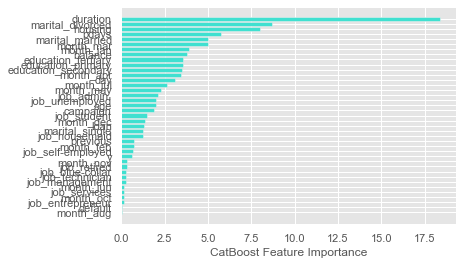

In [184]:
sorted_feature_importance = model.feature_importances_.argsort() # отсортируем признаки по важности
# и построим график
plt.barh(data.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

# Stacking


In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

In [186]:
os_data_X = pd.read_csv('my_os_data_X.csv')
os_data_y = pd.read_csv('my_os_data_y.csv').values.ravel()

In [187]:
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, stratify=os_data_y, test_size=0.3, random_state=17)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=75, random_state=17, n_jobs=-1, 
                                 oob_score=True, max_features=6, max_depth=24, min_samples_leaf=1)),
    ('svr', make_pipeline(StandardScaler(),
                           LinearSVC(random_state=17))),
    ('xgb', xgboost.XGBClassifier(max_depth=6, n_estimators=75, colsample_bytree=0.7, 
                                  learning_rate=0.2, reg_alpha=0, reg_lambda=1, subsample=0.7))
 ]
clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(X_train, y_train)
# print('Соответствует ранее определенной accuracy на тестовой выборке для StackingClassifier со значениями параметров по умолчанию:')
# print('learning_rate = ',clf.best_score_)

C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ZuZu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=24,
                                                       max_features=6,
                                                       n_estimators=75,
                                                       n_jobs=-1,
                                                       oob_score=True,
                                                       random_state=17)),
                               ('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=17))])),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                            

Доля правильных ответов Accuracy= 0.884108867427568
Мера F1= 0.8660662847478133
Точность Precision= 0.8622409455441528
Полнота Recall= 0.884108867427568


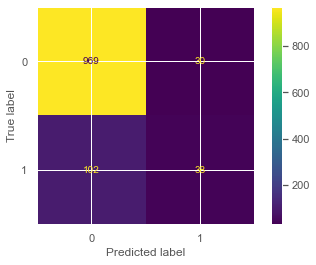

In [188]:
# проверяем на тестовых заранее отложенных данных
X_test = pd.read_csv('my_X_test.csv')
y_test = pd.read_csv('my_y_test.csv')

pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted', labels=np.unique(pred))
precision = precision_score(y_test, pred, average='weighted', labels=np.unique(pred))
recall=recall_score(y_test, pred, average='weighted', labels=np.unique(pred))

print('Доля правильных ответов Accuracy=',accuracy)
print('Мера F1=',f1)
print('Точность Precision=',precision)
print('Полнота Recall=',recall)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

**Вывод:**

Accuracy на тестовой выборке использовании стэкинга 88.67%, что выше, чем при использовании стохастического градиентного бустинга (87%).